# Predicting genre identification

## Can a genre be identified by certain audio features of a song, or by other features?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import copy
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
%matplotlib inline

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#import file
df=pd.read_csv("./Data/datacleanedwithbb.csv")

In [4]:
music=df.copy()

In [5]:
#check that the bank U2 has the same genre values
music[music['artist_name']=="U2"]

Unnamed: 0  artist_familiarity  artist_hotttnesss           artist_id  \
1334        1334            0.843527           0.825639  ARUJ5A41187FB3F5F1   
2472        2472            0.843527           0.750312  ARUJ5A41187FB3F5F1   
4522        4522            0.843527           0.750312  ARUJ5A41187FB3F5F1   
5852        5852            0.843527           0.750312  ARUJ5A41187FB3F5F1   
9805        9805            0.843527           0.750312  ARUJ5A41187FB3F5F1   
9991        9991            0.843527           0.825639  ARUJ5A41187FB3F5F1   

      artist_latitude  artist_location  artist_longitude artist_name  \
1334              NaN  Dublin, Ireland               NaN          U2   
2472              NaN  Dublin, Ireland               NaN          U2   
4522              NaN  Dublin, Ireland               NaN          U2   
5852              NaN  Dublin, Ireland               NaN          U2   
9805              NaN  Dublin, Ireland               NaN          U2   
9991              NaN  Dublin, Ireland               NaN          U2   

                                           artist_terms  \
1334  [dance rock pop rock british pop ballad classi...   
2472  [dance rock pop rock british pop ballad classi...   
4522  [dance rock pop rock british pop ballad classi...   
5852  [dance rock pop rock british pop ballad classi...   
9805  [dance rock pop rock british pop ballad classi...   
9991  [dance rock pop rock british pop ballad classi...   

                                      artist_terms_freq  \
1334  [1.         0.99322079 0.86311185 0.8618149  0...   
2472  [1.         0.99322079 0.86311185 0.8618149  0...   
4522  [1.         0.99322079 0.86311185 0.8618149  0...   
5852  [1.         0.99322079 0.86311185 0.8618149  0...   
9805  [1.         0.99322079 0.86311185 0.8618149  0...   
9991  [1.         0.99322079 0.86311185 0.8618149  0...   

               ...            bars_start_mean  bars_confidence_mean  \
1334           ...                 158.377977              0.169876   
2472           ...                 236.177074              0.144447   
4522           ...                 170.288803              0.142663   
5852           ...                 221.015696              0.167625   
9805           ...                 200.705664              0.142914   
9991           ...                  68.278547              0.166170   

      tatums_start_mean  tatums_confidence_mean       genre  decade  \
1334         159.262112                0.236505  dance rock    2000   
2472         237.295151                0.160598  dance rock    2000   
4522         171.490087                0.471077  dance rock    1990   
5852         222.285643                0.498900  dance rock    2000   
9805         201.834156                0.156459  dance rock    1990   
9991          69.851490                0.294919  dance rock    1980   

      mode_orig  bb_hot         title_vect              artist_vect  
1334        1.0       0  [0 0 0 ... 0 0 0]  [0. 0. 0. ... 0. 0. 0.]  
2472        1.0       0  [0 0 0 ... 0 0 0]  [0. 0. 0. ... 0. 0. 0.]  
4522        0.0       1  [0 0 0 ... 0 0 0]  [0. 0. 0. ... 0. 0. 0.]  
5852        0.0       1  [0 0 0 ... 0 0 0]  [0. 0. 0. ... 0. 0. 0.]  
9805        1.0       0  [0 0 0 ... 0 0 0]  [0. 0. 0. ... 0. 0. 0.]  
9991        0.0       0  [0 0 0 ... 0 0 0]  [0. 0. 0. ... 0. 0. 0.]  

[6 rows x 54 columns]

## Feature Engineering & Additional EDA

In [6]:
#create features by taking the confidence of audio measurement times the audio measurement value
music['bars']=music['bars_confidence_mean'] * music['bars_start_mean']
music['beats']=music['beats_confidence_mean'] * music['beats_start_mean']
music['key1']=music['key'] * music['key_confidence']
#music['mode1']=music['mode'] * music['mode_confidence']
music['tatums']=music['tatums_confidence_mean'] * music['tatums_start_mean']
music.drop(['Unnamed: 0','key_confidence', 'similar_artists','mode_confidence'], axis=1, inplace=True)

#rename a column:
music=music.rename(columns={'terms':'genre'})

In [7]:
#fill in missing values with 0 for this exercise
music.fillna(0, inplace=True)
music['artist_location']=music['artist_location'].replace(0,"none")

In [8]:
#label encode columns to become numerical
le = preprocessing.LabelEncoder()
music['artist.name_new'] = le.fit_transform(music['artist_name'].values)
music['title']=music['title'].astype(str)
music['title_new'] = le.fit_transform(music['title'].values)
music['genre']=music['genre'].astype(str)
music['genre_new'] = le.fit_transform(music['genre'].values)
music['release.name_new'] = le.fit_transform(music['release'].values)
music['location_new'] = le.fit_transform(music['artist_location'].values)
music['genre_label'] = le.fit_transform(music['genre'].values)

In [9]:
music.head()

artist_familiarity  artist_hotttnesss           artist_id  artist_latitude  \
0            0.557460           0.386152  AREJXK41187B9A4ACC         46.71067   
1            0.626958           0.434860  AR2XRFQ1187FB417FE          0.00000   
2            0.425724           0.000000  ARODOO01187FB44F4A          0.00000   
3            0.611495           0.334520  ARJGW911187FB586CA          0.00000   
4            0.367255           0.311616  AR9HQ6Y1187FB3C2CB          0.00000   

  artist_location  artist_longitude             artist_name  \
0          France           1.71819          Rapha\xc3\xabl   
1            none           0.00000           Julie Zenatti   
2            none           0.00000   The Baltimore Consort   
3            none           0.00000            I Hate Sally   
4            none           0.00000  Orlando Pops Orchestra   

                                        artist_terms  \
0  [chanson visual kei hip hop pop rock british p...   
1  [chanson dance pop pop rock soft rock female v...   
2  [early music celtic mediaeval folk christmas m...   
3  [post-hardcore doomcore metalcore screamo grin...   
4  [orchestra musical theater british brazil orch...   

                                   artist_terms_freq  \
0  [0.91069762 0.8921657  1.         0.93681689 0...   
1  [1.         0.8729706  0.98238777 0.8729706  0...   
2  [1.         1.         0.67608747 0.88578122 0...   
3  [1.         0.8629106  0.95648867 0.92195179 0...   
4  [0.92855141 0.84423719 1.         0.84641106 0...   

                                 artist_terms_weight     ...            bars  \
0  [1.         0.99153768 0.95545969 0.95344244 0...     ...        9.560556   
1  [1.         0.9211513  0.91246207 0.88300862 0...     ...       21.374251   
2  [1.         0.93946078 0.76226258 0.74165245 0...     ...        3.365668   
3  [1.         0.97730411 0.94105403 0.93582623 0...     ...       11.798215   
4  [1.         0.93971938 0.89713798 0.89712483 0...     ...       12.154677   

       beats   key1     tatums  artist.name_new  title_new  genre_new  \
0  46.020881  0.000  22.917560             3194       4159         68   
1  42.903478  0.429  11.023648             2071       5947         68   
2  20.096655  0.000   7.508566             3777       3478        131   
3  24.207956  2.660   7.438347             1718       5139        328   
4  35.061442  5.510  10.317218             2934       9659        310   

  release.name_new location_new  genre_label  
0             3223          310           68  
1             1405         1042           68  
2             7503         1042          131  
3             1819         1042          328  
4             1917         1042          310  

[5 rows x 60 columns]

## Initially going to try and predict genre based on audio features only 

In [12]:
#just features related to audio features
audio=music[['genre','genre_label','start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
             'mode', 'mode_orig','tatums','loudness','duration','segments_start_mean','segments_pitches_mean',
             'segments_timbre_mean','segments_loudness_max_mean','segments_loudness_max_time_mean',
             'segments_loudness_start_mean','sections_start_mean','beats_start_mean','bars_start_mean',
             'tatums_start_mean']]

In [13]:
audio.head()

genre  genre_label  start_of_fade_out    tempo  time_signature  \
0        chanson           68            141.607  124.059             4.0   
1        chanson           68            241.424   80.084             4.0   
2    early music          131             78.027   54.874             4.0   
3  post-hardcore          328            158.511   77.150             3.0   
4      orchestra          310            195.808  120.382             4.0   

        bars      beats   key   mode  mode_orig        ...          \
0   9.560556  46.020881   0.0  0.556        1.0        ...           
1  21.374251  42.903478   1.0 -0.670        0.0        ...           
2   3.365668  20.096655   3.0  0.000        1.0        ...           
3  11.798215  24.207956   7.0  0.385        1.0        ...           
4  12.154677  35.061442  10.0  0.528        1.0        ...           

   segments_start_mean  segments_pitches_mean  segments_timbre_mean  \
0            69.930830               0.299886              2.050151   
1           117.884180               0.233556              5.169785   
2            33.192217               0.293874             -6.129635   
3            75.375229               0.474389              6.915341   
4            94.439833               0.311624             -5.860741   

   segments_loudness_max_mean  segments_loudness_max_time_mean  \
0                  -12.216512                         0.052350   
1                  -16.459136                         0.086557   
2                  -27.407790                         0.097573   
3                   -6.458269                         0.054662   
4                  -22.336025                         0.101949   

   segments_loudness_start_mean  sections_start_mean  beats_start_mean  \
0                    -19.229238            57.679828         71.025470   
1                    -21.786326           119.968496        123.794350   
2                    -33.395346            21.487460         33.789365   
3                    -10.498846            48.594217         79.666289   
4                    -26.980752            84.804912         98.247921   

   bars_start_mean  tatums_start_mean  
0        70.298204          71.025247  
1       130.630938         123.792848  
2        30.497964          33.788618  
3        79.627999          79.796557  
4        97.253457          98.247266  

[5 rows x 23 columns]

In [14]:
audio.describe()

genre_label  start_of_fade_out        tempo  time_signature  \
count  9995.000000        9995.000000  9995.000000     9995.000000   
mean    213.253027         229.985850   122.922565        3.564782   
std     128.883688         112.221773    35.186337        1.266508   
min       0.000000           1.044000     0.000000        0.000000   
25%     101.000000         168.855500    96.969500        3.000000   
50%     212.000000         213.879000   120.162000        4.000000   
75%     327.000000         266.298000   144.014500        4.000000   
max     456.000000        1813.426000   262.828000        7.000000   

              bars        beats          key         mode    mode_orig  \
count  9995.000000  9995.000000  9995.000000  9995.000000  9995.000000   
mean     19.646608    50.373706     5.275838     0.207679     0.691246   
std      16.616770    33.124952     3.553622     0.470874     0.462003   
min       0.000000     0.000000     0.000000    -1.000000     0.000000   
25%      10.248117    28.048229     2.000000    -0.284000     0.000000   
50%      14.772041    44.720658     5.000000     0.396000     1.000000   
75%      22.600882    65.744298     8.000000     0.569000     1.000000   
max     228.961508   349.820247    11.000000     1.000000     1.000000   

            tatums        ...          segments_start_mean  \
count  9995.000000        ...                  9995.000000   
mean     37.245635        ...                   116.275281   
std      31.037006        ...                    57.461186   
min       0.000000        ...                     0.545297   
25%      16.662984        ...                    85.168425   
50%      28.752035        ...                   107.925955   
75%      48.341279        ...                   134.482018   
max     526.264137        ...                   947.523995   

       segments_pitches_mean  segments_timbre_mean  \
count            9995.000000           9995.000000   
mean                0.350123              3.945109   
std                 0.069079              6.684690   
min                 0.136853            -41.566552   
25%                 0.300023              0.222382   
50%                 0.349272              4.603025   
75%                 0.396976              8.164504   
max                 0.819109             61.623603   

       segments_loudness_max_mean  segments_loudness_max_time_mean  \
count                 9995.000000                      9995.000000   
mean                   -13.693224                         0.063529   
std                      6.266367                         0.052782   
min                    -53.503928                         0.020159   
25%                    -16.930939                         0.048631   
50%                    -12.477887                         0.057246   
75%                     -9.226131                         0.069584   
max                     -1.908739                         4.412194   

       segments_loudness_start_mean  sections_start_mean  beats_start_mean  \
count                   9995.000000          9995.000000       9995.000000   
mean                     -21.791710           105.502954        117.154543   
std                        6.909215            56.593537         56.747788   
min                      -59.605333             0.000000          0.000000   
25%                      -25.819073            74.504308         86.166387   
50%                      -21.092325            97.250315        109.650670   
75%                      -16.968772           124.671871        136.257571   
max                       -6.077756           900.356482        909.751515   

       bars_start_mean  tatums_start_mean  
count      9995.000000        9995.000000  
mean        116.138690         117.217360  
std          56.826207          56.698268  
min           0.000000           0.000000  
25%          85.055830          86.186487  
50%         108.595489         109.676086  
75%         135.29228

## There are  457 different genres listed in the dataset.  That would prove near impossible to accurately predict on.  To start, will just identify and use the top 10 genres and make that the new dataset

In [15]:
music['genre'].value_counts()

blues-rock              346
hip hop                 346
ccm                     255
chanson                 208
country rock            156
latin jazz              150
post-grunge             146
dance pop               141
gangster rap            134
roots reggae            131
pop rock                130
progressive house       119
heavy metal              97
dancehall                97
power pop                94
rock                     92
chill-out                90
salsa                    82
jazz funk                80
hardcore punk            79
lovers rock              76
country gospel           75
honky tonk               73
post-hardcore            72
irish folk               70
folk-pop                 69
alternative metal        67
dance rock               67
tech house               65
soundtrack               65
                       ... 
synth punk                1
highlife                  1
riot grrrl                1
funeral doom              1
slow core           

In [16]:
#systematically find top 10 genres and put in list
mgc=music['genre'].value_counts()
mgc=mgc[:10]
mgc=(mgc.index)
mgc=[i for i in mgc]
mgc

['blues-rock',
 'hip hop',
 'ccm',
 'chanson',
 'country rock',
 'latin jazz',
 'post-grunge',
 'dance pop',
 'gangster rap',
 'roots reggae']

In [17]:
#filter df

audio=audio.loc[audio['genre'].isin(mgc)]
audio.reset_index(inplace = True)

In [18]:
audio.head(15)

index         genre  genre_label  start_of_fade_out    tempo  \
0       0       chanson           68            141.607  124.059   
1       1       chanson           68            241.424   80.084   
2      11       hip hop          214            580.702  146.331   
3      15       hip hop          214            379.478  135.503   
4      28    blues-rock           35            312.041   92.971   
5      31    latin jazz          252            186.410   78.843   
6      34    blues-rock           35            260.725  107.183   
7      38    blues-rock           35            195.587  111.523   
8      40    blues-rock           35            461.714  138.512   
9      43  roots reggae          365            206.391  159.943   
10     75     dance pop          105            461.410  131.999   
11     80       hip hop          214            217.763   83.321   
12     92    blues-rock           35            309.899   94.161   
13     97     dance pop          105            248.337  117.988   
14    104       hip hop          214            278.320  174.731   

    time_signature       bars       beats   key   mode        ...          \
0              4.0   9.560556   46.020881   0.0  0.556        ...           
1              4.0  21.374251   42.903478   1.0 -0.670        ...           
2              4.0  51.113157   75.911117   0.0  0.587        ...           
3              5.0  22.493910   54.521671   1.0  0.155        ...           
4              4.0  21.228022   14.614580   3.0 -0.573        ...           
5              7.0   5.842103   23.004907   7.0  0.416        ...           
6              1.0  91.167323   91.167323   0.0  0.660        ...           
7              1.0  48.531004   48.531004   3.0  0.094        ...           
8              4.0  31.975025   89.806909   1.0 -0.711        ...           
9              4.0   9.924940   71.526352   1.0  0.167        ...           
10             5.0  14.231849  111.725907   1.0  0.409        ...           
11             5.0   8.025126   34.078743  11.0 -0.260        ...           
12             4.0  16.096459   86.099350   3.0  0.346        ...           
13             4.0  14.392119   53.293093  10.0 -0.515        ...           
14             4.0  16.926834   89.277735   4.0 -0.419        ...           

    segments_start_mean  segments_pitches_mean  segments_timbre_mean  \
0             69.930830               0.299886              2.050151   
1            117.884180               0.233556              5.169785   
2            270.529528               0.343717              3.375428   
3            192.488612               0.485925             15.489554   
4            152.613176               0.348786              2.510657   
5             95.237408               0.317965             12.403654   
6            139.609787               0.304079              5.052139   
7            102.333613               0.292447              7.661419   
8            230.628765               0.316269              0.407918   
9            105.991216               0.321193              1.286391   
10           233.530427               0.495728              5.185727   
11           118.464024               0.440397             -2.942816   
12           157.638486               0.310269             -2.125983   
13           122.620449               0.422637              7.264251   
14           145.541745               0.370524              3.666106   

    segments_loudness_max_mean  segments_loudness_max_time_mean  \
0                   -12.216512                         0.052350   
1                   -16.459136                         0.086557   
2                    -6.809419                         0.107121   
3                   -10.167091                         0.042906   
4                    -5.468947                         0.073483   
5                    -7.622960                         0.048740   
6                   -10.937534                         0.054

['start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key', 'mode', 'mode_orig', 'tatums', 'loudness', 'duration', 'segments_start_mean', 'segments_pitches_mean', 'segments_timbre_mean', 'segments_loudness_max_mean', 'segments_loudness_max_time_mean', 'segments_loudness_start_mean', 'sections_start_mean', 'beats_start_mean', 'bars_start_mean', 'tatums_start_mean']


/Users/samlundberg/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


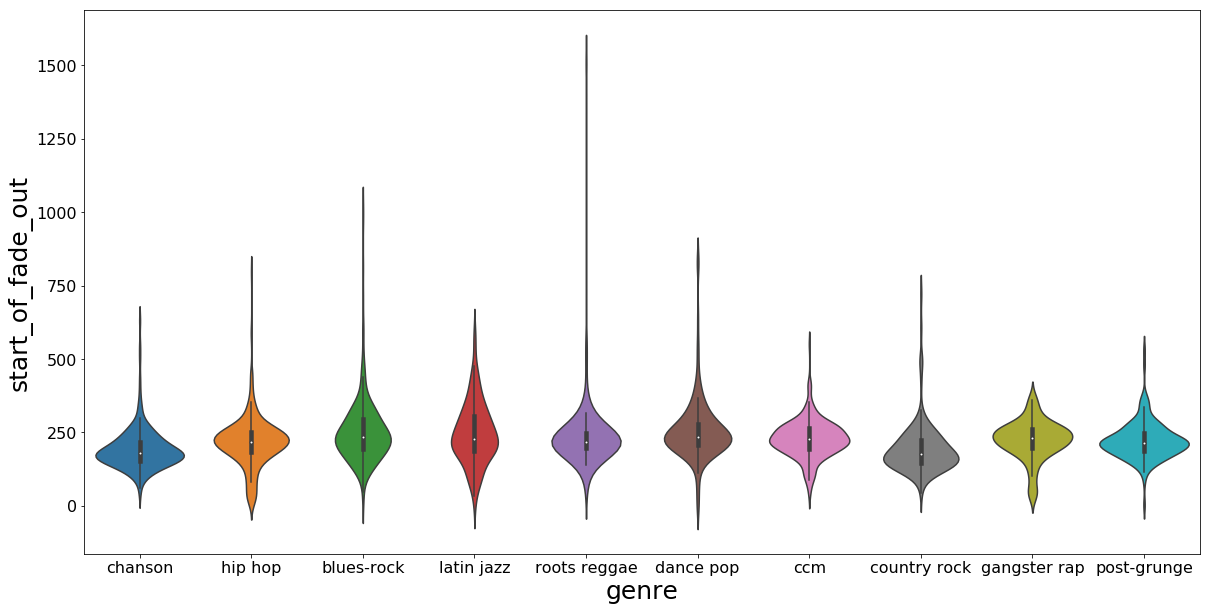

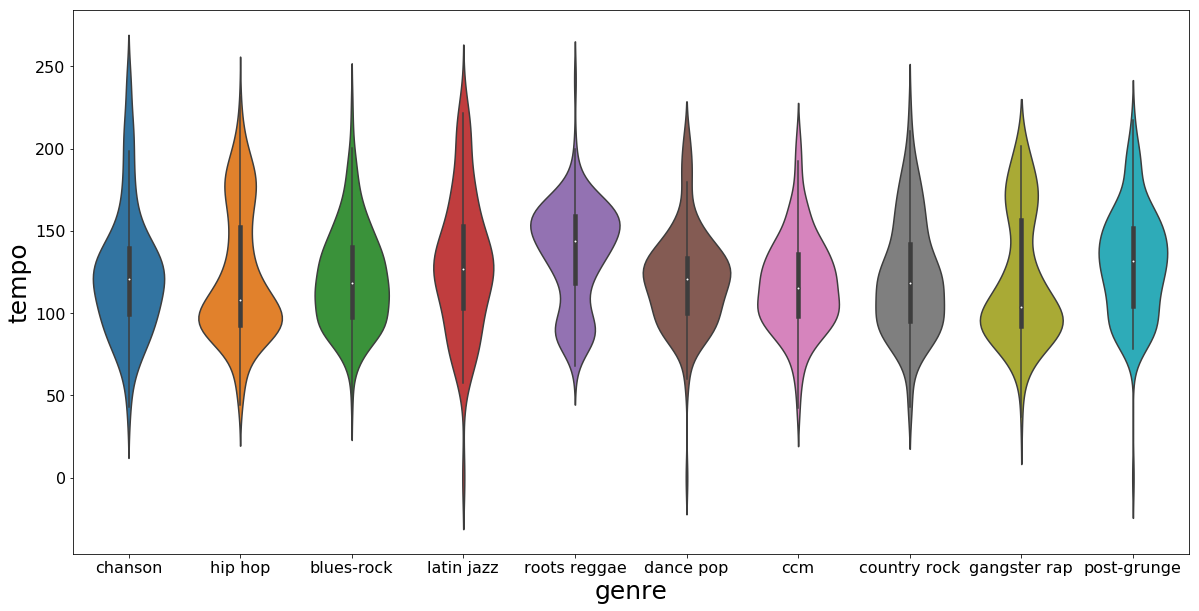

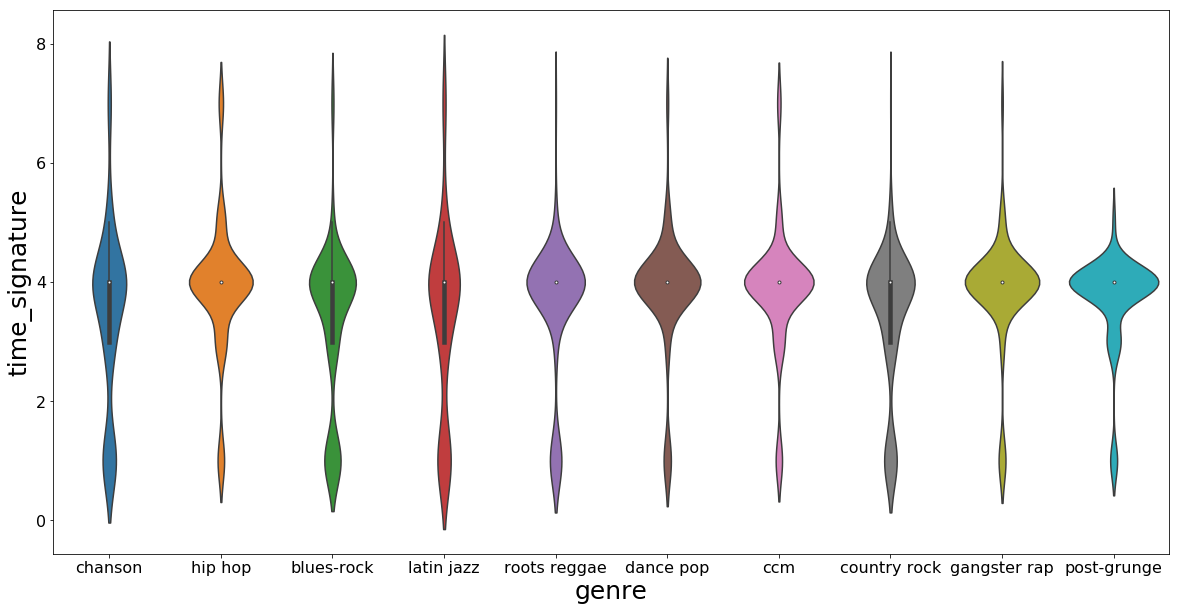

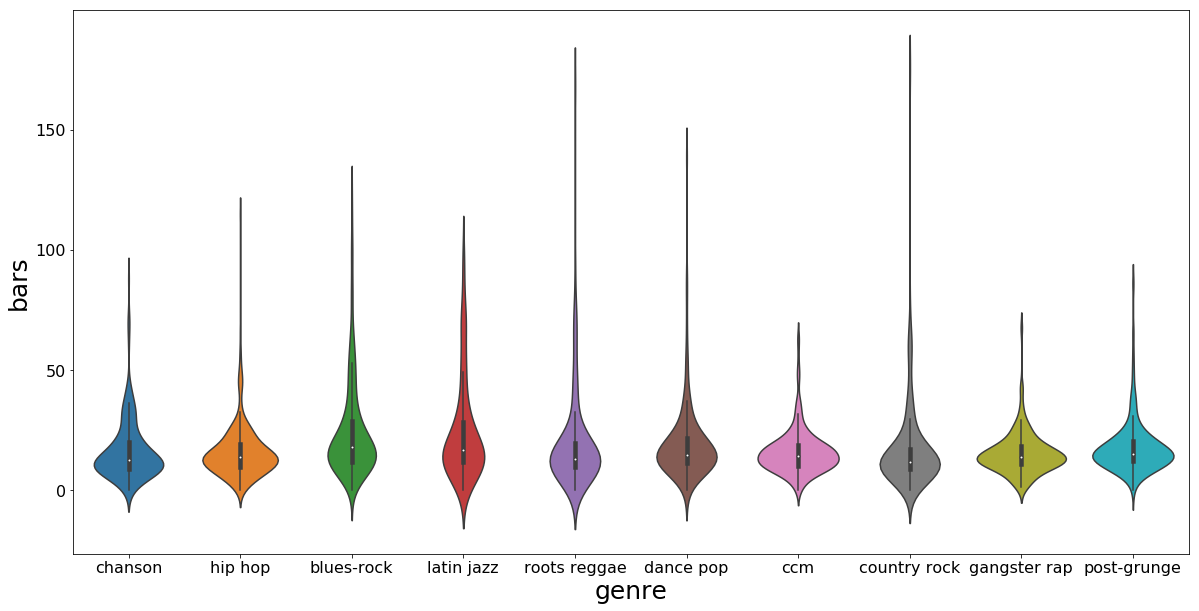

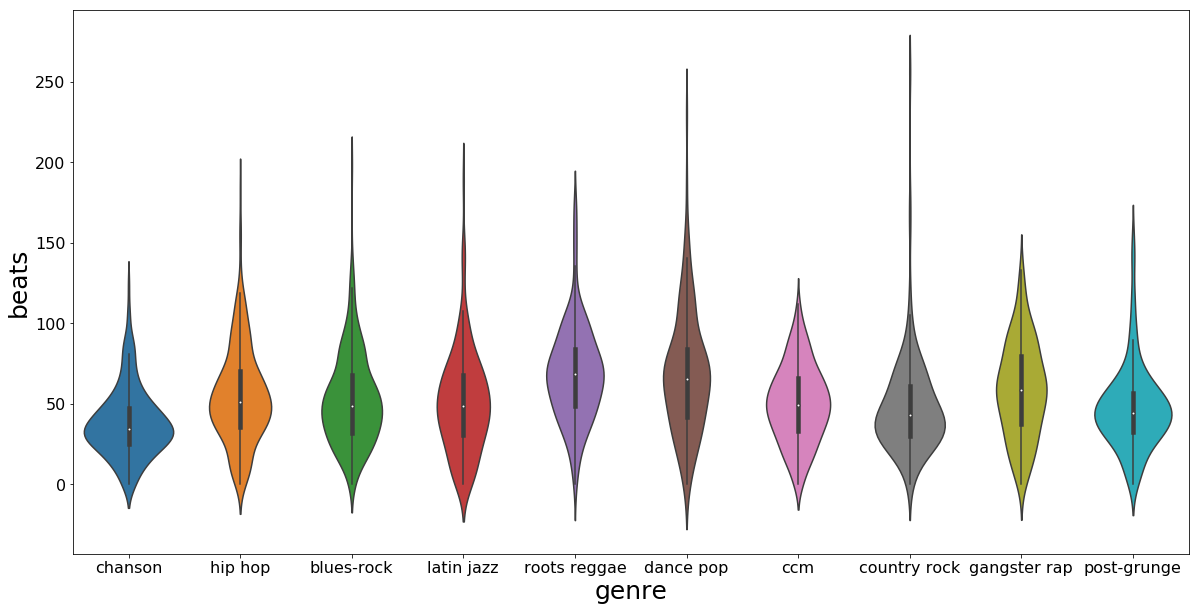

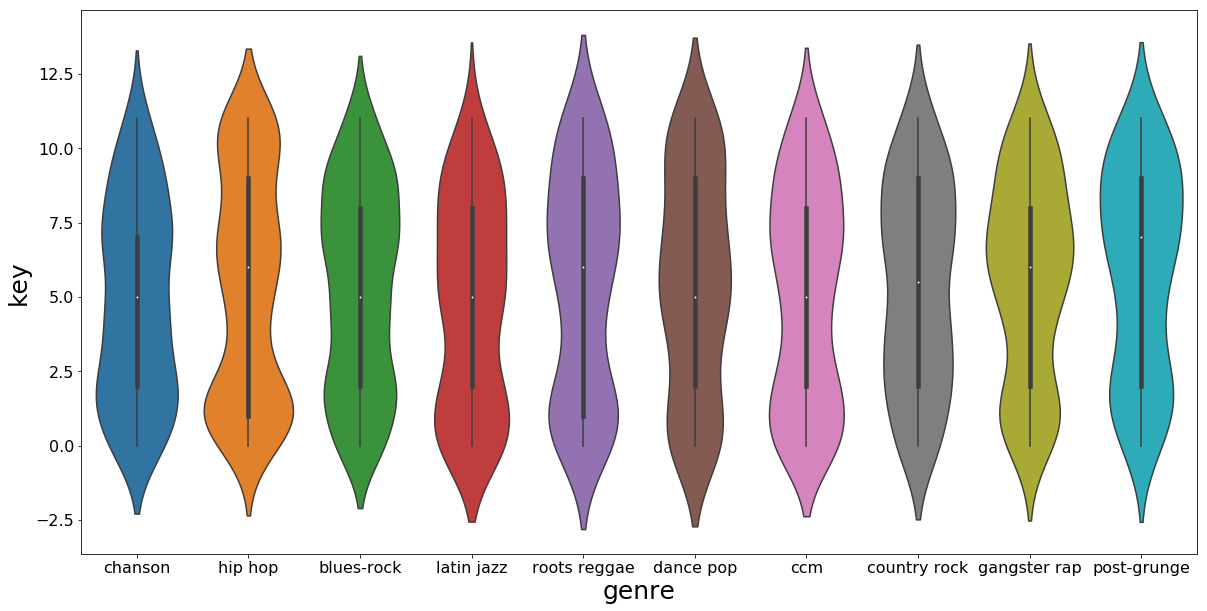

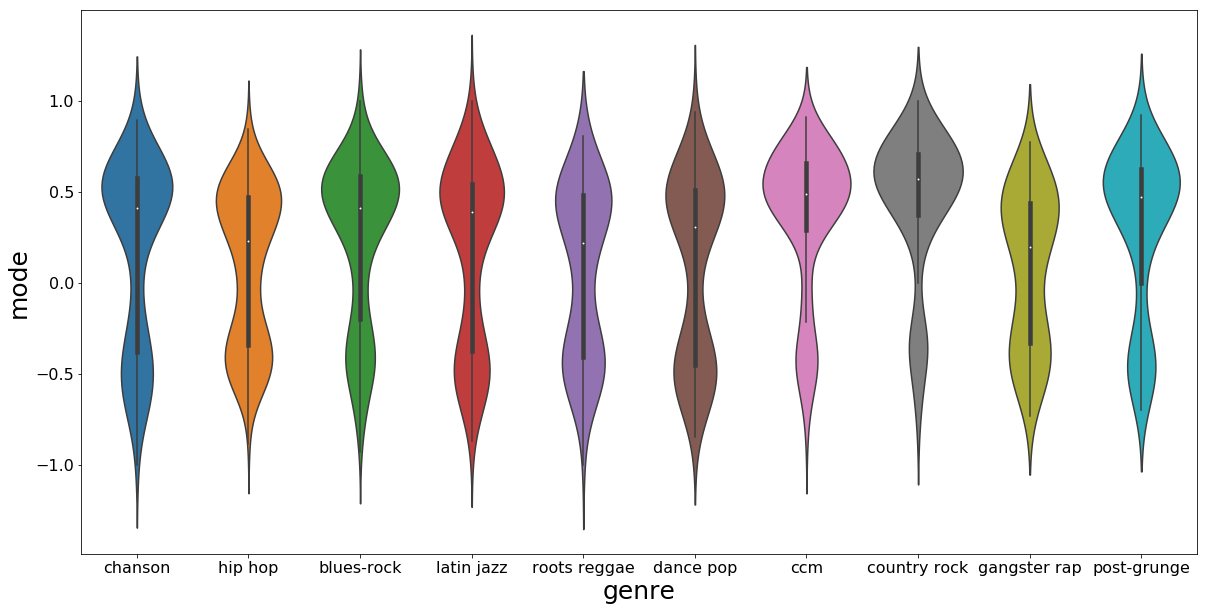

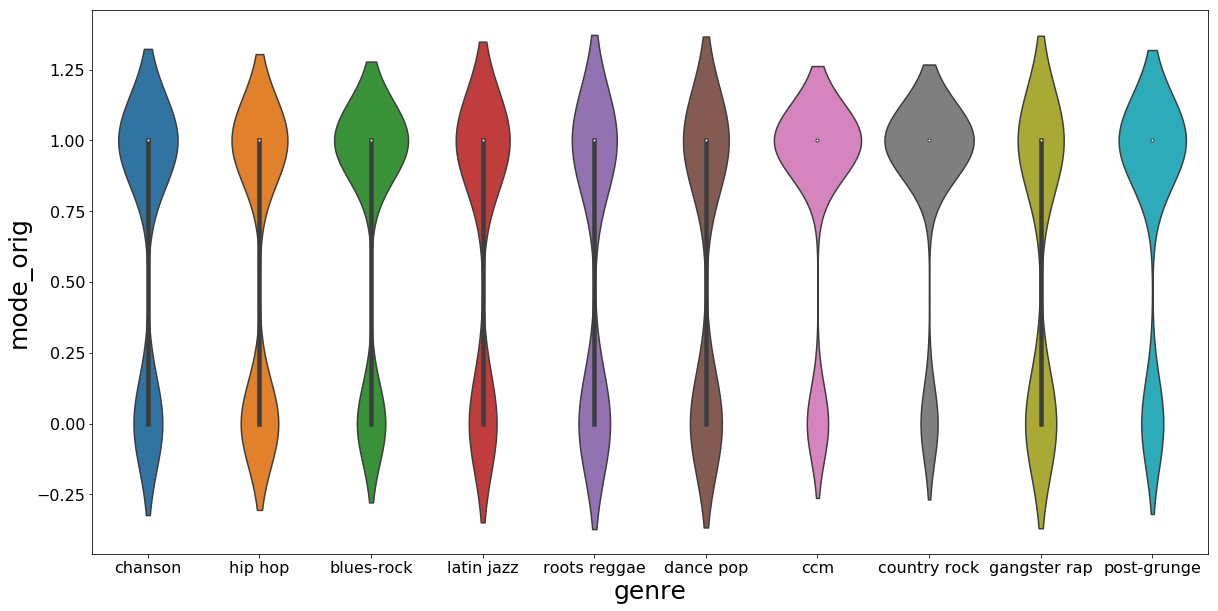

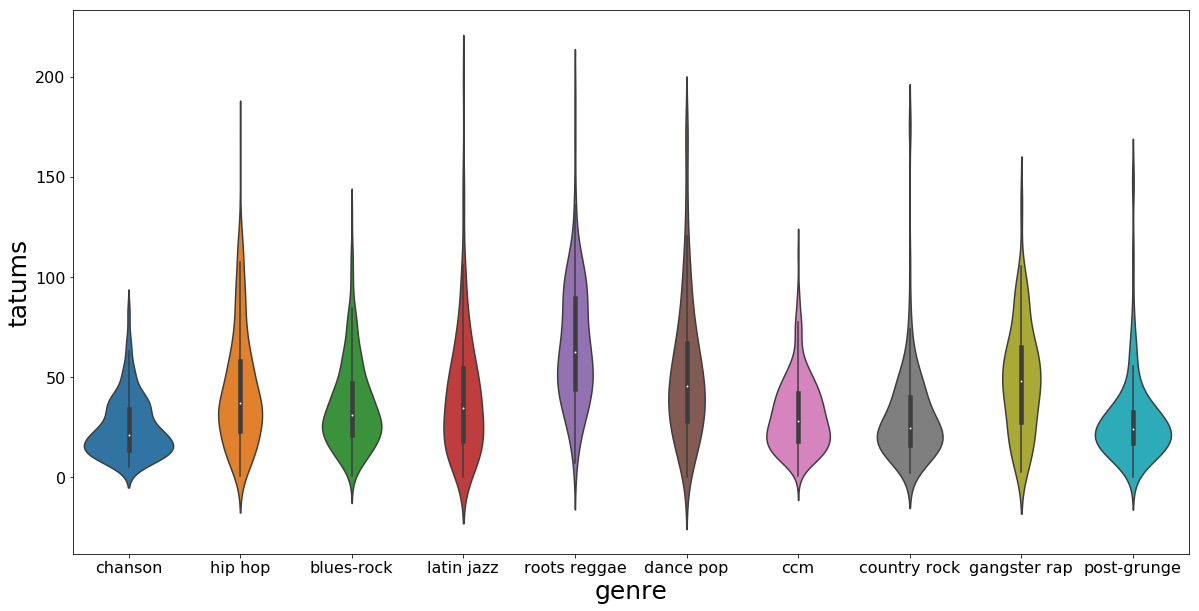

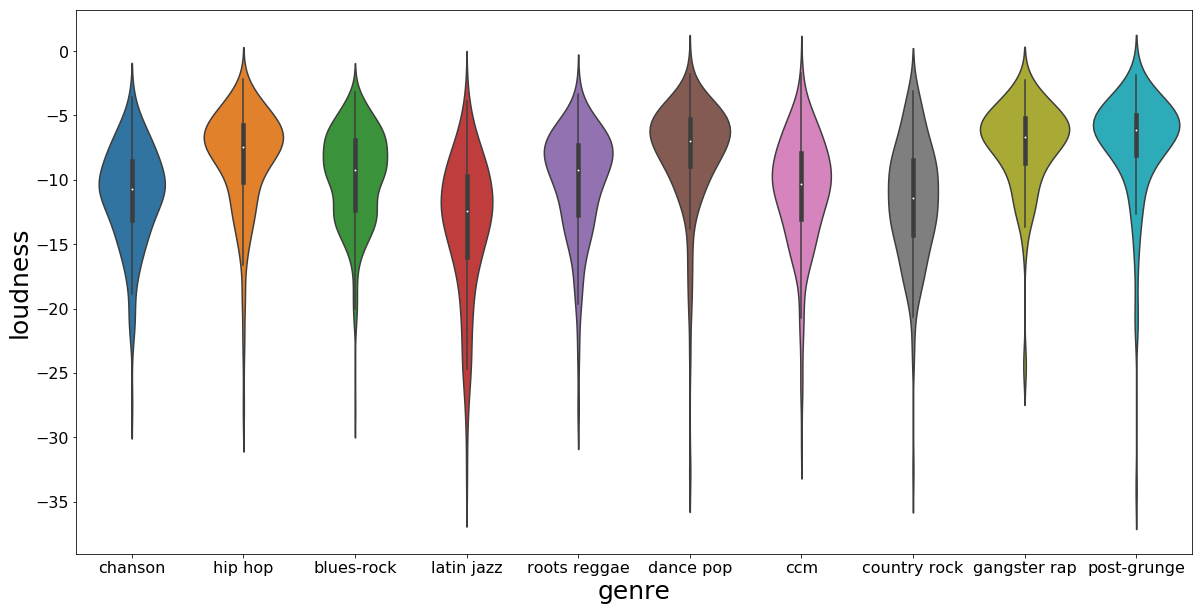

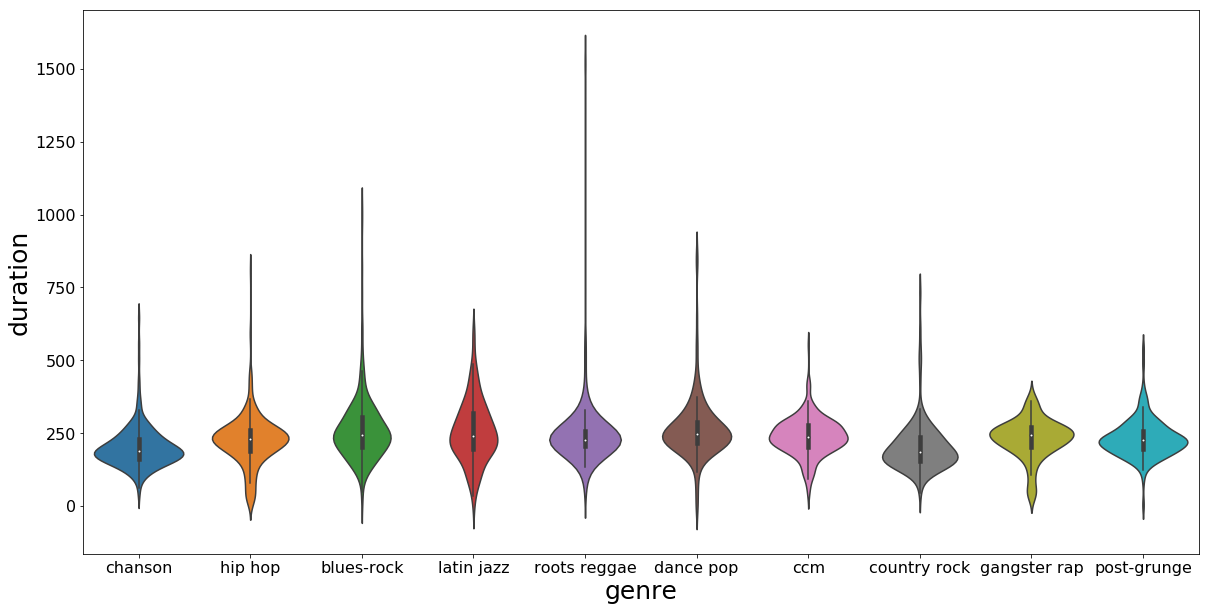

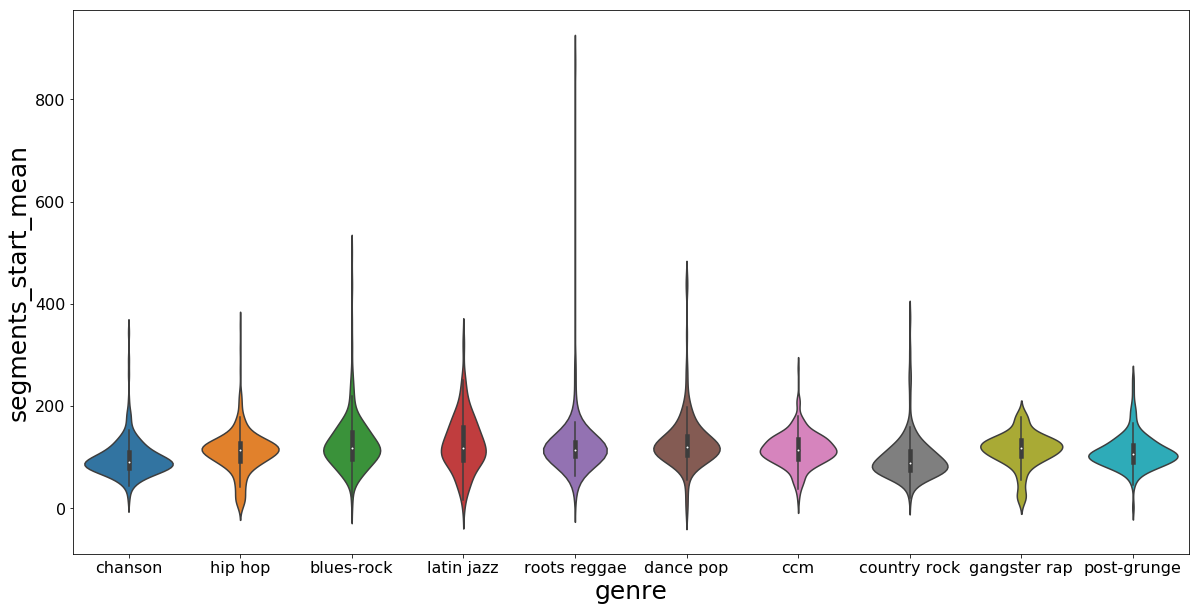

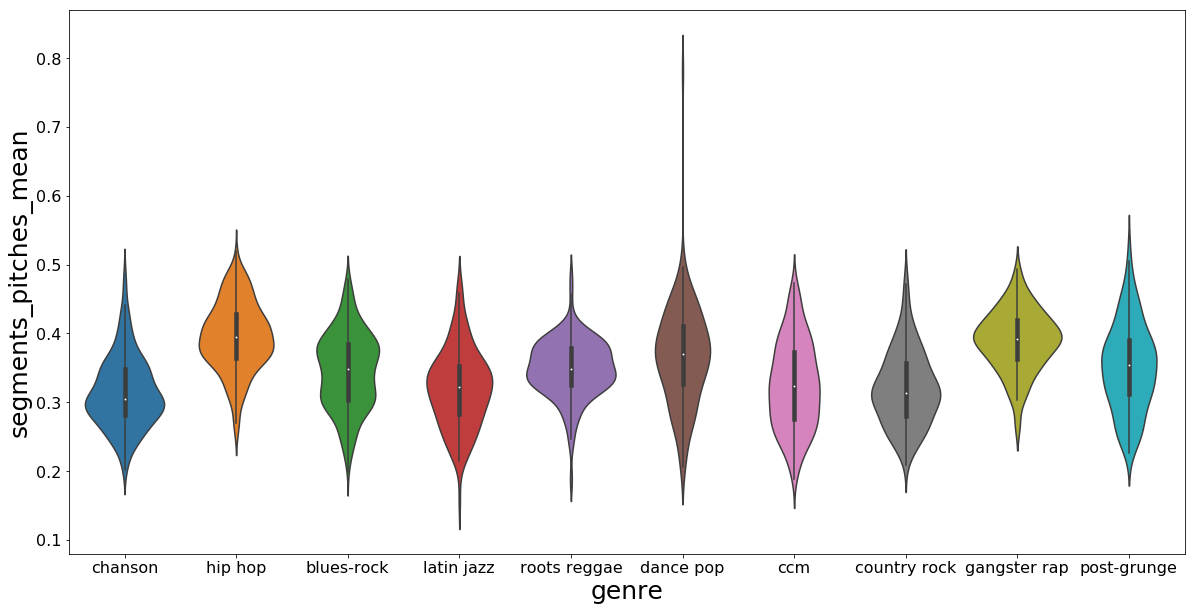

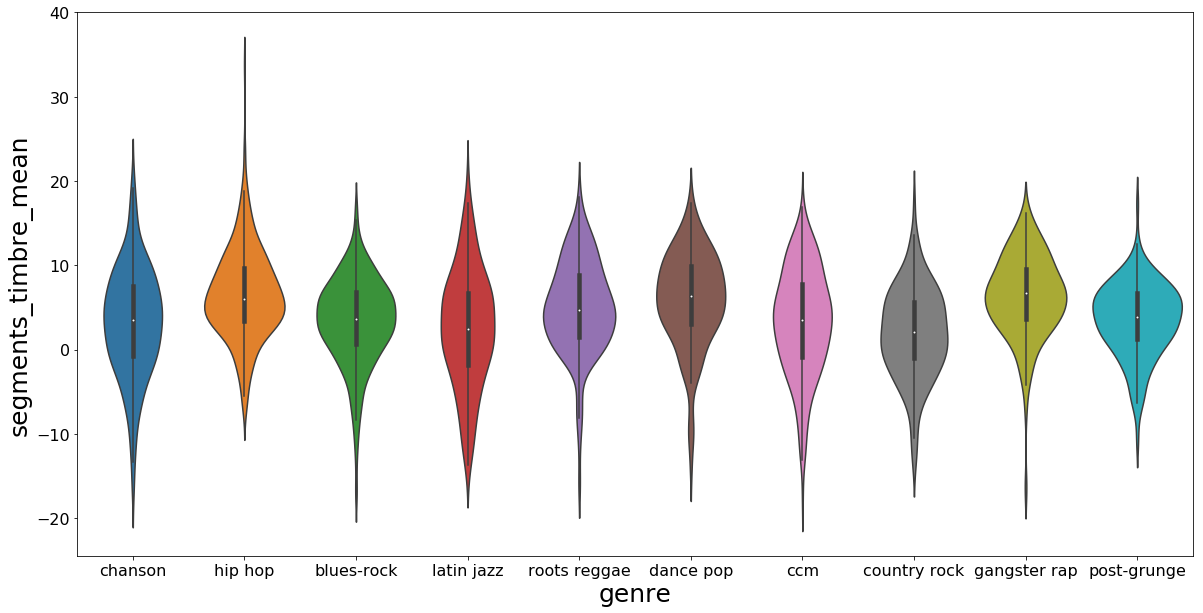

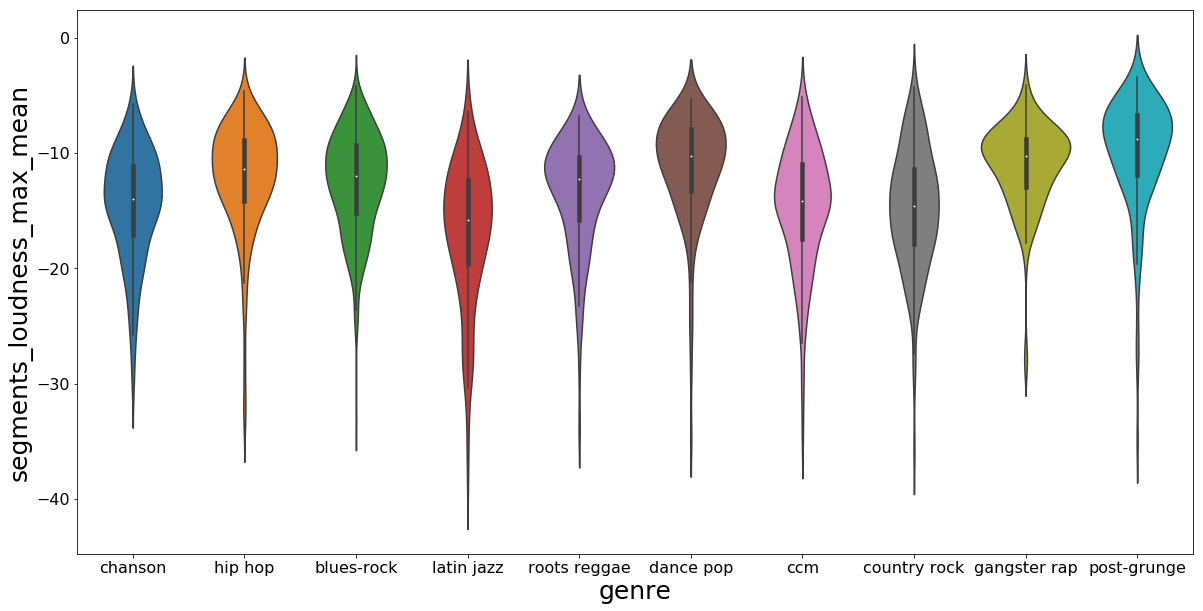

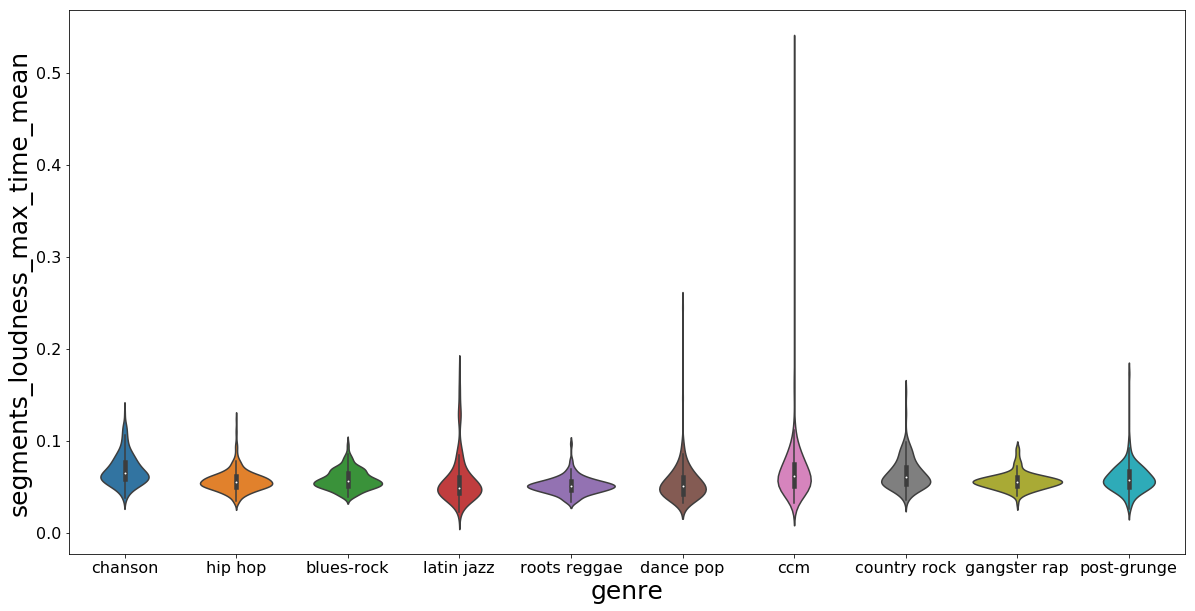

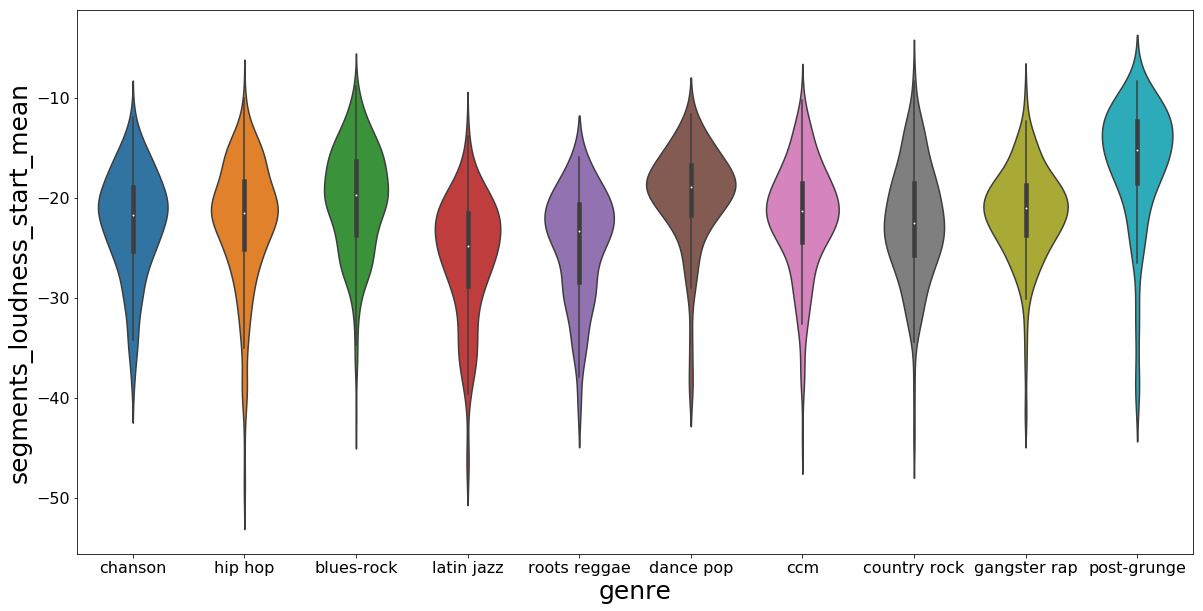

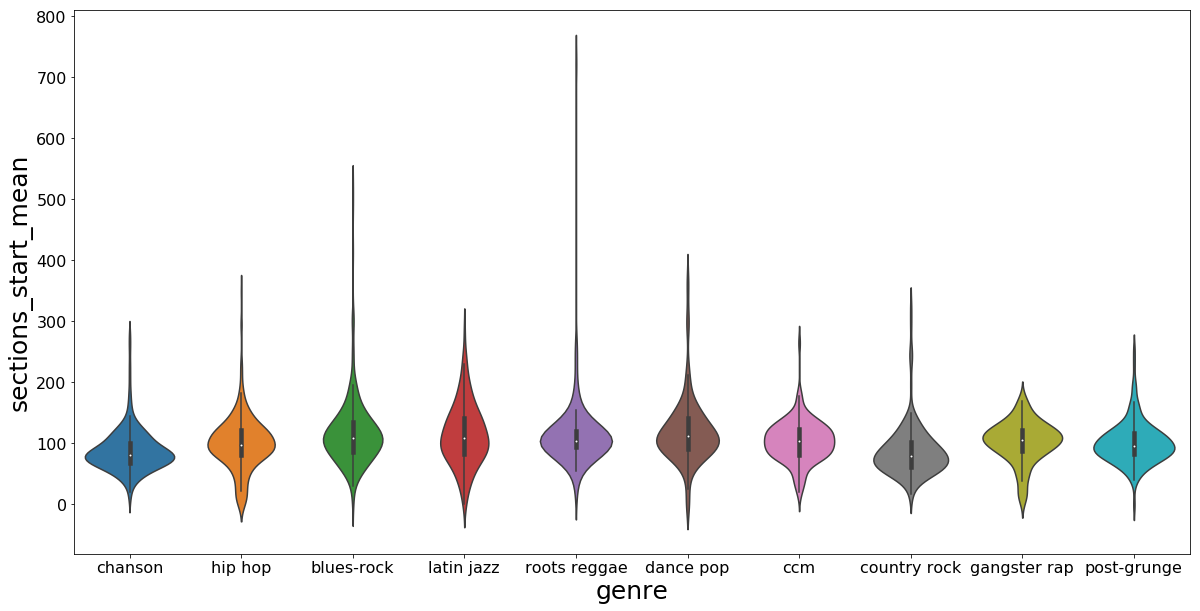

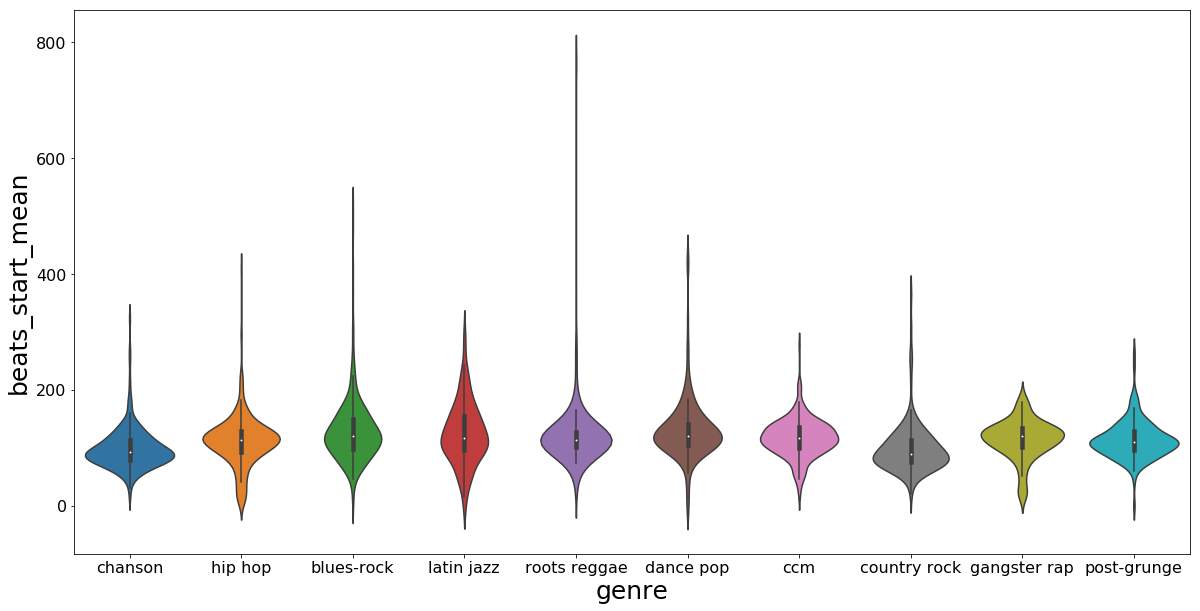

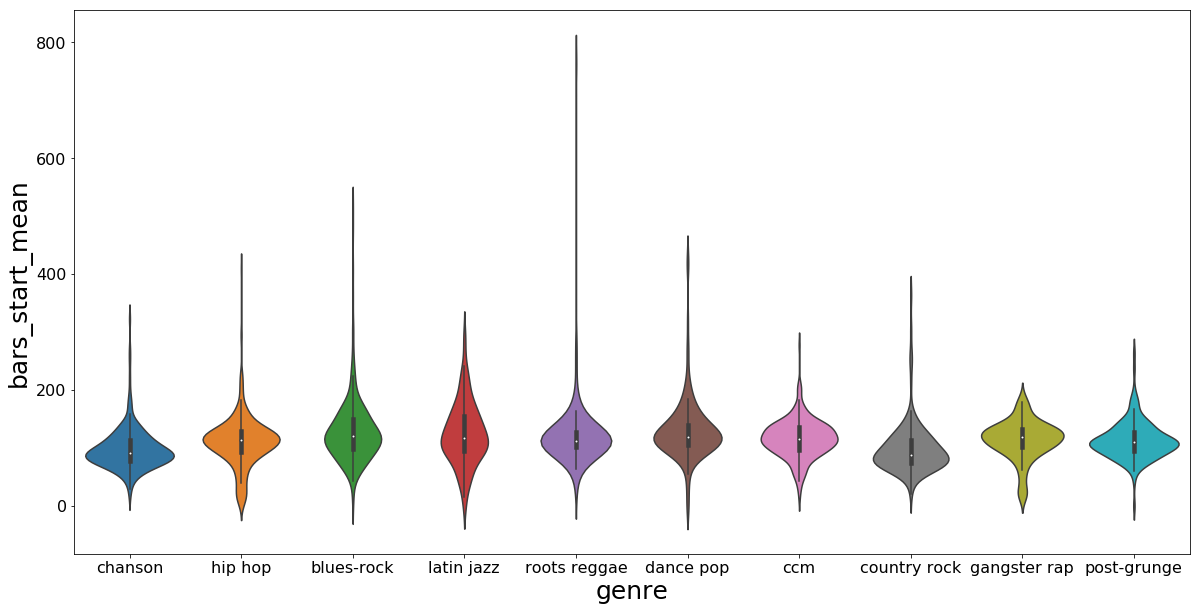

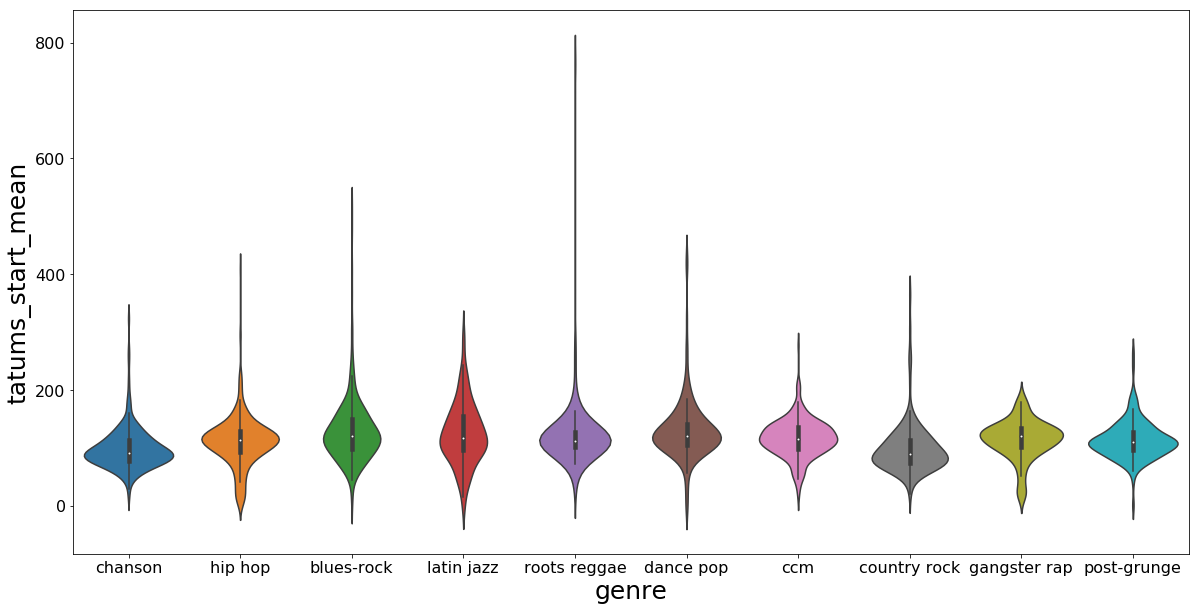

In [19]:
#print initial feature plots of new 10 genre dataset as violin plots
features = list(audio.columns)
features.remove('genre')
features.remove('genre_label')
features.remove('index')
print(features)

for feat in features:
    plt.rcParams["axes.labelsize"] = 25
    fig, ax = plt.subplots(figsize=(20,10))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    sns.violinplot(data=audio, x='genre', y=feat, figsize=(20,10),);

In [20]:
#sanity check to make sure the average tempo of a genre matches duration plot above
audio[audio['genre']=='roots reggae']['duration'].mean()

247.42121358778627

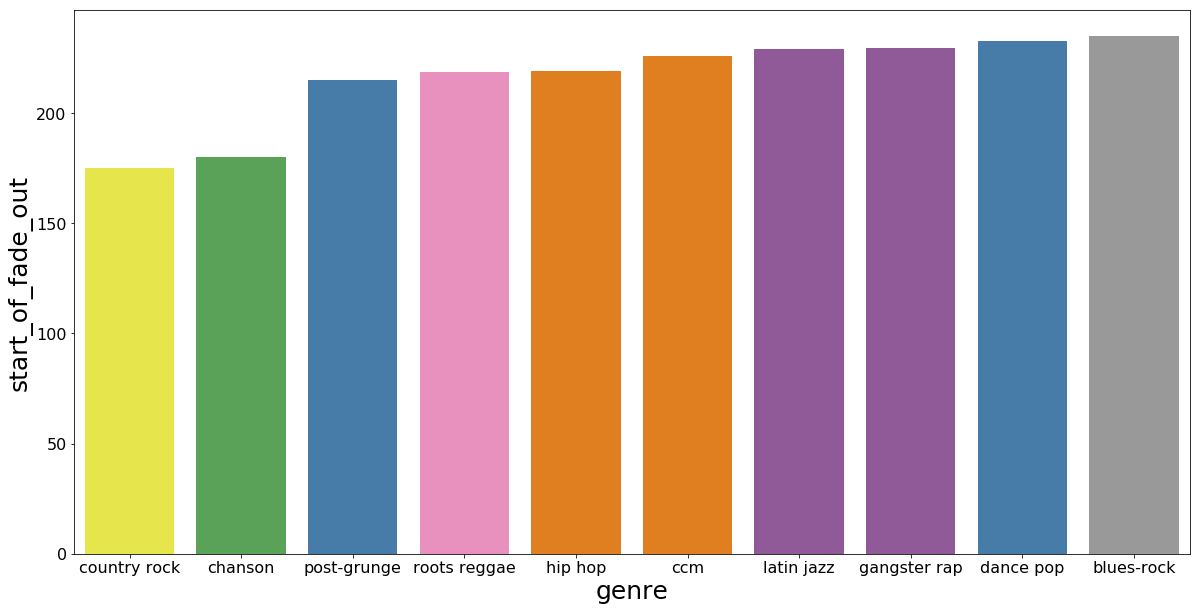

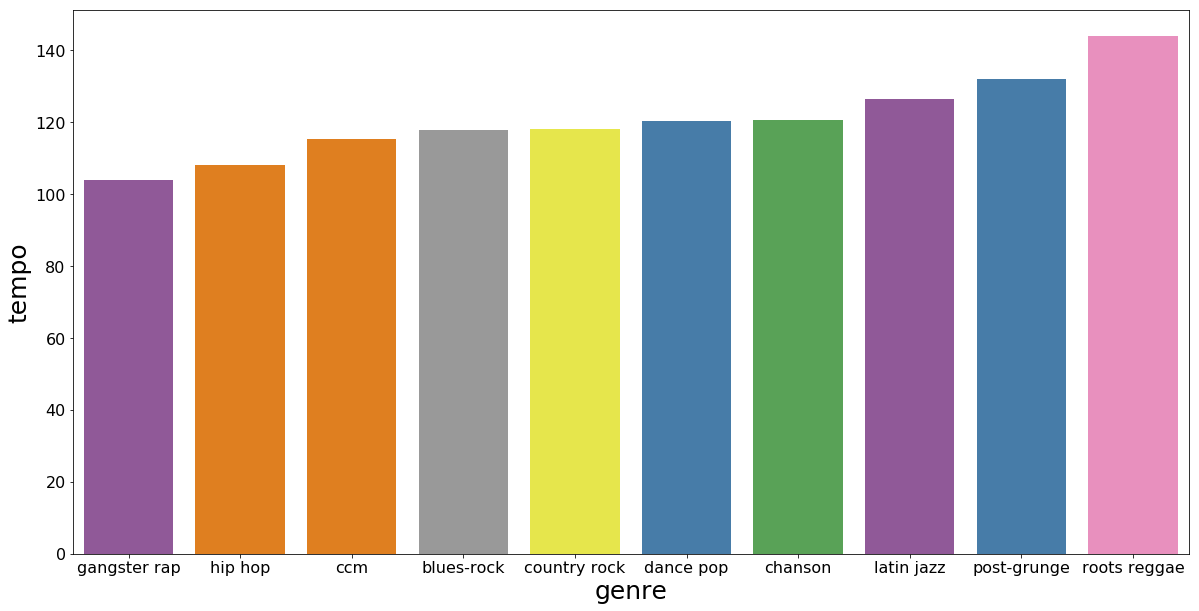

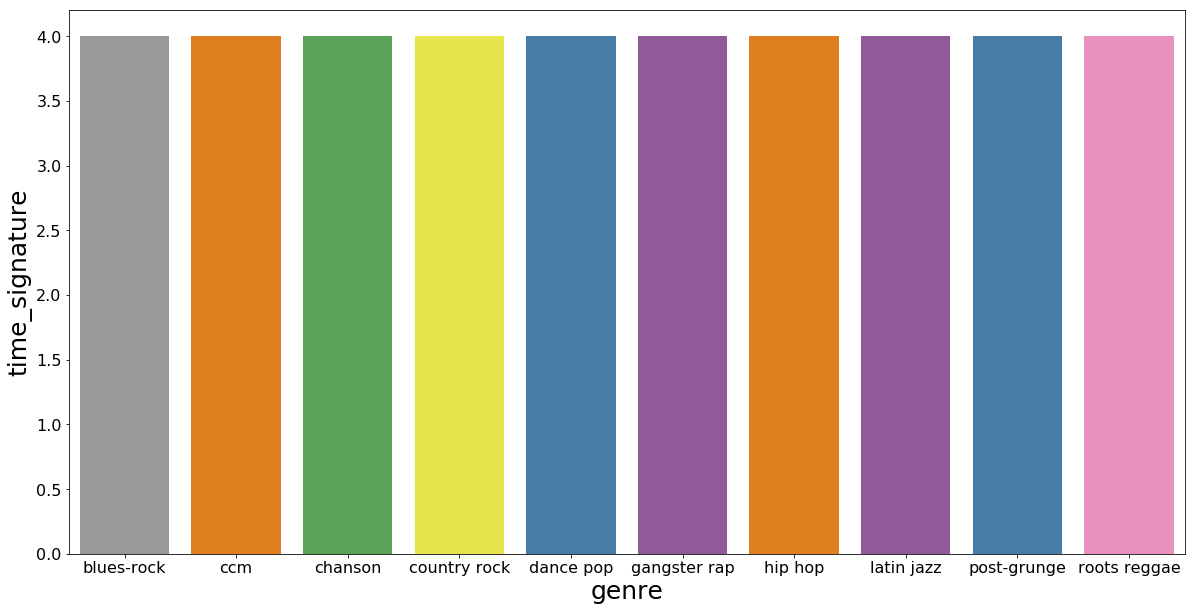

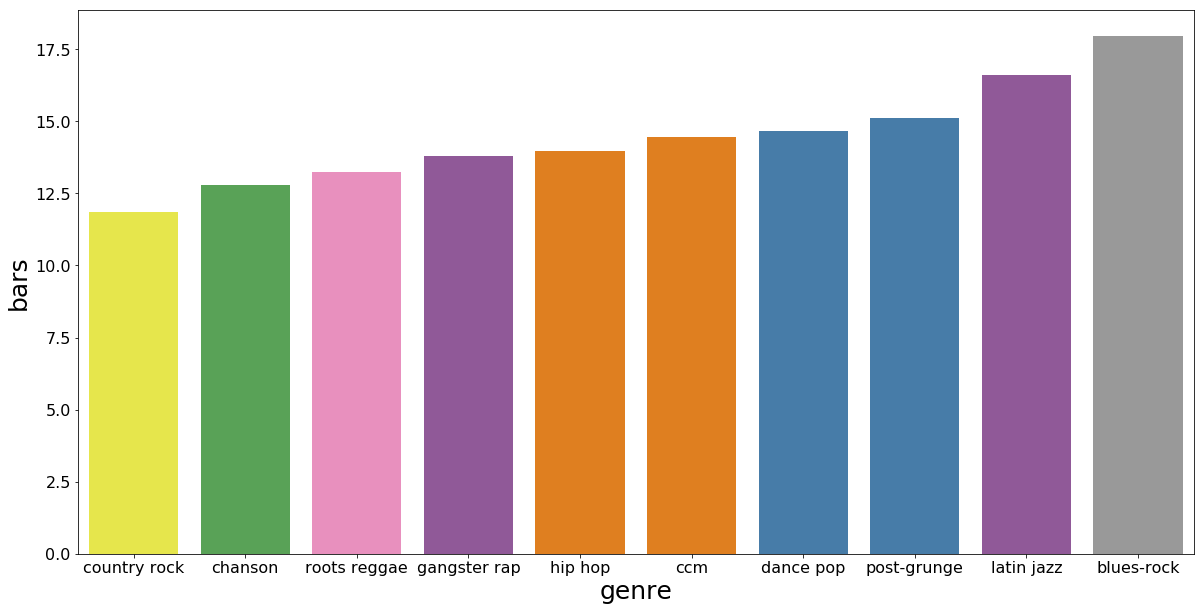

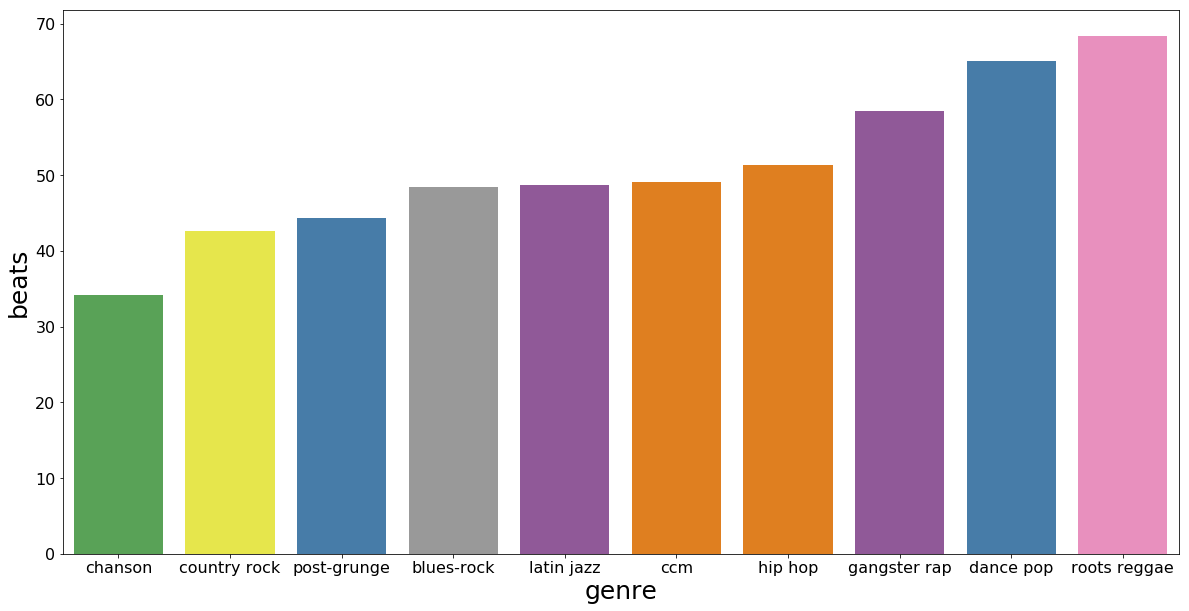

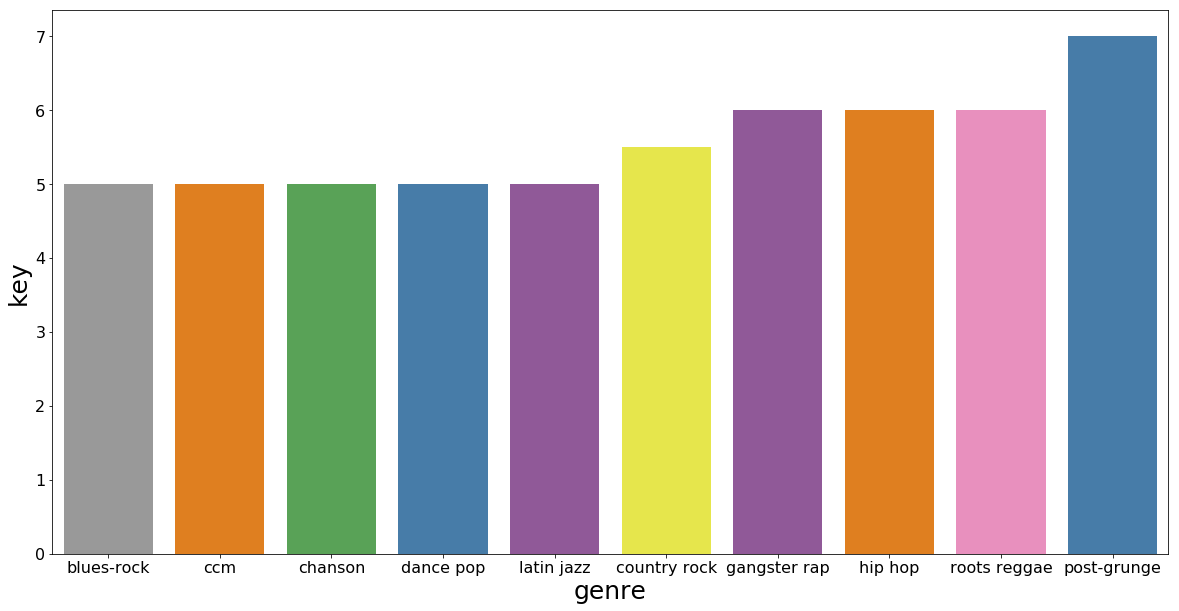

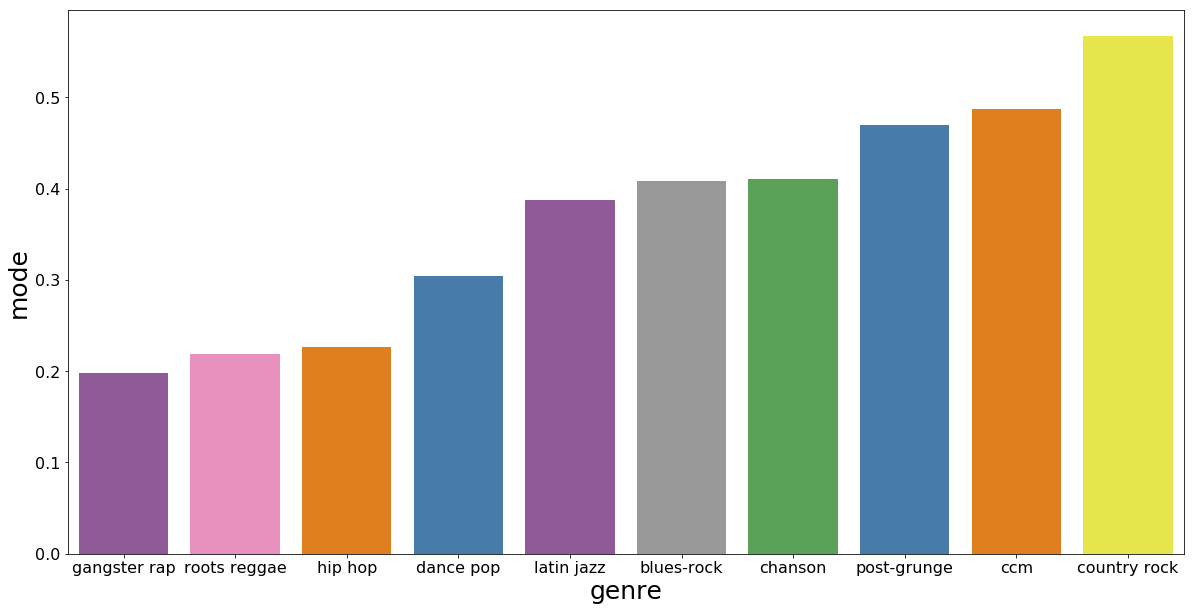

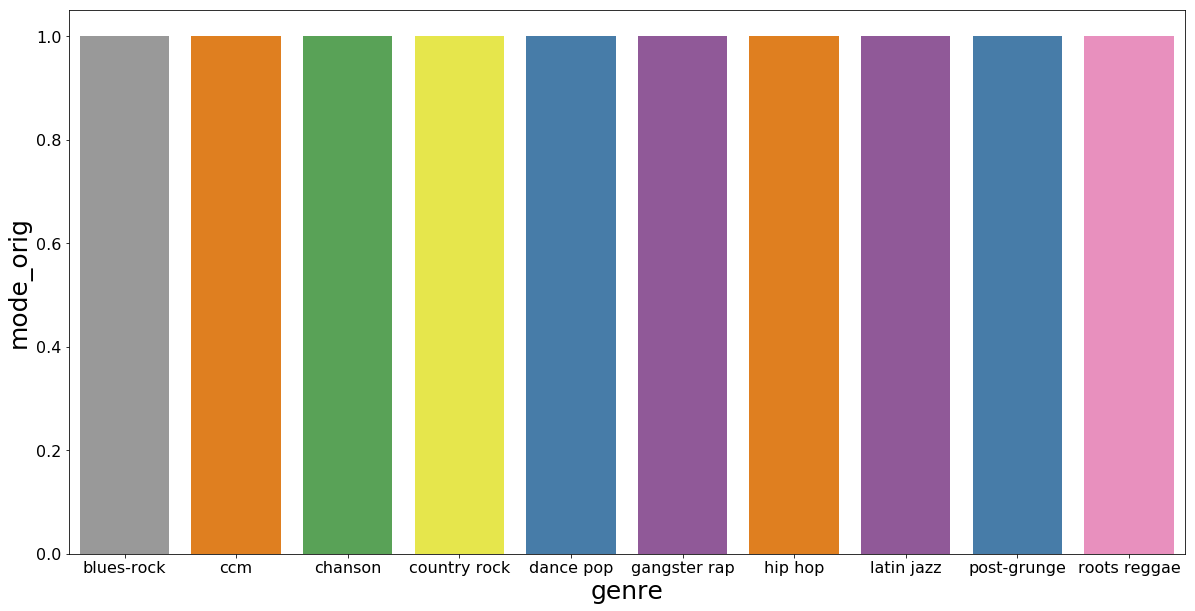

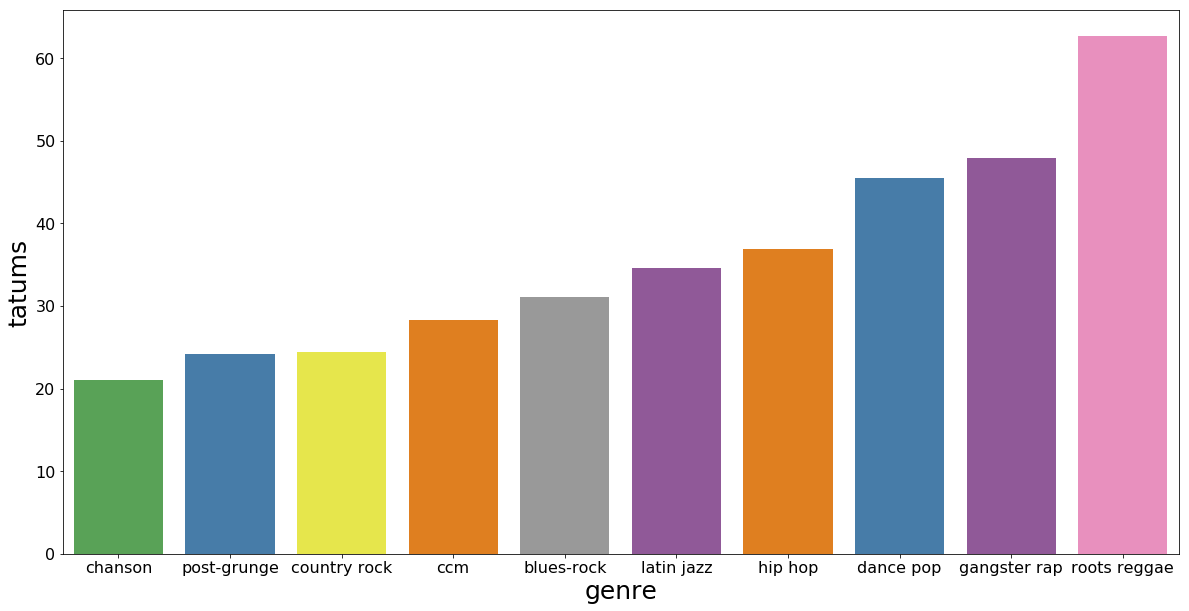

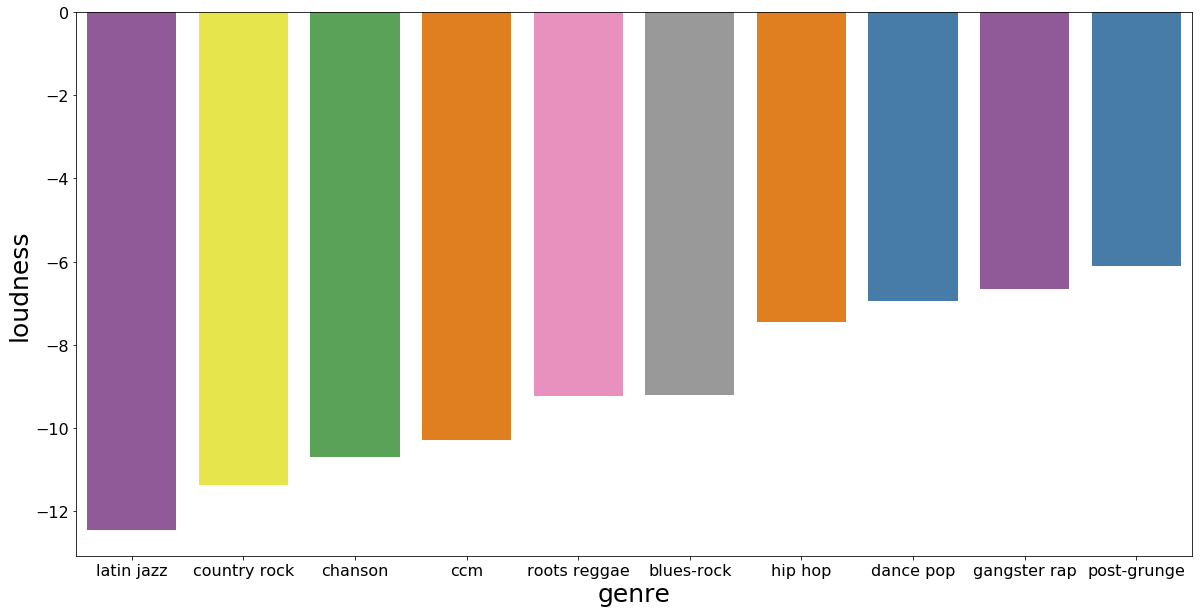

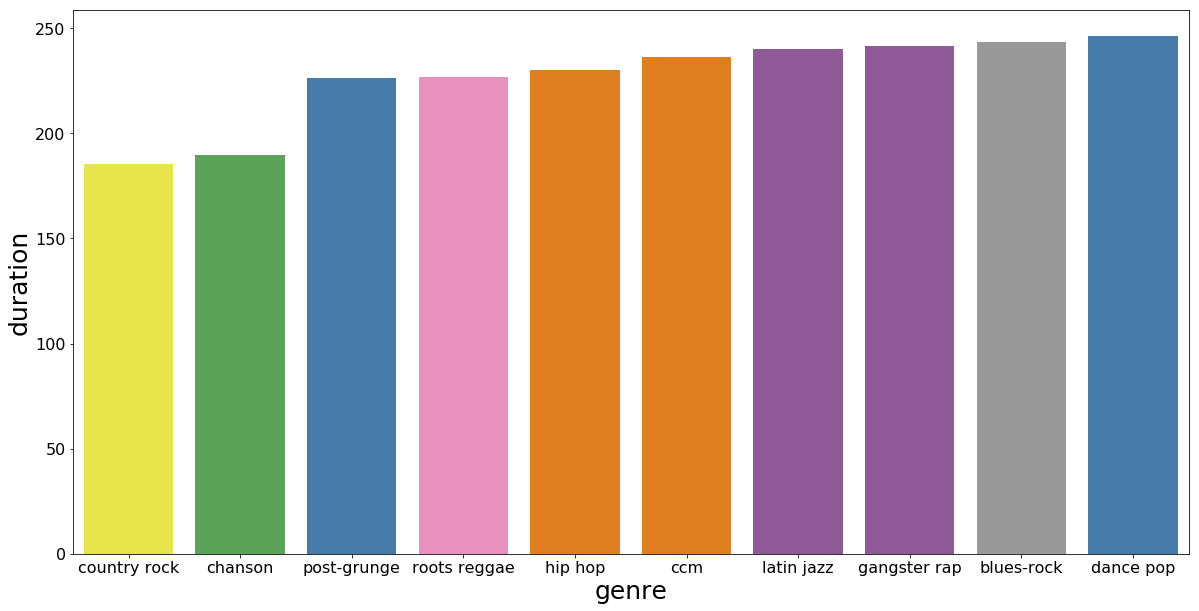

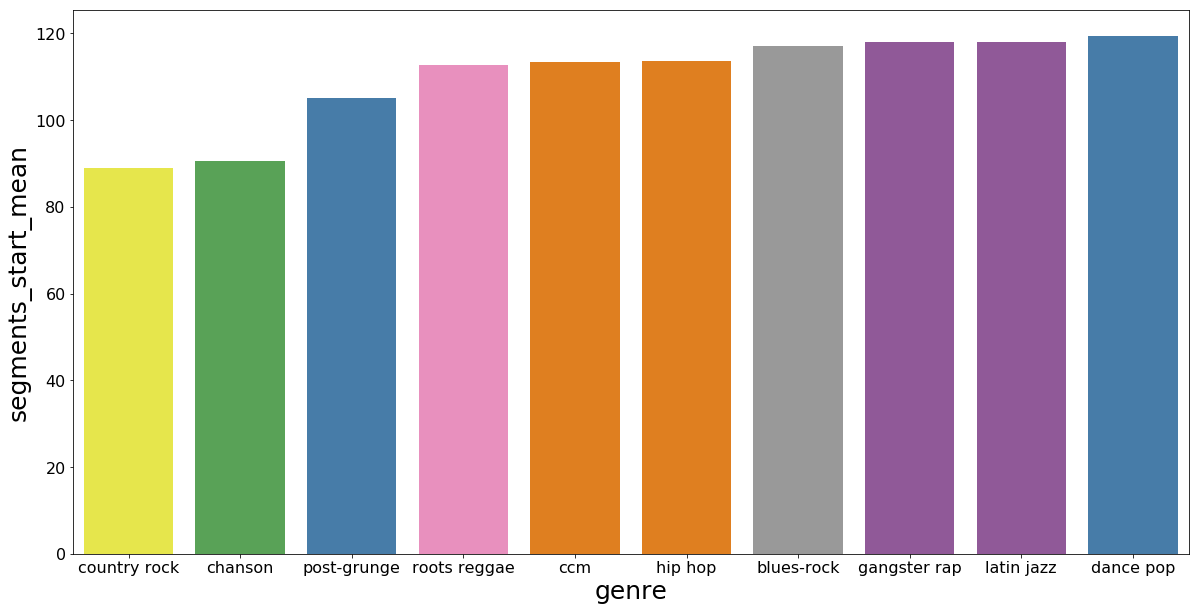

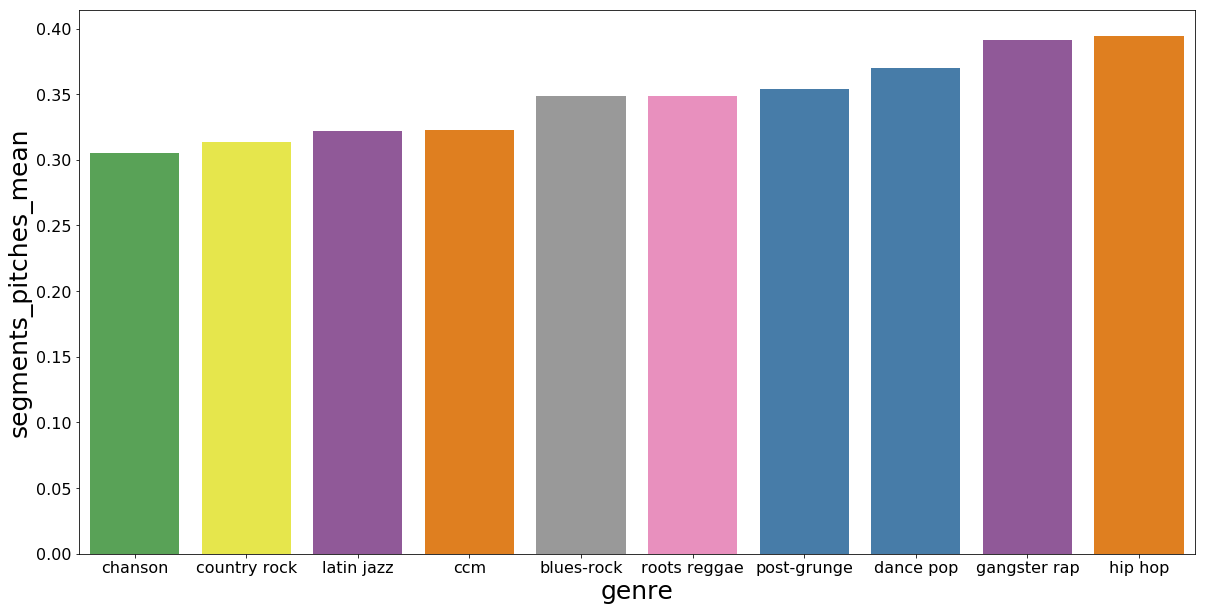

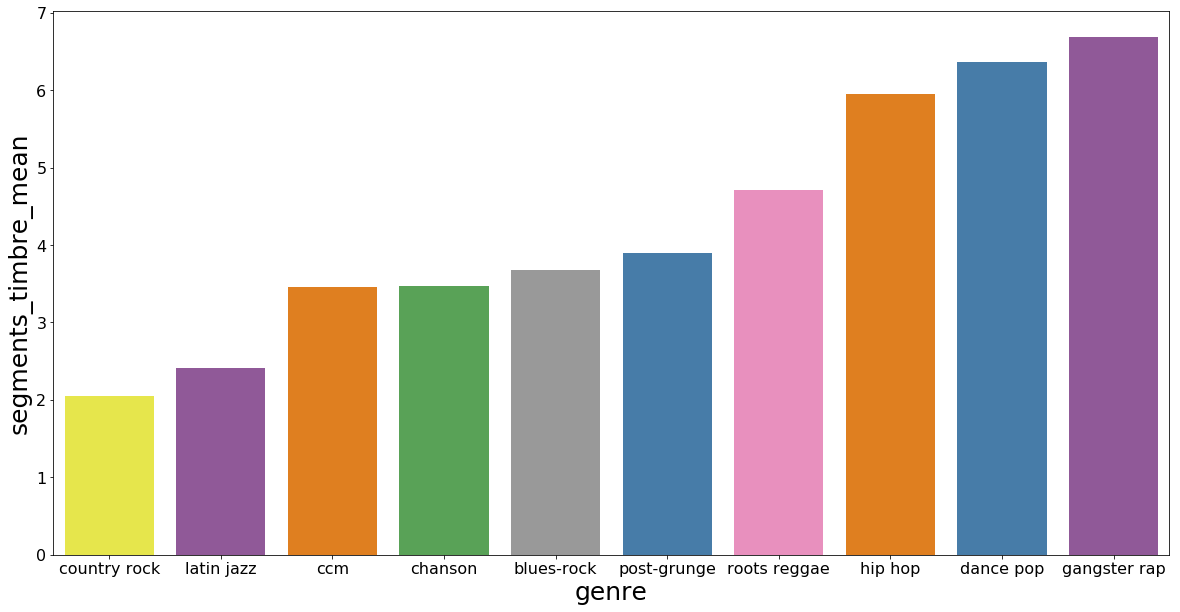

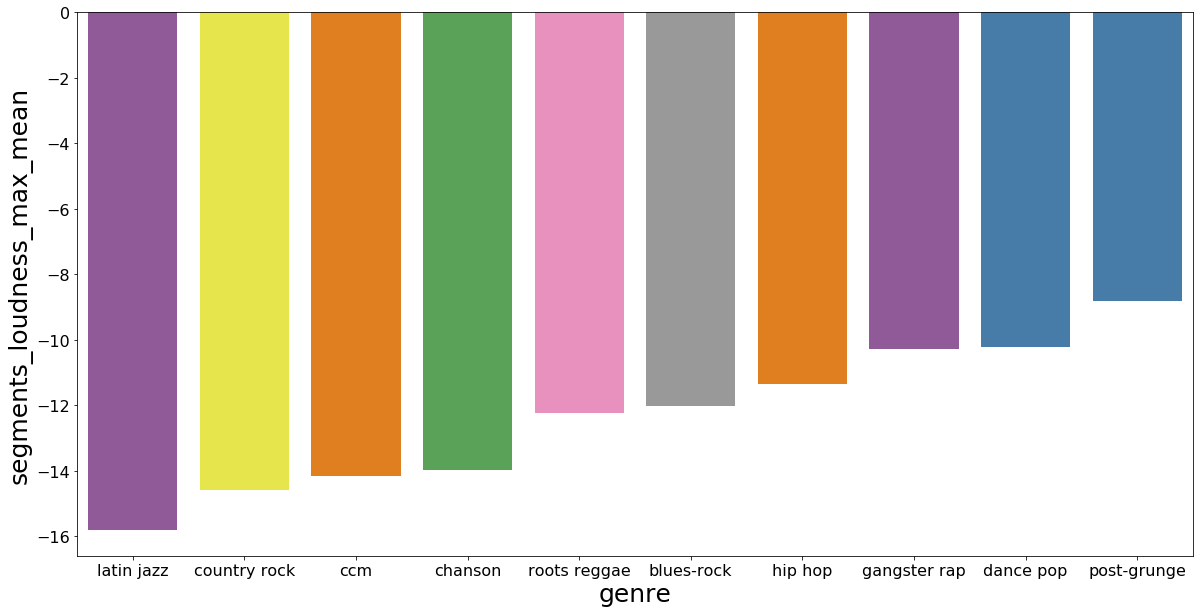

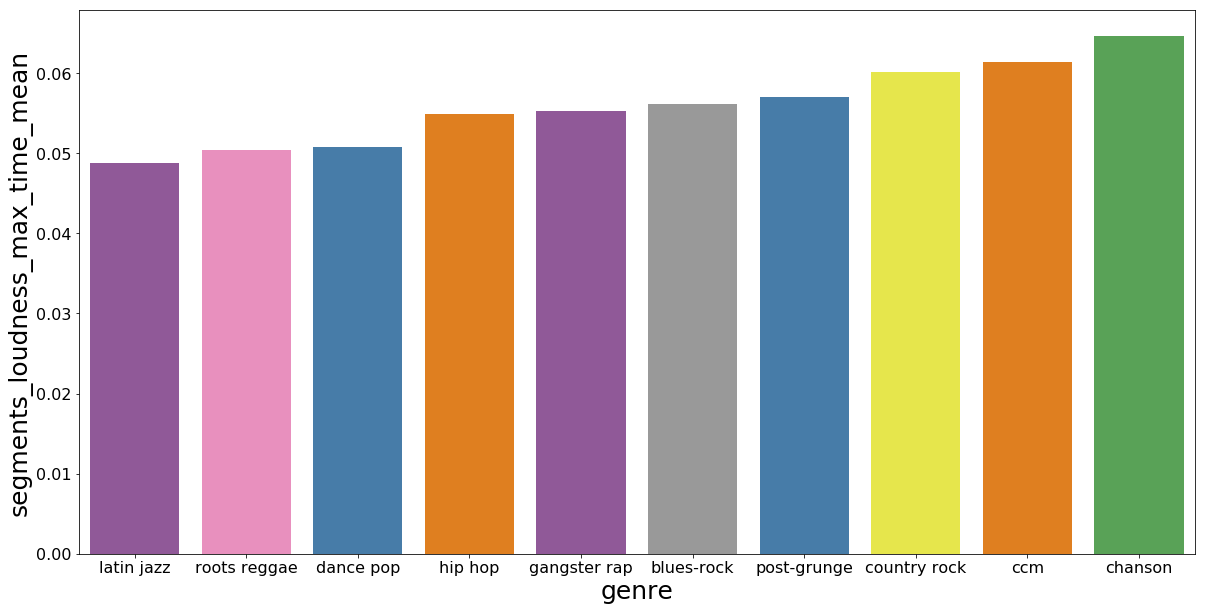

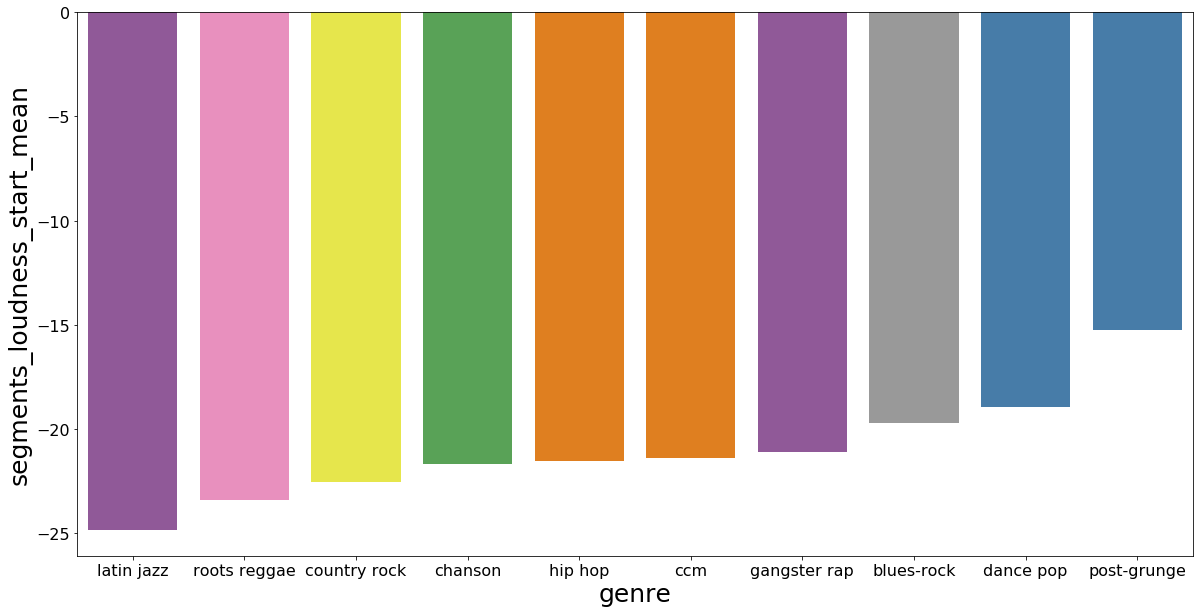

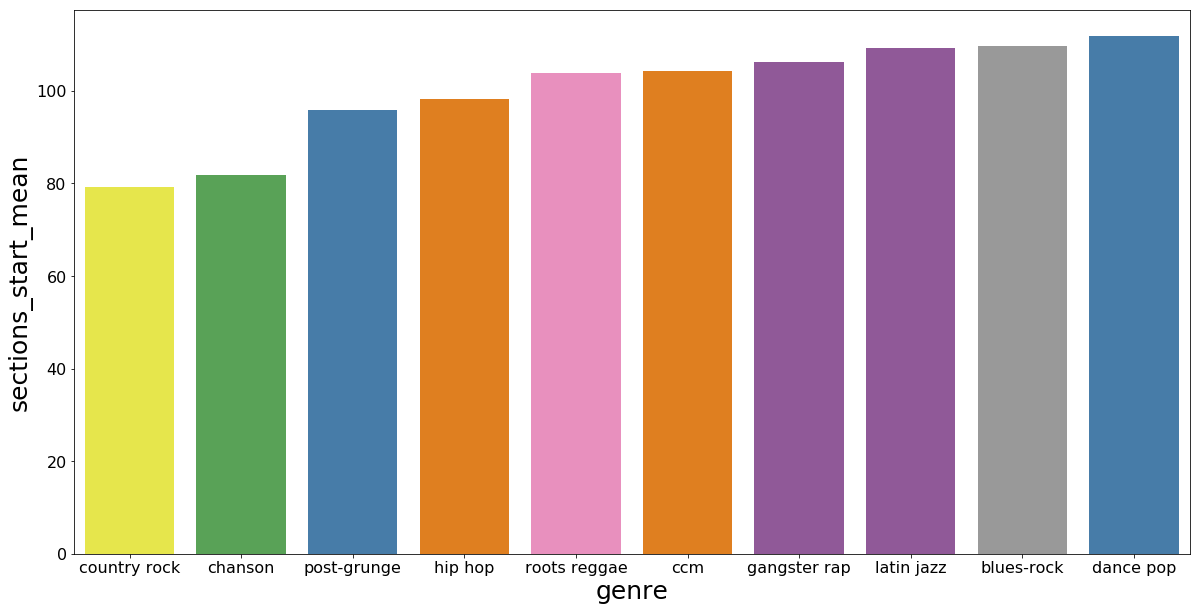

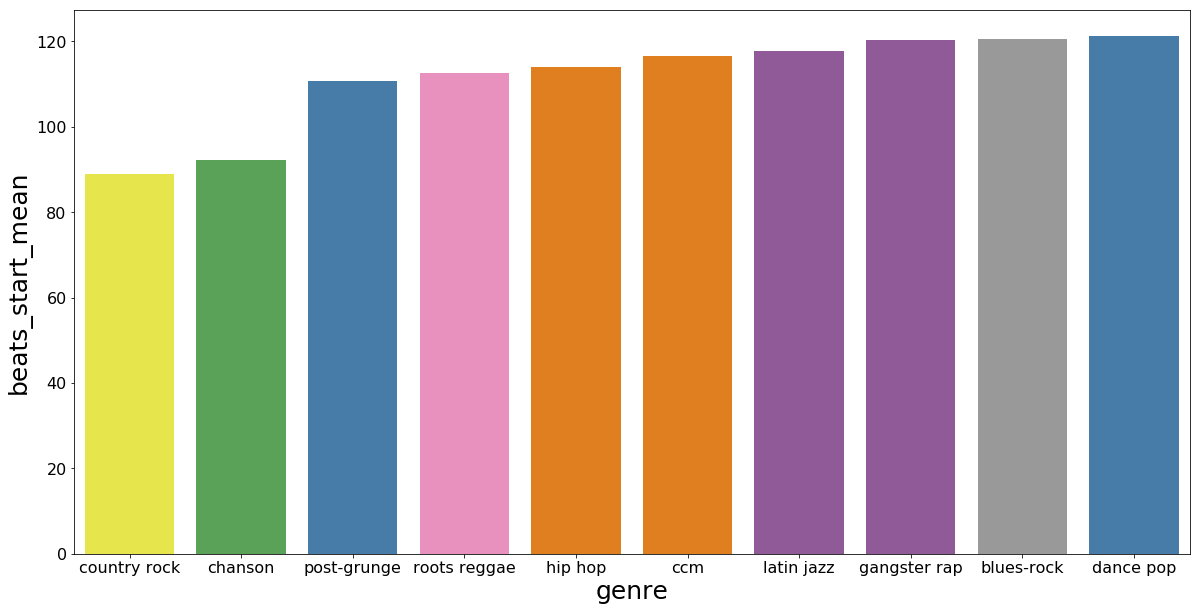

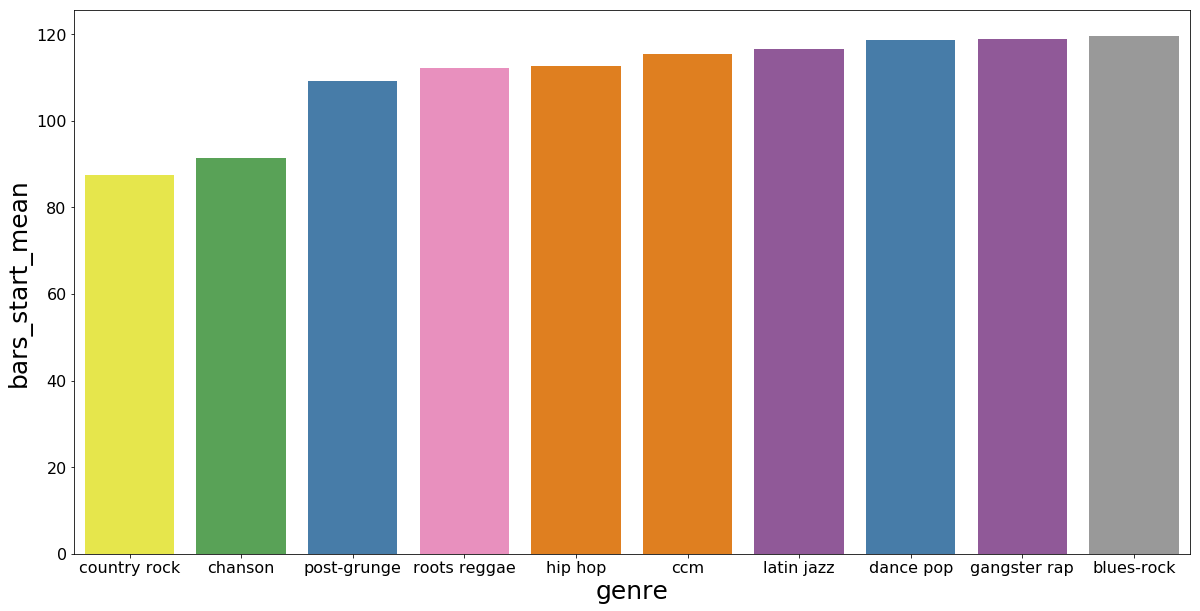

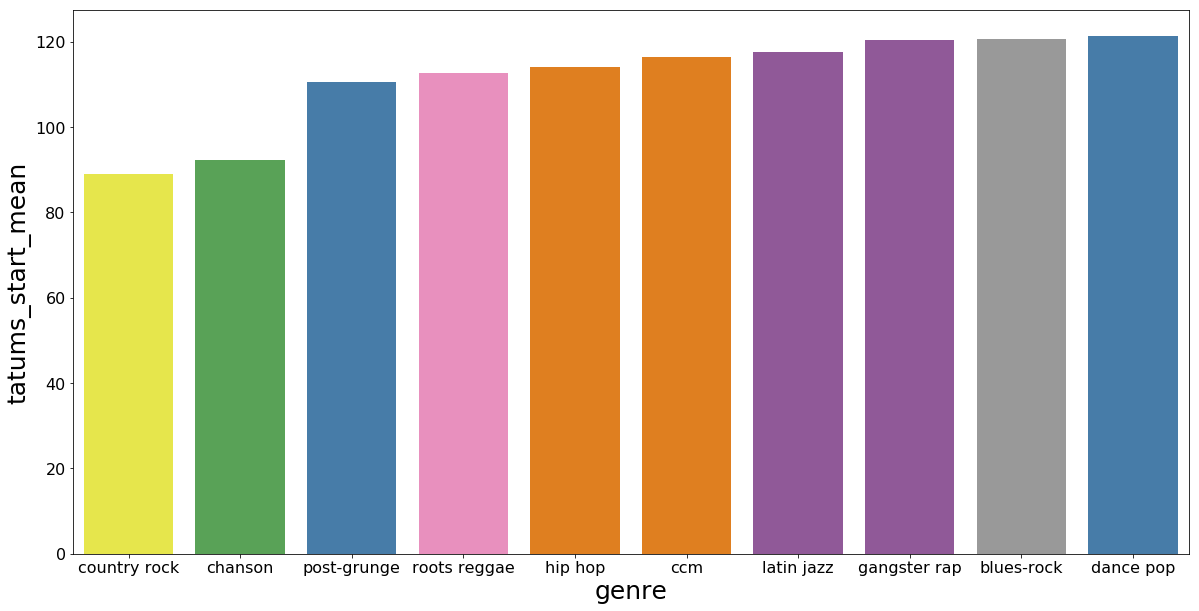

In [21]:
#alternative view of audio features, by genre, as bar charts sorted
features = list(audio.columns)
features.remove('genre')
features.remove('genre_label')
features.remove('index')
#print(features)

for feat in features:
    result_new = audio.groupby(["genre"])[feat].aggregate(np.median).reset_index().sort_values(feat)
    pal = dict(zip(audio.genre, sns.color_palette("Set1", n_colors=len(audio.genre))))
    plt.rcParams["axes.labelsize"] = 25
    fig, ax = plt.subplots(figsize=(20,10))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    sns.barplot(data=result_new, x='genre', y=feat, palette=pal);

In [22]:
#find keys of songs.  0=C, 1=C#, etc all the way through 11=B
audio['key'].value_counts().sort_values(ascending=False)

7.0     278
2.0     232
9.0     220
0.0     211
1.0     207
5.0     156
4.0     151
11.0    146
10.0    132
6.0     126
8.0     101
3.0      53
Name: key, dtype: int64

In [23]:
#key signatures in audio df
#the dataset overall has 68.6% of the songs in a major key, and the keys of G, A, C, D are the most popular keys
song_mode_counts = audio.mode_orig.value_counts()

df_c = audio[audio.key == 0]
df_d = audio[audio.key == 2]
df_g = audio[audio.key == 7]
df_a = audio[audio.key == 9]
percent_major_df = song_mode_counts[1] / audio.shape[0] * 100.0
song_mode_counts_g = df_g['mode_orig'].value_counts()
percent_major_g = song_mode_counts_g[1] / len(df_g) * 100.0
song_mode_counts_a = df_a['mode_orig'].value_counts()
percent_major_a = song_mode_counts_a[1] / len(df_a) * 100.0
song_mode_counts_c = df_c['mode_orig'].value_counts()
percent_major_c = song_mode_counts_c[1] / len(df_c) * 100.0
song_mode_counts_d = df_d['mode_orig'].value_counts()
percent_major_d = song_mode_counts_d[1] / len(df_d) * 100.0
print ("Percent Major\t\tKey")
print ("{}\t\t\tdataset\n{}\tG\n{}\tA\n{}\tC\n{}\tD".format(percent_major_df,percent_major_g,percent_major_a,percent_major_c,percent_major_d))

Percent Major		Key
68.65375062096373			dataset
86.6906474820144	G
64.0909090909091	A
83.41232227488152	C
80.60344827586206	D


68.65375062096373% of songs are Major


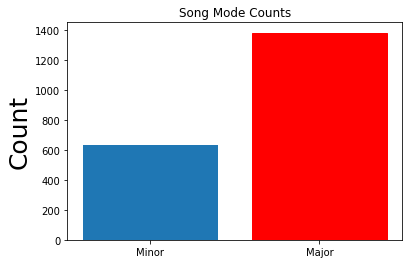

In [24]:
# song_mode bar chart-alternative view
song_mode_counts = audio.mode_orig.value_counts()
fig_song_mode_counts, ax_song_mode_counts = plt.subplots()
song_mode_bars = ax_song_mode_counts.bar(song_mode_counts.index, song_mode_counts);
ax_song_mode_counts.set_xticks(song_mode_counts.index)
ax_song_mode_counts.set_xticklabels(['Major', 'Minor']);
ax_song_mode_counts.set_title('Song Mode Counts');
ax_song_mode_counts.set_ylabel('Count');
song_mode_bars[0].set_color('r');
percent_major = song_mode_counts[1] / audio.shape[0] * 100
print ("{}% of songs are Major".format(percent_major))

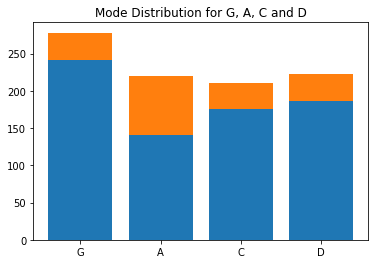

In [25]:
#this plot shows if a key (G, A, C, D) is in a major (blue) or minor (orange) key
g_mode_counts = df_g.mode_orig.value_counts()
a_mode_counts = df_a.mode_orig.value_counts()
c_mode_counts = df_c.mode_orig.value_counts()
d_mode_counts = df_d.mode_orig.value_counts()
major = [g_mode_counts[1], a_mode_counts[1], c_mode_counts[1], d_mode_counts[1]]
minor = [g_mode_counts[0], a_mode_counts[0], c_mode_counts[0], c_mode_counts[0]]
g_c_d_a_mode_index = range(len(major))
# plot the stacked bar charts
fig_g_c_d_a_mode, ax_g_c_d_a_mode = plt.subplots()
ax_g_c_d_a_mode.bar(g_c_d_a_mode_index, major);
ax_g_c_d_a_mode.bar(g_c_d_a_mode_index, minor, bottom = major);
ax_g_c_d_a_mode.set_title("Mode Distribution for G, A, C and D")
ax_g_c_d_a_mode.set_xticks(g_c_d_a_mode_index)
ax_g_c_d_a_mode.set_xticklabels(["G","A","C","D"]);

In [26]:
#change key values from a number to actual key that is understandable 
key_dict={0.0:"C",1.0:"C#",2.0:"D",3.0:"Eb",4.0:"E",5.0:"F",6.0:"F#",7.0:"G",8.0:"Ab",9.0:"A",10.0:"Bb",11.0:"B"}
audio['key_values']=audio['key'].copy()
audio['key_values']=audio['key_values'].map(key_dict)

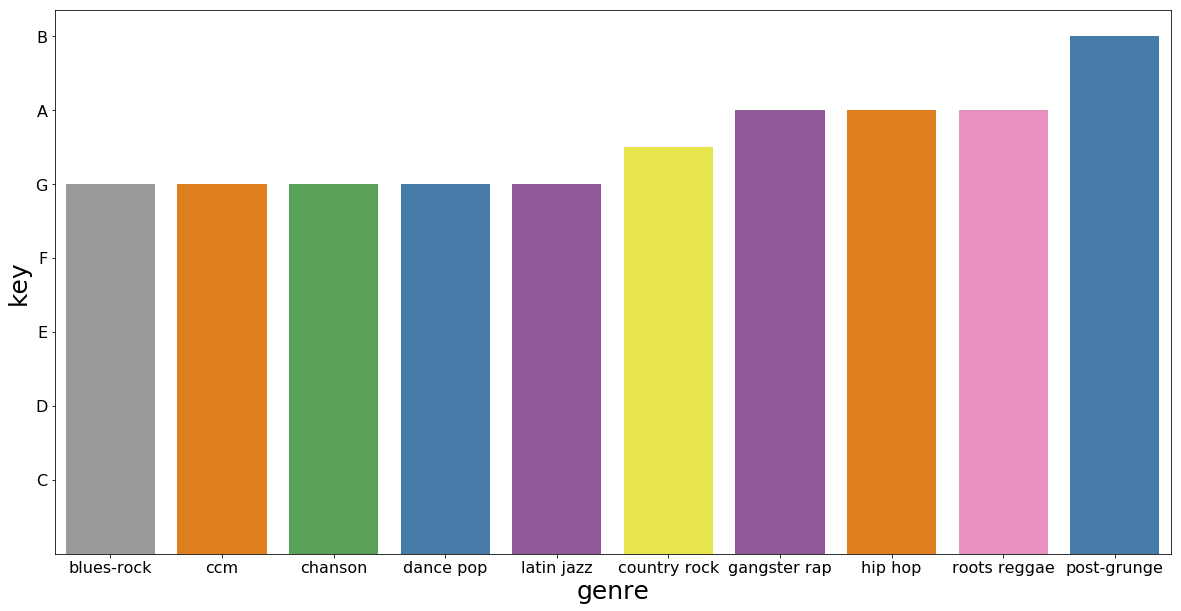

In [27]:
#plot genres by key
x=audio['genre']
y=[1,2,3,4,5,6,7]
labels=["C","D","E","F","G","A","B"]

result_new = audio.groupby(["genre"])['key'].aggregate(np.median).reset_index().sort_values('key')
pal = dict(zip(audio.genre, sns.color_palette("Set1", n_colors=len(audio.genre))))
plt.rcParams["axes.labelsize"] = 25
fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
sns.barplot(data=result_new, x='genre', y='key', palette=pal)
plt.yticks(y, labels);

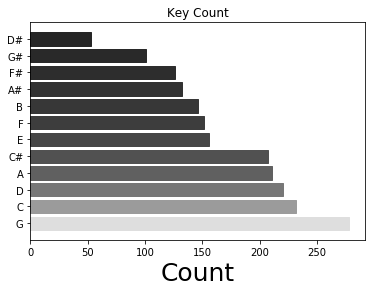

In [28]:
# key sorted horizontal bar chart 

key_counts = audio.key.value_counts()
df_key_counts = pd.DataFrame(key_counts)
df_key_counts.reset_index(inplace = True)
# ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
fig_key_counts, ax_key_counts = plt.subplots()
bars = ax_key_counts.barh(df_key_counts.index, df_key_counts.key)
ax_key_counts.set_yticks(df_key_counts.index)
ax_key_counts.set_yticklabels(['G','C','D','A','C#','E','F','B','A#','F#','G#','D#']);
ax_key_counts.set_title('Key Count');
ax_key_counts.set_xlabel('Count');
for x,bar in zip(range(len(bars)),bars):
    bar.set_color(str(2.0/(x+2.3)))

## Audio feature analysis for top 2 artists in dataset for comparative sake

In [29]:
#create separate df to just look at artist stats
music_df=music[['artist_name','genre','genre_label','start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
                'mode', 'mode_orig','tatums','loudness','duration']]

In [30]:
#find the artists with the most songs in original 10k list
mdf=music_df[['artist_name','genre']]
mdf.genre.value_counts()

blues-rock              346
hip hop                 346
ccm                     255
chanson                 208
country rock            156
latin jazz              150
post-grunge             146
dance pop               141
gangster rap            134
roots reggae            131
pop rock                130
progressive house       119
heavy metal              97
dancehall                97
power pop                94
rock                     92
chill-out                90
salsa                    82
jazz funk                80
hardcore punk            79
lovers rock              76
country gospel           75
honky tonk               73
post-hardcore            72
irish folk               70
folk-pop                 69
alternative metal        67
dance rock               67
tech house               65
soundtrack               65
                       ... 
synth punk                1
highlife                  1
riot grrrl                1
funeral doom              1
slow core           

In [31]:
#systematically program to find top 5 artists by number of songs in dataset
mdfan=music_df['artist_name'].value_counts()[:5]
mdfan=mdfan.index
mdfan=[i for i in mdfan]
mdfan

['Mario Rosenstock',
 'The Jackson Southernaires',
 'Sugar Minott',
 'Phil Collins',
 'Aerosmith']

In [158]:
#choosing Aerosmith because there are other artists in their genre.  Mario Rosenstock is the only artist in the 
#irish genre so unable to compare against self
print('Artist : ',mdfan[4])
df_top_1 = music_df[music_df.artist_name == mdfan[4]]
#df_top_1.describe()
df_top_1.describe()

Artist :  Aerosmith


genre_label  start_of_fade_out       tempo  time_signature       bars  \
count         12.0          12.000000   12.000000       12.000000  12.000000   
mean          35.0         302.118833  121.134083        2.916667  40.031924   
std            0.0          53.128321   44.119575        1.240112  24.925559   
min           35.0         211.540000   70.876000        1.000000  11.812457   
25%           35.0         283.541750   99.850750        2.500000  20.269216   
50%           35.0         301.072500  107.233000        3.000000  30.197032   
75%           35.0         326.889500  137.286500        4.000000  54.283539   
max           35.0         409.681000  232.709000        4.000000  83.485829   

           beats        key       mode  mode_orig     tatums   loudness  \
count  12.000000  12.000000  12.000000  12.000000  12.000000  12.000000   
mean   57.195749   5.583333   0.277417   0.750000  31.928744  -7.249083   
std    24.842911   3.203928   0.408544   0.452267  16.511786   3.190639   
min     9.373677   0.000000  -0.417000   0.000000   9.373677 -12.328000   
25%    43.921561   4.250000   0.076500   0.750000  19.469682 -10.739750   
50%    56.063448   5.500000   0.396000   1.000000  31.146692  -5.754500   
75%    72.219132   7.500000   0.543750   1.000000  39.613778  -4.722500   
max    99.462830  11.000000   0.832000   1.000000  59.212914  -3.947000   

         duration  
count   12.000000  
mean   312.319546  
std     54.810363  
min    217.233830  
25%    295.490155  
50%    319.176690  
75%    331.101590  
max    425.037910

In [159]:
#display genre for top artist
df_top_1['genre']

1535    blues-rock
1563    blues-rock
1684    blues-rock
4747    blues-rock
5293    blues-rock
5691    blues-rock
5745    blues-rock
6198    blues-rock
6932    blues-rock
8022    blues-rock
8045    blues-rock
8364    blues-rock
Name: genre, dtype: object

In [160]:
music_df[music_df['genre']== "blues-rock"].describe()

genre_label  start_of_fade_out       tempo  time_signature        bars  \
count        346.0         346.000000  346.000000      346.000000  346.000000   
mean          35.0         251.924118  121.355662        3.329480   24.648865   
std            0.0         111.060553   30.700514        1.362478   20.394657   
min           35.0          10.658000   41.945000        1.000000    0.243889   
25%           35.0         192.938750   97.391000        3.000000   11.977318   
50%           35.0         234.991500  117.983500        4.000000   17.956669   
75%           35.0         294.179250  140.207750        4.000000   28.808617   
max           35.0        1017.353000  232.709000        7.000000  122.319448   

            beats         key        mode   mode_orig      tatums    loudness  \
count  346.000000  346.000000  346.000000  346.000000  346.000000  346.000000   
mean    52.447973    5.306358    0.234084    0.722543   36.489643   -9.716618   
std     28.327926    3.382618    0.452973    0.448392   22.022055    3.646940   
min      0.000000    0.000000   -0.932000    0.000000    0.783212  -27.749000   
25%     31.975432    2.000000   -0.200000    0.000000   21.054762  -12.321500   
50%     48.410621    5.000000    0.408500    1.000000   31.091576   -9.199500   
75%     68.016900    8.000000    0.583000    1.000000   46.942566   -6.930000   
max    198.372675   11.000000    1.000000    1.000000  130.490474   -3.201000   

          duration  
count   346.000000  
mean    260.704305  
std     111.581987  
min      10.657510  
25%     201.658325  
50%     243.486895  
75%     305.873833  
max    1023.868930

## Looking at the feature values for artist Aerosmith, this is how he compares to the average values for the genre "Blues Rock":

| Feature |  Aerosmith  | Blues Rock Genre|
|---------|:-----------:|:---------------:|            
|Fade Out |   302.12    |  251.35         |
|Tempo    |   121.13    |  121.35         |
|Bars     |    40.03    |   24.64         |
|Beats    |    57.19    |   52.44         |
|Key      |     5.58    |    5.30         | 
|Mode     |     0.75    |    0.23         |
|Tatums   |    31.93    |   36.49         |
|Loudness |    -7.24    |   -9.71         | 
|Duration |   312.31    |  260.70         |

### There are many close similarities, but some differences, such as the number of bars.  Aerosmith has almost twice as many in there songs as the average artist in Blues Rock.  This also coincides with when the Fade Out starts since they have longer songs

In [161]:
#repeat for another artist in top 5
print('Artist : ',mdfan[2])
df_top_alt = music_df[music_df.artist_name == mdfan[2]]
df_top_alt.describe()

Artist :  Sugar Minott


genre_label  start_of_fade_out       tempo  time_signature       bars  \
count         12.0          12.000000   12.000000       12.000000  12.000000   
mean         365.0         214.100583  155.974833        3.500000  18.332811   
std            0.0          37.251099   12.207230        1.167748  10.704465   
min          365.0         177.627000  121.284000        1.000000   9.338680   
25%          365.0         186.466500  154.166250        4.000000  12.764748   
50%          365.0         200.371000  158.883000        4.000000  13.985604   
75%          365.0         224.573500  162.252750        4.000000  19.805802   
max          365.0         284.032000  167.947000        4.000000  46.060914   

            beats        key       mode  mode_orig     tatums   loudness  \
count   12.000000  12.000000  12.000000  12.000000  12.000000  12.000000   
mean    60.379970   4.916667   0.180167   0.750000  60.235761  -9.750667   
std     23.564287   4.378840   0.428958   0.452267  21.684385   2.790789   
min     20.617609   0.000000  -0.804000   0.000000  35.345337 -13.688000   
25%     45.444868   1.000000   0.035500   0.750000  40.520710 -11.952500   
50%     62.437502   5.000000   0.357000   1.000000  59.362830  -9.865500   
75%     77.339926   7.750000   0.468250   1.000000  69.665761  -7.482000   
max    101.609097  11.000000   0.624000   1.000000  99.937182  -5.627000   

         duration  
count   12.000000  
mean   222.281995  
std     36.538673  
min    185.991380  
25%    193.488528  
50%    209.488525  
75%    234.304852  
max    290.350570

In [162]:
#display genre 
df_top_alt['genre']

756     roots reggae
1021    roots reggae
1777    roots reggae
3715    roots reggae
3765    roots reggae
4583    roots reggae
4695    roots reggae
4721    roots reggae
5021    roots reggae
5832    roots reggae
6536    roots reggae
7035    roots reggae
Name: genre, dtype: object

In [163]:
music_df[music_df['genre']== "roots reggae"].describe()

genre_label  start_of_fade_out       tempo  time_signature        bars  \
count        131.0         131.000000  131.000000      131.000000  131.000000   
mean         365.0         237.712511  136.380969        3.557252   20.133933   
std            0.0         128.868363   30.778790        1.151322   21.375455   
min          365.0          53.545000   67.606000        1.000000    0.000000   
25%          365.0         197.584500  118.138000        4.000000    9.809059   
50%          365.0         218.506000  143.973000        4.000000   13.240741   
75%          365.0         246.430500  159.236000        4.000000   19.868366   
max          365.0        1506.412000  241.877000        7.000000  168.148483   

            beats         key        mode   mode_orig      tatums    loudness  \
count  131.000000  131.000000  131.000000  131.000000  131.000000  131.000000   
mean    68.600546    5.435115    0.063351    0.587786   66.418459  -10.165176   
std     29.733792    3.719179    0.470500    0.494123   30.804427    4.112711   
min      0.000000    0.000000   -1.000000    0.000000    7.141548  -27.815000   
25%     48.335892    1.000000   -0.409500    0.000000   44.203593  -12.727500   
50%     68.365139    6.000000    0.219000    1.000000   62.676649   -9.237000   
75%     83.859000    9.000000    0.483000    1.000000   89.739736   -7.268500   
max    172.264930   11.000000    0.807000    1.000000  190.648548   -3.362000   

          duration  
count   131.000000  
mean    247.421214  
std     129.277814  
min      56.842000  
25%     206.144850  
50%     226.690160  
75%     257.397100  
max    1519.281180

## Looking at the feature values for artist Sugar Minott, this is how he compares to the average values for the genre "Roots Reggae":

| Feature |   Sugar Minott |  Roots Reggae Genre|
|---------|:--------------:|:------------------:|
|Fade Out |   214.10       |  237.71            |
|Tempo    |   155.97       |  136.38            |
|Bars     |    18.33       |   20.13            |
|Beats    |    60.37       |   68.66            |
|Key      |     4.91       |    5.43            |      
|Mode     |     0.75       |    0.58            |
|Tatums   |    60.23       |   66.42            |
|Loudness |    -9.75       |  -10.16            |
|Duration |   222.28       |  247.42            |

## Again, there are many close similarities, but some differences.  Sugar Minott's songs tend to be a bit quicker in tempo, shorter in length and overall more mellow than the rest of the artists in Roots Reggae

In [38]:
#correlation of audio features
audio.corr()

index  genre_label  start_of_fade_out  \
index                            1.000000    -0.030139           0.025318   
genre_label                     -0.030139     1.000000          -0.005418   
start_of_fade_out                0.025318    -0.005418           1.000000   
tempo                            0.014059     0.110481           0.031691   
time_signature                  -0.018464     0.053107           0.074758   
bars                             0.014420    -0.029631           0.400432   
beats                            0.008835     0.094997           0.556862   
key                              0.012296     0.030237          -0.004772   
mode                            -0.004444    -0.107954          -0.047685   
mode_orig                       -0.016696    -0.083403          -0.048621   
tatums                           0.008846     0.201196           0.460237   
loudness                         0.017462     0.087689           0.128779   
duration                         0.022677    -0.006575           0.998180   
segments_start_mean              0.024776     0.004471           0.992617   
segments_pitches_mean            0.030346     0.164129           0.057978   
segments_timbre_mean            -0.015550     0.096221           0.015099   
segments_loudness_max_mean       0.024402     0.076767           0.110865   
segments_loudness_max_time_mean  0.004798    -0.148559          -0.157234   
segments_loudness_start_mean     0.026361    -0.059607           0.125988   
sections_start_mean              0.018715     0.006326           0.960868   
beats_start_mean                 0.022948    -0.004785           0.994371   
bars_start_mean                  0.024094    -0.004186           0.994003   
tatums_start_mean                0.022960    -0.004778           0.994380   

                                    tempo  time_signature      bars     beats  \
index                            0.014059       -0.018464  0.014420  0.008835   
genre_label                      0.110481        0.053107 -0.029631  0.094997   
start_of_fade_out                0.031691        0.074758  0.400432  0.556862   
tempo                            1.000000        0.027670  0.057556 -0.061569   
time_signature                   0.027670        1.000000 -0.575951  0.091579   
bars                             0.057556       -0.575951  1.000000  0.289519   
beats                           -0.061569        0.091579  0.289519  1.000000   
key                              0.002675        0.038821 -0.020301  0.016375   
mode                             0.006081       -0.049715  0.011868 -0.065103   
mode_orig                       -0.001516       -0.038530  0.000545 -0.043615   
tatums                           0.007178        0.070008  0.232057  0.751818   
loudness                         0.154932        0.111105  0.019730  0.161076   
duration                         0.031643        0.075864  0.399808  0.560654   
segments_start_mean              0.030856        0.069761  0.396058  0.568241   
segments_pitches_mean            0.126042        0.150444 -0.050701  0.142722   
segments_timbre_mean             0.110548        0.020812  0.006426  0.083905   
segments_loudness_max_mean       0.185183        0.083751  0.034917  0.126874   
segments_loudness_max_time_mean -0.172931       -0.011975 -0.095529 -0.367174   
segments_loudness_start_mean     0.147804        0.070346  0.037513 -0.023897   
sections_start_mean              0.051972        0.079610  0.383216  0.545582   
beats_start_mean                 0.039871        0.078440  0.400727  0.565783   
bars_start_mean                  0.045731        0.067522  0.407493  0.565079   
tatums_start_mean                0.039675        0.078497  0.400642  0.565771   

                                      key      mode  mode_orig  \
index                            0.012296 -0.004444  -0.016696   
genre_label                      0.030237 -0.107954  -0.083403   
start_of_fade_out               -0.004772 -0

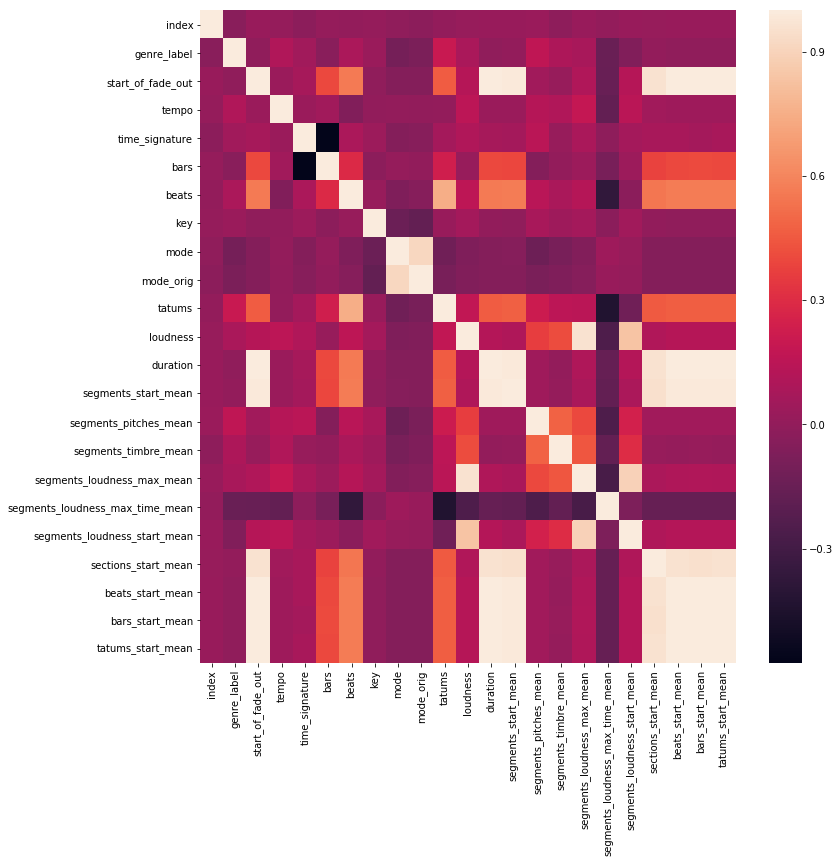

In [39]:
f,ax = plt.subplots(figsize =(12,12))
sns.heatmap(audio.corr());

## Looking at correlations of audio features, when the fade out starts is highly correlated with duration and the number of bars and number of beats.  Several other features that have the word 'start' in them are correlated, which makes sense.  Most features have some correlation, which is understandable since music is structured and many standards exist (SME).  The only highly uncorrelated feature is bars to time signature, which are very independent features for a song.


# Modeling

## Predicting a genre based on audio features only

In [40]:
audio.columns = [col.lower().replace(' ', '_') for col in audio.columns]

In [42]:
#Setting X and y variables


features_all=audio[['start_of_fade_out', 'tempo',
                    'time_signature', 'bars', 'beats', 'key', 'mode', 'mode_orig', 'tatums',
                    'loudness', 'duration', 'segments_start_mean', 'segments_pitches_mean',
                    'segments_timbre_mean', 'segments_loudness_max_mean',
                    'segments_loudness_max_time_mean', 'segments_loudness_start_mean',
                    'sections_start_mean', 'beats_start_mean', 'bars_start_mean',
                    'tatums_start_mean']]


X=features_all

y=audio['genre']

#train test split
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

In [43]:
#Function to evaluate models with cross validation

def testingModel(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring = "roc_auc")
    print("Scores            :", scores)
    print("Mean              :", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

In [44]:
rfc_all=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,3,5],
    'criterion' :['gini', 'entropy']}

gs_all = GridSearchCV(estimator=rfc_all, param_grid=param_grid)
gs_all.fit(X_train, y_train)
gs_all.best_score_
print('GS Train Score : ',gs_all.best_score_)
print('Test Score     : ',gs_all.score(X_test, y_test))
print('Optimal Param  : ',gs_all.best_params_)
acc_rfc_all = (gs_all.best_score_)

GS Train Score :  0.3518886679920477
Test Score     :  0.34325396825396826
Optimal Param  :  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}


In [45]:
rfc_all.fit(X_train, y_train)

# View Feature Importance from Random Forest model
raw_data_all={'RF Imp':rfc_all.feature_importances_}
rfc_all_df=pd.DataFrame(raw_data_all,features_all.columns)
rfc_all_df=rfc_all_df.sort_values('RF Imp', ascending=False) 
rfc_all_df

RF Imp
segments_pitches_mean            0.088517
segments_loudness_start_mean     0.065821
loudness                         0.064784
tatums                           0.062617
tempo                            0.059193
segments_loudness_max_time_mean  0.058323
mode                             0.053554
segments_timbre_mean             0.051452
segments_loudness_max_mean       0.050667
bars                             0.050520
start_of_fade_out                0.047828
beats                            0.047328
bars_start_mean                  0.042115
sections_start_mean              0.040866
duration                         0.039841
segments_start_mean              0.038344
tatums_start_mean                0.037823
beats_start_mean                 0.036191
key                              0.034793
time_signature                   0.019917
mode_orig                        0.009505

In [46]:
ad_all = AdaBoostClassifier()
ad_params_all = {
    'n_estimators'  : [100,200],
    'learning_rate' : [.1, .2, .3]}

gs_ada_all = GridSearchCV(ad_all, 
                  param_grid=ad_params_all,
                  scoring = 'accuracy',
                  cv = 4)

In [47]:
gs_ada_all.fit(X_train, y_train)
print("Print Train Score : " , gs_ada_all.best_score_)
print("Print Test Score  : " , gs_ada_all.score(X_test, y_test))
print("Print Best Params : " , gs_ada_all.best_params_)
acc_ada_all = (gs_ada_all.best_score_)

Print Train Score :  0.3412856196156395
Print Test Score  :  0.32936507936507936
Print Best Params :  {'learning_rate': 0.2, 'n_estimators': 100}


In [48]:
ad_all.fit(X_train, y_train)

# View Feature Importance from ADA Boost model
raw_data_all={'ADA Imp':ad_all.feature_importances_}
ada2_all_df=pd.DataFrame(raw_data_all,features_all.columns)
ada2_all_df=ada2_all_df.sort_values('ADA Imp', ascending=False) 
ada2_all_df

ADA Imp
segments_loudness_max_time_mean     0.12
tempo                               0.12
segments_loudness_start_mean        0.10
tatums                              0.10
loudness                            0.10
segments_pitches_mean               0.10
beats                               0.06
mode                                0.06
duration                            0.04
bars                                0.04
segments_start_mean                 0.04
segments_timbre_mean                0.04
segments_loudness_max_mean          0.02
sections_start_mean                 0.02
start_of_fade_out                   0.02
key                                 0.02
mode_orig                           0.00
time_signature                      0.00
beats_start_mean                    0.00
bars_start_mean                     0.00
tatums_start_mean                   0.00

In [49]:
model_all = XGBClassifier()
model_all_params_all = {
    'n_estimators'  : [100,200],
    'learning_rate' : [.1, .2, .3]}

gs_model_all = GridSearchCV(model_all, 
                  param_grid=model_all_params_all,
                  scoring = 'accuracy',
                  cv = 4)

In [50]:
gs_model_all.fit(X_train, y_train)
print("Print Train Score : " , gs_model_all.best_score_)
print("Print Test Score  : " , gs_model_all.score(X_test, y_test))
print("Print Best Params : " , gs_model_all.best_params_)
acc_model_all = (gs_model_all.best_score_)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

Print Train Score :  0.4022531477799867
Print Test Score  :  0.376984126984127
Print Best Params :  {'learning_rate': 0.1, 'n_estimators': 200}


/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
model_all.fit(X_train, y_train)
# View Feature Importance from XG Boost model
raw_data_all={'XGB Imp':model_all.feature_importances_}
XGB2_all_df=pd.DataFrame(raw_data_all,features_all.columns)
XGB2_all_df=XGB2_all_df.sort_values('XGB Imp', ascending=False) 
XGB2_all_df

XGB Imp
segments_loudness_max_time_mean  0.099444
segments_pitches_mean            0.094678
segments_loudness_start_mean     0.089754
loudness                         0.088324
tempo                            0.080540
mode                             0.076251
segments_timbre_mean             0.074504
tatums                           0.058936
bars                             0.056712
beats                            0.049087
segments_loudness_max_mean       0.042891
segments_start_mean              0.039714
sections_start_mean              0.033360
key                              0.029706
start_of_fade_out                0.024305
duration                         0.017633
time_signature                   0.017474
bars_start_mean                  0.012073
beats_start_mean                 0.011120
tatums_start_mean                0.003495
mode_orig                        0.000000

In [52]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
print("Train Score : ", lr.score(X_train, y_train))
accuracy_lr = lr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_lr))
acc_lr_all = (lr.score(X_train, y_train))

Train Score :  0.41086812458581845
Accuracy: 0.36%


In [53]:
#combine and display model results
results = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest', 'XGB', 'ADA'],
    'Score': [acc_lr_all, acc_rfc_all, acc_model_all, acc_ada_all]})
result_df = results.sort_values(by='Score', ascending=False)
#result_df = result_df.set_index('Score')
result_df.head(10)

Model     Score
0  Logistic Regression  0.410868
2                  XGB  0.402253
1        Random Forest  0.351889
3                  ADA  0.341286

## Tempo, loudness and mode seem to be most important audio features to determine genre classification in the Random Forest, ADA Boost, XGBoost, and Logistic models.  However, the predictive results are low.  I believe it is because there are so many genres being examined at once.  

## Since just using basic audio features proved to be less than optimal, now I am going to add other features besides audio features to see if it affects the predicting of genres

In [65]:
audio_new=music[['genre','genre_label','start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
                 'mode', 'mode_orig','tatums','loudness','duration','segments_start_mean','segments_pitches_mean',
                 'segments_timbre_mean','segments_loudness_max_mean','segments_loudness_max_time_mean',
                 'segments_loudness_start_mean','sections_start_mean','beats_start_mean','bars_start_mean',
                 'tatums_start_mean','location_new','title_new','artist.name_new','decade']]

In [66]:
features_an=audio_new[['start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
                       'mode', 'mode_orig','tatums','loudness','duration','segments_start_mean','segments_pitches_mean',
                       'segments_timbre_mean','segments_loudness_max_mean','segments_loudness_max_time_mean',
                       'segments_loudness_start_mean','sections_start_mean','beats_start_mean','bars_start_mean',
                       'tatums_start_mean', 'location_new','title_new','artist.name_new','decade']]


X=features_an

#audio_new['target']=audio_new.target.astype(int)
y=audio_new['genre']

#Train test split
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

In [67]:
rfc_an=RandomForestClassifier(criterion='gini', max_depth=5,n_estimators=300, max_features='auto',random_state=42)
rfc_an.fit(X_train, y_train)
print("Train Score RF AN: ",rfc_an.score(X_train, y_train))
print("Test Score RF AN : ",rfc_an.score(X_test, y_test))
acc_rfc_an=rfc_an.score(X_train, y_train)

Train Score RF AN:  0.12593383137673425
Test Score RF AN :  0.08843537414965986


In [68]:
# View Feature Importance from Random Forest model
raw_data_rf_an={'RF Imp':rfc_an.feature_importances_}
rfc2_an_df=pd.DataFrame(raw_data_rf_an,features_an.columns)
rfc2_an_df=rfc2_an_df.sort_values('RF Imp', ascending=False) 
rfc2_an_df

RF Imp
segments_loudness_start_mean     0.094689
segments_pitches_mean            0.088294
location_new                     0.082600
tatums                           0.077422
segments_loudness_max_time_mean  0.076301
loudness                         0.064831
segments_loudness_max_mean       0.062913
artist.name_new                  0.057769
segments_start_mean              0.040127
bars_start_mean                  0.036970
duration                         0.036940
beats_start_mean                 0.035550
start_of_fade_out                0.033393
tatums_start_mean                0.032031
segments_timbre_mean             0.029142
decade                           0.027035
beats                            0.024125
tempo                            0.022370
sections_start_mean              0.019973
bars                             0.018224
mode                             0.015756
title_new                        0.014916
time_signature                   0.004139
key                              0.003687
mode_orig                        0.000802

In [69]:
ad_an = AdaBoostClassifier(n_estimators=100,learning_rate=0.2)
ad_an.fit(X_train,y_train)
score_an=ad_an.score(X_train, y_train)
print("Train Score ADA AN: ",score_an)
print("Test Score ADA AN :", ad_an.score(X_test, y_test))
acc_ad_an=ad_an.score(X_train, y_train)

Train Score ADA AN:  0.05816435432230523
Test Score ADA AN : 0.04921968787515006


In [70]:
# View Feature Importance from ADA Boost model
raw_data_an={'ADA Imp':ad_an.feature_importances_}
ada2_an_df=pd.DataFrame(raw_data_an,features_an.columns)
ada2_an_df=ada2_an_df.sort_values('ADA Imp', ascending=False) 
ada2_an_df

ADA Imp
artist.name_new                     0.26
location_new                        0.15
segments_loudness_start_mean        0.12
tatums                              0.10
title_new                           0.07
beats                               0.06
sections_start_mean                 0.06
tempo                               0.06
segments_timbre_mean                0.04
segments_loudness_max_time_mean     0.03
segments_pitches_mean               0.02
segments_loudness_max_mean          0.02
mode                                0.01
tatums_start_mean                   0.00
bars_start_mean                     0.00
beats_start_mean                    0.00
start_of_fade_out                   0.00
segments_start_mean                 0.00
duration                            0.00
loudness                            0.00
mode_orig                           0.00
key                                 0.00
bars                                0.00
time_signature                      0.00
decade                              0.00

In [71]:
model_xg_an = XGBClassifier()
model_xg_an_params_all = {
    'n_estimators'  : [100,200],
    'learning_rate' : [.1, .2, .3]}

gs_model_xg_an = GridSearchCV(model_xg_an, 
                  param_grid=model_xg_an_params_all,
                  scoring = 'accuracy',
                  cv = 4)

In [72]:
gs_model_xg_an.fit(X_train, y_train)
print("Print Train Score : " , gs_model_xg_an.best_score_)
print("Print Test Score  : " , gs_model_xg_an.score(X_test, y_test))
print("Print Best Params : " , gs_model_xg_an.best_params_)
acc_model_xg_an = (gs_model_xg_an.best_score_)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth val

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

Print Train Score :  0.21344717182497333
Print Test Score  :  0.24729891956782712
Print Best Params :  {'learning_rate': 0.1, 'n_estimators': 200}


/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [73]:
model_xg_an = XGBClassifier()
model_xg_an.fit(X_train, y_train)
model_xg_an.predict(X_train)
# make predictions for test data
y_pred_xg_an = model_xg_an.predict(X_test)
accuracy_model_xg_an = model_xg_an.score(X_test, y_test)
train_score_xg_an=model_xg_an.score(X_train, y_train)
print("Accuracy: %.2f%%" % (accuracy_model_xg_an))

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.24%


/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [74]:
# View Feature Importance from XG Boost model
raw_data_xg_an={'XGB Imp':model_xg_an.feature_importances_}
XGB2_xg_an_df=pd.DataFrame(raw_data_xg_an,features_an.columns)
XGB2_xg_andf=XGB2_xg_an_df.sort_values('XGB Imp', ascending=False) 
XGB2_xg_an_df

XGB Imp
start_of_fade_out                0.016112
tempo                            0.057137
time_signature                   0.007617
bars                             0.045063
beats                            0.041006
key                              0.021825
mode                             0.048133
mode_orig                        0.000785
tatums                           0.045718
loudness                         0.040463
duration                         0.012166
segments_start_mean              0.021301
segments_pitches_mean            0.062994
segments_timbre_mean             0.060305
segments_loudness_max_mean       0.035515
segments_loudness_max_time_mean  0.059101
segments_loudness_start_mean     0.052007
sections_start_mean              0.029920
beats_start_mean                 0.005150
bars_start_mean                  0.008972
tatums_start_mean                0.004110
location_new                     0.089557
title_new                        0.055076
artist.name_new                  0.158062
decade                           0.021903

In [75]:
lr_an = LogisticRegression()
lr_an.fit(X_train, y_train)
print("Train Score :", lr_an.score(X_train, y_train))
accuracy_lr_an = lr_an.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_lr_an))
acc_lr_an=lr_an.score(X_train, y_train)

Train Score : 0.153948772678762
Accuracy: 0.08%


In [76]:
#combine and display model results
results = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest', 'XGB', 'ADA'],
    'Score': [acc_lr_an, acc_rfc_an, acc_model_xg_an, acc_ad_an]})
result_df = results.sort_values(by='Score', ascending=False)
#result_df = result_df.set_index('Score')
result_df.head()

Model     Score
2                  XGB  0.213447
0  Logistic Regression  0.153949
1        Random Forest  0.125934
3                  ADA  0.058164

## The scoring somehow has decreased by adding additional features, helping to show that audio features are the best place to start to define a genre (or get better artist based information).  Because of this, the next plan is to sub-select one genre from list of the top 10 genres.  This is due to a more refined sampling and prediction based on audio features.  There are way too many genres in the initial dataset (457) to make any accurate predictions on, with the given data

### Now trying to pick one genre and run models in hopes a more defined search area yields better results:
### Looking at the genre "Hip Hop"

In [77]:
hh=audio.copy()

In [78]:
hh.reset_index(drop=True, inplace=True)

In [79]:
hh.head(10)

index         genre  genre_label  start_of_fade_out    tempo  \
0      0       chanson           68            141.607  124.059   
1      1       chanson           68            241.424   80.084   
2     11       hip hop          214            580.702  146.331   
3     15       hip hop          214            379.478  135.503   
4     28    blues-rock           35            312.041   92.971   
5     31    latin jazz          252            186.410   78.843   
6     34    blues-rock           35            260.725  107.183   
7     38    blues-rock           35            195.587  111.523   
8     40    blues-rock           35            461.714  138.512   
9     43  roots reggae          365            206.391  159.943   

   time_signature       bars      beats  key   mode     ...      \
0             4.0   9.560556  46.020881  0.0  0.556     ...       
1             4.0  21.374251  42.903478  1.0 -0.670     ...       
2             4.0  51.113157  75.911117  0.0  0.587     ...       
3             5.0  22.493910  54.521671  1.0  0.155     ...       
4             4.0  21.228022  14.614580  3.0 -0.573     ...       
5             7.0   5.842103  23.004907  7.0  0.416     ...       
6             1.0  91.167323  91.167323  0.0  0.660     ...       
7             1.0  48.531004  48.531004  3.0  0.094     ...       
8             4.0  31.975025  89.806909  1.0 -0.711     ...       
9             4.0   9.924940  71.526352  1.0  0.167     ...       

   segments_pitches_mean  segments_timbre_mean  segments_loudness_max_mean  \
0               0.299886              2.050151                  -12.216512   
1               0.233556              5.169785                  -16.459136   
2               0.343717              3.375428                   -6.809419   
3               0.485925             15.489554                  -10.167091   
4               0.348786              2.510657                   -5.468947   
5               0.317965             12.403654                   -7.622960   
6               0.304079              5.052139                  -10.937534   
7               0.292447              7.661419                  -12.313801   
8               0.316269              0.407918                  -13.002798   
9               0.321193              1.286391                  -10.390579   

   segments_loudness_max_time_mean  segments_loudness_start_mean  \
0                         0.052350                    -19.229238   
1                         0.086557                    -21.786326   
2                         0.107121                    -11.015026   
3                         0.042906                    -23.002772   
4                         0.073483                    -10.656824   
5                         0.048740                    -21.197200   
6                         0.054830                    -22.393121   
7                         0.057571                    -24.811441   
8                         0.050493                    -20.709356   
9                         0.052812                    -19.726880   

   sections_start_mean  beats_start_mean  bars_start_mean  tatums_start_mean  \
0            57.679828         71.025470        70.298204          71.025247   
1           119.968496        123.794350       130.630938         123.792848   
2           296.464534        289.450339       289.029750         289.346392   
3           187.673563        196.156957       195.271196         196.083124   
4           143.844608        159.276476       156.730738         159.436523   
5            85.046258         94.058322        90.246028          94.287176   
6           118.236165        140.374237       140.374237         140.374228   
7           110.511598        104.038474       104.038474         103.901682   
8           214.400463        229.943618       229.075837         229.943928   
9            84.228634        107.510459       106.760205         107.604269   

   key_values  
0           C  
1     

In [80]:
hh.shape

(2013, 25)

In [81]:
#create a new column that will be the target variable to predict on
hh['target']="0"

In [82]:
#a function that creates a target variable of 1 for the hip hop genre 
a=0
for i in range((hh.shape[0])):
    x=(hh.iloc[:,1][i])  #this is the column genre resides in
    a = 0
    if x =='hip hop':
        a = 1
    if x != 'hip hop':
        a = 0
        
    hh['target'][i] = a

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [182]:
#create X, y variables

features_hh=hh[['start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
                'mode', 'mode_orig','tatums','loudness','duration','segments_start_mean','segments_pitches_mean',
                'segments_timbre_mean','segments_loudness_max_mean','segments_loudness_max_time_mean',
                'segments_loudness_start_mean','sections_start_mean','beats_start_mean','bars_start_mean',
                'tatums_start_mean']]
X=features_hh

hh['target']=hh.target.astype(int)
y=hh['target']

#train test split
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

In [84]:
hh.target.value_counts()

0    1667
1     346
Name: target, dtype: int64

In [85]:
rfc_hh=RandomForestClassifier(criterion='gini', max_depth=5,n_estimators=300, max_features='auto',random_state=42)
rfc_hh.fit(X_train, y_train)
accuracy_rfc_hh = rfc_hh.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_rfc_hh))
acc_rfc_hh = testingModel(rfc_hh, X_train, y_train)

Accuracy: 0.82%
Scores            : [0.83913309 0.86050061 0.81046154 0.82923077 0.77076923 0.80738462
 0.83846154 0.74176    0.81216    0.82688   ]
Mean              : 0.813674139194139
Standard Deviation: 0.0330701395837276


In [86]:
# View Feature Importance from Random Forest model
raw_data_hh={'RF Imp':rfc_hh.feature_importances_}
rfc2_hh_df=pd.DataFrame(raw_data_hh,features_hh.columns)
rfc2_hh_df=rfc2_hh_df.sort_values('RF Imp', ascending=False) 
rfc2_hh_df

RF Imp
segments_pitches_mean            0.239301
segments_timbre_mean             0.088916
tempo                            0.075647
loudness                         0.075485
segments_loudness_start_mean     0.071718
segments_loudness_max_mean       0.053739
tatums                           0.049816
mode                             0.042163
segments_loudness_max_time_mean  0.040428
beats                            0.030619
key                              0.029624
start_of_fade_out                0.028334
duration                         0.025455
sections_start_mean              0.022823
bars                             0.022520
bars_start_mean                  0.022499
segments_start_mean              0.022167
beats_start_mean                 0.020561
tatums_start_mean                0.020222
time_signature                   0.015225
mode_orig                        0.002740

In [87]:
ad_hh = AdaBoostClassifier(n_estimators=100,learning_rate=0.2)
ad_hh.fit(X_train,y_train)
score_hh=ad_hh.score(X_train, y_train)
accuracy_ad_hh = ad_hh.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_ad_hh))
acc_ad_hh = testingModel(ad_hh, X_train, y_train)

Accuracy: 0.83%
Scores            : [0.86691087 0.88263126 0.78553846 0.85923077 0.79446154 0.80923077
 0.81723077 0.7984     0.784      0.86496   ]
Mean              : 0.8262594432234434
Standard Deviation: 0.03608042134990468


In [88]:
# View Feature Importance from ADA Boost model
raw_data_hh={'ADA Imp':ad_hh.feature_importances_}
ada2_hh_df=pd.DataFrame(raw_data_hh,features_hh.columns)
ada2_hh_df=ada2_hh_df.sort_values('ADA Imp', ascending=False) 
ada2_hh_df

ADA Imp
segments_loudness_start_mean        0.24
loudness                            0.18
segments_pitches_mean               0.14
tempo                               0.09
key                                 0.08
segments_loudness_max_time_mean     0.08
segments_timbre_mean                0.07
mode                                0.04
beats                               0.02
tatums                              0.02
duration                            0.01
bars_start_mean                     0.01
bars                                0.01
segments_start_mean                 0.01
beats_start_mean                    0.00
sections_start_mean                 0.00
start_of_fade_out                   0.00
segments_loudness_max_mean          0.00
mode_orig                           0.00
time_signature                      0.00
tatums_start_mean                   0.00

In [89]:
model_hh = XGBClassifier()
model_hh.fit(X_train, y_train)
model_hh.predict(X_train)
# make predictions for test data
y_pred_hh = model_hh.predict(X_test)
accuracy_model_hh = model_hh.score(X_test, y_test)
train_score_hh=model_hh.score(X_train, y_train)
print("Accuracy: %.2f%%" % (accuracy_model_hh))
acc_model_hh = testingModel(model_hh, X_train, y_train)

Accuracy: 0.84%


/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

Scores            : [0.87210012 0.88247863 0.79723077 0.86984615 0.80092308 0.80184615
 0.84369231 0.79616    0.81792    0.87712   ]
Mean              : 0.8359317216117217
Standard Deviation: 0.03488991916763054


In [90]:
# View Feature Importance from XG Boost model
raw_data_hh={'XGB Imp':model_hh.feature_importances_}
XGB2_hh_df=pd.DataFrame(raw_data_hh,features_hh.columns)
XGB2_hh_df=XGB2_hh_df.sort_values('XGB Imp', ascending=False) 
XGB2_hh_df

XGB Imp
segments_loudness_start_mean     0.127527
segments_pitches_mean            0.115086
segments_loudness_max_time_mean  0.113530
loudness                         0.099533
tempo                            0.082426
tatums                           0.054432
segments_start_mean              0.052877
mode                             0.049767
key                              0.048212
segments_timbre_mean             0.048212
beats                            0.041991
bars                             0.038880
segments_loudness_max_mean       0.037325
sections_start_mean              0.035770
start_of_fade_out                0.020218
duration                         0.013997
time_signature                   0.010886
bars_start_mean                  0.006221
beats_start_mean                 0.001555
tatums_start_mean                0.001555
mode_orig                        0.000000

In [91]:
lr_hh = LogisticRegression()
lr_hh.fit(X_train, y_train)
accuracy_lr_hh = lr_hh.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_lr_hh))
acc_lr_hh = testingModel(lr_hh, X_train, y_train)

Accuracy: 0.83%
Scores            : [0.81898657 0.84065934 0.82646154 0.83415385 0.84123077 0.79384615
 0.84646154 0.81376    0.7616     0.83648   ]
Mean              : 0.8213639755799755
Standard Deviation: 0.02491462260165176


In [92]:
#combine and display model results
results_hh = pd.DataFrame({
    'Model': ['ADA', 'Logistic Regression','Random Forest', 'XGB'],
    'Score': [acc_ad_hh, acc_lr_hh, acc_rfc_hh, acc_model_hh]})
result_hh_df = results_hh.sort_values(by='Score', ascending=False)
#result_df = result_df.set_index('Score')
result_hh_df.head(10)

Model     Score
3                  XGB  0.835932
0                  ADA  0.826259
1  Logistic Regression  0.821364
2        Random Forest  0.813674

## Evaluating the model

In [183]:
y_hat_hh = model_hh.predict(X_test)
y_hat_train_hh = model_hh.predict(X_train)
y_hat_prob_hh = model_hh.predict_proba(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [184]:
y_train_pred_proba_hh = model_hh.predict_proba(X_train)
y_train_pred_hh = model_hh.predict(X_train)
y_test_pred_proba_hh = model_hh.predict_proba(X_test)
y_test_pred_hh = model_hh.predict(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [185]:
#modifying train and testing data to allow for changing prob thresholds and printing the roc curves
X_train.loc[:, 'actual_y'] = y_train
X_train.loc[:, 'predicted_label'] = y_train_pred_hh
X_train.loc[:, 'predicted_proba'] = y_train_pred_proba_hh[:, 1]

X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_test_pred_hh
X_test.loc[:, 'predicted_proba'] = y_test_pred_proba_hh[:, 1]

In [186]:
#original train confusion matrix
confusion_matrix(y_train, y_hat_train_hh)

array([[1243,    9],
       [ 107,  150]])

In [187]:
#original test confusion matrix
confusion_matrix(y_test, y_hat_hh)

array([[399,  16],
       [ 66,  23]])

In [188]:
#train classification report
print(classification_report( y_train, y_hat_train_hh))

             precision    recall  f1-score   support

          0       0.92      0.99      0.96      1252
          1       0.94      0.58      0.72       257

avg / total       0.92      0.92      0.92      1509



In [189]:
#test classification report
print(classification_report(y_test, y_hat_hh))

             precision    recall  f1-score   support

          0       0.86      0.96      0.91       415
          1       0.59      0.26      0.36        89

avg / total       0.81      0.84      0.81       504



In [190]:
#sensitivity #tp/(tp+fn)
23/(23+66)

0.25842696629213485

In [191]:
fpr_hh_test, tpr_hh_test, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc_hh_test = auc(fpr_hh_test, tpr_hh_test)

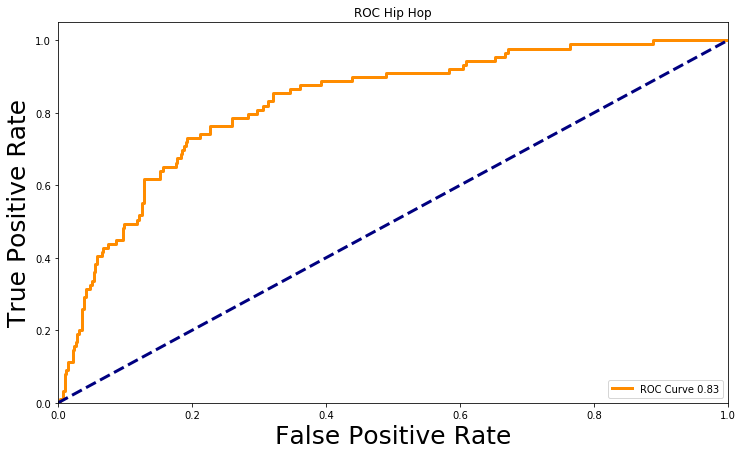

In [192]:
# Plot ROC Curve
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr_hh_test, tpr_hh_test, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc_hh_test)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Hip Hop')
plt.legend(loc="lower right")
plt.show()

## From the ROC curve, it is showing that the model is predicting Hip Hop about .33 more points than random guessing of .50.  The question at hand is how else do we measure the effectiveness of the model? Because predicting a genre is proving difficulty, we need to check another metric, sensitivity, so that we can predict more songs in the genre Hip Hop (low False Negatives), even though it will increase False Positives, or songs that may not be Hip Hop.  Because many genre's are close to one another, finding genres that might be similar, such as R&B, is the better option, which is where sensitivity is applied.  

## Below is a function that will try and find the probability threshold to maximize sensitivity, to make better use of this model.  A higher sensitivity with a lower precision value is the optimal goal to lower both false negatives and false positives.

In [193]:
#print out confusion matrices from .1 to .3 by .01 for Xtest and Xtrain
for prob in range(100,300, 10):
    proba = prob/1000
    
    X_test.loc[:, 'predicted_label']= X_test['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_train.loc[:, 'predicted_label']= X_train['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, X_test['predicted_label']).ravel()
    
    X_test['predicted_label']
    print('Test  ' + str(proba))
    print(confusion_matrix(y_test, X_test['predicted_label']))
    print("Accuracy    : ", accuracy_score(y_test,X_test['predicted_label'] ))
    print("Specificity : ", tn/(tn+fp))
    print("Sensitivity : ", tp/(tp+fn))
    print("Precision   : ", tp/(tp + fp))
    #print(classification_report(y_test, X_test['predicted_label']))
    #print(' Train  ' + str(proba))
    #print(confusion_matrix(y_train, X_train['predicted_label']))


Test  0.1
[[261 154]
 [ 11  78]]
Accuracy    :  0.6726190476190477
Specificity :  0.6289156626506024
Sensitivity :  0.8764044943820225
Precision   :  0.33620689655172414
Test  0.11
[[267 148]
 [ 12  77]]
Accuracy    :  0.6825396825396826
Specificity :  0.6433734939759036
Sensitivity :  0.8651685393258427
Precision   :  0.3422222222222222
Test  0.12
[[278 137]
 [ 13  76]]
Accuracy    :  0.7023809523809523
Specificity :  0.6698795180722892
Sensitivity :  0.8539325842696629
Precision   :  0.3568075117370892
Test  0.13
[[288 127]
 [ 17  72]]
Accuracy    :  0.7142857142857143
Specificity :  0.6939759036144578
Sensitivity :  0.8089887640449438
Precision   :  0.36180904522613067
Test  0.14
[[301 114]
 [ 19  70]]
Accuracy    :  0.7361111111111112
Specificity :  0.7253012048192771
Sensitivity :  0.7865168539325843
Precision   :  0.3804347826086957
Test  0.15
[[309 106]
 [ 21  68]]
Accuracy    :  0.748015873015873
Specificity :  0.744578313253012
Sensitivity :  0.7640449438202247
Precision   :  

|Matrix|     
|-:-|
|TN|FP|
|FN|TP|

In [104]:
X.loc[:, 'predicted_label'] = X_test['predicted_proba'].map(lambda p: 1 if p > .5 else 0)

## Optimal threshold results where sensitivity, accuracy and specificity are about equal.  This gives us a decent amount of true positives, true negatives, and lowers false positives.  We want to predict Hip Hop and generally attempt to get it right about 68% of the time

In [105]:
# Optimal threshold for Hip Hop sensitivity
# Test  0.14
# [[301 114]
#  [ 19  70]]
# Accuracy    :  0.7361111111111112
# Specificity :  0.7253012048192771
# Sensitivity :  0.7865168539325843
# Precision   :  0.3804347826086957

# The results were better selecting one genre, Hip Hop.  Now trying this again with the lowest ranked of the 10 genres, "Roots Reggae" to see if the same results are achieved

In [106]:
rr=audio.copy()

In [107]:
rr['target']="0"

In [108]:
rr.reset_index(drop=True, inplace=True)

In [109]:
rr.head(10)

index         genre  genre_label  start_of_fade_out    tempo  \
0      0       chanson           68            141.607  124.059   
1      1       chanson           68            241.424   80.084   
2     11       hip hop          214            580.702  146.331   
3     15       hip hop          214            379.478  135.503   
4     28    blues-rock           35            312.041   92.971   
5     31    latin jazz          252            186.410   78.843   
6     34    blues-rock           35            260.725  107.183   
7     38    blues-rock           35            195.587  111.523   
8     40    blues-rock           35            461.714  138.512   
9     43  roots reggae          365            206.391  159.943   

   time_signature       bars      beats  key   mode   ...    \
0             4.0   9.560556  46.020881  0.0  0.556   ...     
1             4.0  21.374251  42.903478  1.0 -0.670   ...     
2             4.0  51.113157  75.911117  0.0  0.587   ...     
3             5.0  22.493910  54.521671  1.0  0.155   ...     
4             4.0  21.228022  14.614580  3.0 -0.573   ...     
5             7.0   5.842103  23.004907  7.0  0.416   ...     
6             1.0  91.167323  91.167323  0.0  0.660   ...     
7             1.0  48.531004  48.531004  3.0  0.094   ...     
8             4.0  31.975025  89.806909  1.0 -0.711   ...     
9             4.0   9.924940  71.526352  1.0  0.167   ...     

   segments_timbre_mean  segments_loudness_max_mean  \
0              2.050151                  -12.216512   
1              5.169785                  -16.459136   
2              3.375428                   -6.809419   
3             15.489554                  -10.167091   
4              2.510657                   -5.468947   
5             12.403654                   -7.622960   
6              5.052139                  -10.937534   
7              7.661419                  -12.313801   
8              0.407918                  -13.002798   
9              1.286391                  -10.390579   

   segments_loudness_max_time_mean  segments_loudness_start_mean  \
0                         0.052350                    -19.229238   
1                         0.086557                    -21.786326   
2                         0.107121                    -11.015026   
3                         0.042906                    -23.002772   
4                         0.073483                    -10.656824   
5                         0.048740                    -21.197200   
6                         0.054830                    -22.393121   
7                         0.057571                    -24.811441   
8                         0.050493                    -20.709356   
9                         0.052812                    -19.726880   

   sections_start_mean  beats_start_mean  bars_start_mean  tatums_start_mean  \
0            57.679828         71.025470        70.298204          71.025247   
1           119.968496        123.794350       130.630938         123.792848   
2           296.464534        289.450339       289.029750         289.346392   
3           187.673563        196.156957       195.271196         196.083124   
4           143.844608        159.276476       156.730738         159.436523   
5            85.046258         94.058322        90.246028          94.287176   
6           118.236165        140.374237       140.374237         140.374228   
7           110.511598        104.038474       104.038474         103.901682   
8           214.400463        229.943618       229.075837         229.943928   
9            84.228634        107.510459       106.760205         107.604269   

   key_values  target  
0           C       0  
1          C#       0  
2           C       0  
3          C#       0  
4          Eb       0  
5           G       0  
6           C       0  
7          Eb       0  
8          C#       0  
9          C#       0  

[10 rows x 26 columns]

In [110]:
rr['target'].value_counts()

0    2013
Name: target, dtype: int64

In [111]:
#setting a target variable of 1 if the genre is roots reggae
a=0
for i in range((rr.shape[0])):
    x=(rr.iloc[:,1][i])
    a = 0
    if x =='roots reggae':
        a = 1
    if x != 'roots reggae':
        a = 0
        
    rr['target'][i] = a

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [194]:
#Set X, y variables

features_rr=rr[['start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
                'mode', 'mode_orig','tatums','loudness','duration','segments_start_mean','segments_pitches_mean',
                'segments_timbre_mean','segments_loudness_max_mean','segments_loudness_max_time_mean',
                'segments_loudness_start_mean','sections_start_mean','beats_start_mean','bars_start_mean',
                'tatums_start_mean']]

X=features_rr

rr['target']=rr.target.astype(int)
y=rr['target']

#train, test, split
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

In [113]:
rr.head()

index       genre  genre_label  start_of_fade_out    tempo  time_signature  \
0      0     chanson           68            141.607  124.059             4.0   
1      1     chanson           68            241.424   80.084             4.0   
2     11     hip hop          214            580.702  146.331             4.0   
3     15     hip hop          214            379.478  135.503             5.0   
4     28  blues-rock           35            312.041   92.971             4.0   

        bars      beats  key   mode   ...    segments_timbre_mean  \
0   9.560556  46.020881  0.0  0.556   ...                2.050151   
1  21.374251  42.903478  1.0 -0.670   ...                5.169785   
2  51.113157  75.911117  0.0  0.587   ...                3.375428   
3  22.493910  54.521671  1.0  0.155   ...               15.489554   
4  21.228022  14.614580  3.0 -0.573   ...                2.510657   

   segments_loudness_max_mean  segments_loudness_max_time_mean  \
0                  -12.216512                         0.052350   
1                  -16.459136                         0.086557   
2                   -6.809419                         0.107121   
3                  -10.167091                         0.042906   
4                   -5.468947                         0.073483   

   segments_loudness_start_mean  sections_start_mean  beats_start_mean  \
0                    -19.229238            57.679828         71.025470   
1                    -21.786326           119.968496        123.794350   
2                    -11.015026           296.464534        289.450339   
3                    -23.002772           187.673563        196.156957   
4                    -10.656824           143.844608        159.276476   

   bars_start_mean  tatums_start_mean  key_values  target  
0        70.298204          71.025247           C       0  
1       130.630938         123.792848          C#       0  
2       289.029750         289.346392           C       0  
3       195.271196         196.083124          C#       0  
4       156.730738         159.436523          Eb       0  

[5 rows x 26 columns]

In [114]:
rfc_rr=RandomForestClassifier(criterion='gini', max_depth=5,n_estimators=300, max_features='log2',random_state=42)
rfc_rr.fit(X_train, y_train)
accuracy_rfc_rr = rfc_rr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_rfc_rr))
acc_rfc_rr = testingModel(rfc_rr, X_train, y_train)

Accuracy: 0.92%
Scores            : [0.87746479 0.87535211 0.81377152 0.87167449 0.95618153 0.78873239
 0.7942097  0.7178881  0.91410559 0.83530339]
Mean              : 0.8444683625789411
Standard Deviation: 0.06541651706483631


In [115]:
# View Feature Importance from Random Forest model
raw_data_rr={'RF Imp':rfc_rr.feature_importances_}
rfc2_rr_df=pd.DataFrame(raw_data_rr,features_rr.columns)
rfc2_rr_df=rfc2_rr_df.sort_values('RF Imp', ascending=False) 
rfc2_rr_df

RF Imp
tatums                           0.152434
tempo                            0.127578
beats                            0.076494
bars                             0.064977
segments_loudness_start_mean     0.064558
segments_pitches_mean            0.052756
segments_loudness_max_time_mean  0.050827
mode                             0.047000
sections_start_mean              0.040304
duration                         0.034872
tatums_start_mean                0.034867
segments_timbre_mean             0.033570
loudness                         0.033248
segments_start_mean              0.033050
beats_start_mean                 0.032956
start_of_fade_out                0.032113
segments_loudness_max_mean       0.030917
bars_start_mean                  0.030633
key                              0.016458
time_signature                   0.005394
mode_orig                        0.004994

In [116]:
ad_rr = AdaBoostClassifier(n_estimators=100,learning_rate=0.2)
ad_rr.fit(X_train,y_train)
score_rr=ad_rr.score(X_train, y_train)
accuracy_ad_rr = ad_rr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_ad_rr))
acc_ad_rr = testingModel(ad_rr, X_train, y_train)

Accuracy: 0.93%
Scores            : [0.79014085 0.71197183 0.85837246 0.92488263 0.97104851 0.85680751
 0.79499218 0.59968479 0.83766745 0.87391647]
Mean              : 0.8219484677965347
Standard Deviation: 0.10077214594946379


In [117]:
# View Feature Importance from ADA Boost model
raw_data_rr={'ADA Imp':ad_rr.feature_importances_}
ada2_rr_df=pd.DataFrame(raw_data_rr,features_rr.columns)
ada2_rr_df=ada2_rr_df.sort_values('ADA Imp', ascending=False) 
ada2_rr_df

ADA Imp
tempo                               0.24
tatums                              0.17
segments_loudness_start_mean        0.13
segments_pitches_mean               0.12
mode                                0.06
bars                                0.05
start_of_fade_out                   0.04
sections_start_mean                 0.04
segments_loudness_max_mean          0.04
segments_timbre_mean                0.03
segments_start_mean                 0.03
bars_start_mean                     0.01
segments_loudness_max_time_mean     0.01
duration                            0.01
loudness                            0.01
tatums_start_mean                   0.01
mode_orig                           0.00
key                                 0.00
beats                               0.00
beats_start_mean                    0.00
time_signature                      0.00

In [118]:
model_rr = XGBClassifier()
model_rr.fit(X_train, y_train)
model_rr.predict(X_train)
# make predictions for test data
y_pred_rr = model_rr.predict(X_test)
accuracy_model_rr = model_rr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_model_rr))
acc_model_rr = testingModel(model_rr, X_train, y_train)

Accuracy: 0.93%


/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Scores            : [0.87676056 0.94507042 0.87167449 0.92018779 0.96244131 0.89906103
 0.84898279 0.76516942 0.94168637 0.84791174]
Mean              : 0.8878945937246806
Standard Deviation: 0.05607911083997846


In [119]:
# View Feature Importance from XG Boost model
raw_data_rr={'XGB Imp':model_rr.feature_importances_}
XGB2_rr_df=pd.DataFrame(raw_data_rr,features_rr.columns)
XGB2_rr_df=XGB2_rr_df.sort_values('XGB Imp', ascending=False) 
XGB2_rr_df

XGB Imp
tempo                            0.162295
tatums                           0.144262
segments_loudness_start_mean     0.108197
mode                             0.090164
segments_pitches_mean            0.088525
bars                             0.070492
segments_loudness_max_time_mean  0.052459
segments_timbre_mean             0.049180
sections_start_mean              0.037705
segments_loudness_max_mean       0.031148
loudness                         0.029508
beats                            0.026230
duration                         0.024590
start_of_fade_out                0.019672
segments_start_mean              0.019672
time_signature                   0.014754
key                              0.013115
bars_start_mean                  0.006557
tatums_start_mean                0.006557
beats_start_mean                 0.004918
mode_orig                        0.000000

In [120]:
lr_rr = LogisticRegression()
lr_rr.fit(X_train, y_train)
print("Train Score :", lr_rr.score(X_train, y_train))
accuracy_lr_rr = lr_rr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_lr_rr))
acc_lr_rr = testingModel(lr_rr, X_train, y_train)

Train Score : 0.9377070907886017
Accuracy: 0.92%
Scores            : [0.88661972 0.81760563 0.80985915 0.83333333 0.87323944 0.8286385
 0.74178404 0.82584712 0.92277384 0.85500394]
Mean              : 0.8394704713703816
Standard Deviation: 0.04667147548736461


In [121]:
#combine and display model results
results_rr = pd.DataFrame({
    'Model': ['ADA', 'Logistic Regression','Random Forest', 'XGB'],
    'Score': [acc_ad_rr, acc_lr_rr, acc_rfc_rr, acc_model_rr]})
result_rr_df = results_rr.sort_values(by='Score', ascending=False)
#result_df = result_df.set_index('Score')
result_rr_df.head(10)

Model     Score
3                  XGB  0.887895
2        Random Forest  0.844468
1  Logistic Regression  0.839470
0                  ADA  0.821948

## Evaluating the model

In [195]:
y_hat_rr = model_rr.predict(X_test)
y_hat_train_rr = model_rr.predict(X_train)
y_hat_prob_rr = model_rr.predict_proba(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [196]:
y_train_pred_proba_rr = model_rr.predict_proba(X_train)
y_train_pred_rr = model_rr.predict(X_train)
y_test_pred_proba_rr = model_rr.predict_proba(X_test)
y_test_pred_rr = model_rr.predict(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [197]:
#modifying train and testing data to allow for changing prob thresholds and printing the roc curves
X_train.loc[:, 'actual_y'] = y_train
X_train.loc[:, 'predicted_label'] = y_train_pred_rr
X_train.loc[:, 'predicted_proba'] = y_train_pred_proba_rr[:, 1]

X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_test_pred_rr
X_test.loc[:, 'predicted_proba'] = y_test_pred_proba_rr[:, 1]

In [198]:
confusion_matrix(y_train, y_hat_train_rr)

array([[1416,    1],
       [  35,   57]])

In [199]:
confusion_matrix(y_test, y_hat_rr)

array([[459,   6],
       [ 29,  10]])

In [200]:
print(classification_report( y_train, y_hat_train_rr))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1417
          1       0.98      0.62      0.76        92

avg / total       0.98      0.98      0.97      1509



In [201]:
print(classification_report(y_test, y_hat_rr))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       465
          1       0.62      0.26      0.36        39

avg / total       0.92      0.93      0.92       504



In [202]:
fpr_rr_test, tpr_rr_test, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc_rr_test = auc(fpr_rr_test, tpr_rr_test)

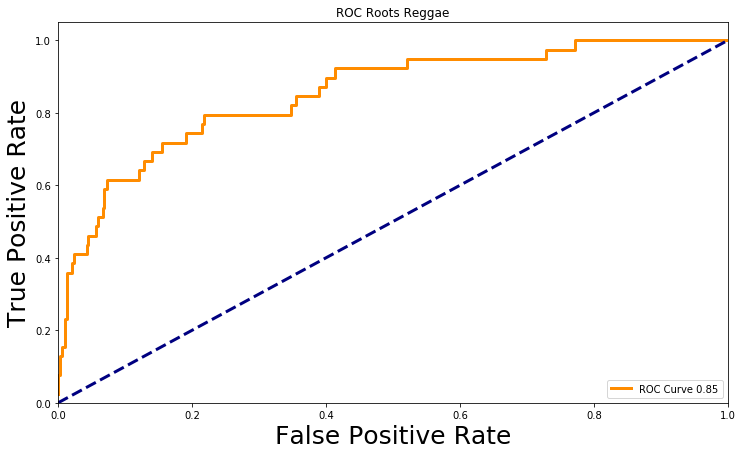

In [203]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr_rr_test, tpr_rr_test, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc_rr_test)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Roots Reggae')
plt.legend(loc="lower right")
plt.show()

## From the ROC curve, it is showing that the model is predicting Roots Reggae about .35 more than random guessing of .50.  Much like we did for Hip Hop, the same idea will be applied here to maximize sensitivity to predict more songs correctly.  This could be due to Reggae having a unique sound compared to other genres that more easily bleed over between genres.  

## Below is a function that will try and find the probability threshold to maximize sensitivity, to make better use of this model.  A higher sensitivity with a lower precision value is the optimal goal to lower both false negatives and false positives.

In [204]:
#print out confusion matrices from .1 to .3 by .01 for Xtest and Xtrain
for prob in range(100,300, 10):
    proba = prob/1000
    
    X_test.loc[:, 'predicted_label']= X_test['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_train.loc[:, 'predicted_label']= X_train['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, X_test['predicted_label']).ravel()
    
    X_test['predicted_label']
    print('Test  ' + str(proba))
    print(confusion_matrix(y_test, X_test['predicted_label']))
    print("Accuracy    : ", accuracy_score(y_test,X_test['predicted_label'] ))
    print("Specificity : ", tn/(tn+fp))
    print("Sensitivity : ", tp/(tp+fn))
    print("Precision   : ", tp/(tp + fp))
    #print(classification_report(y_test, X_test['predicted_label']))
    #print(' Train  ' + str(proba))
    #print(confusion_matrix(y_train, X_train['predicted_label']))


Test  0.1
[[425  40]
 [ 15  24]]
Accuracy    :  0.8908730158730159
Specificity :  0.9139784946236559
Sensitivity :  0.6153846153846154
Precision   :  0.375
Test  0.11
[[431  34]
 [ 16  23]]
Accuracy    :  0.9007936507936508
Specificity :  0.9268817204301075
Sensitivity :  0.5897435897435898
Precision   :  0.40350877192982454
Test  0.12
[[431  34]
 [ 16  23]]
Accuracy    :  0.9007936507936508
Specificity :  0.9268817204301075
Sensitivity :  0.5897435897435898
Precision   :  0.40350877192982454
Test  0.13
[[435  30]
 [ 19  20]]
Accuracy    :  0.9027777777777778
Specificity :  0.9354838709677419
Sensitivity :  0.5128205128205128
Precision   :  0.4
Test  0.14
[[437  28]
 [ 19  20]]
Accuracy    :  0.9067460317460317
Specificity :  0.9397849462365592
Sensitivity :  0.5128205128205128
Precision   :  0.4166666666666667
Test  0.15
[[438  27]
 [ 20  19]]
Accuracy    :  0.9067460317460317
Specificity :  0.9419354838709677
Sensitivity :  0.48717948717948717
Precision   :  0.41304347826086957
Test 

In [132]:
X.loc[:, 'predicted_label'] = X_test['predicted_proba'].map(lambda p: 1 if p > .84 else 0)

## Optimal threshold for Roots Reggae is 0.1.  Here, it is near impossible to increase sensitivity.  The model can only accurately predict specificity, meaning there are a lot of songs thats will be classified as Roots Reggae that really aren't.  So as the classes become more unbalanced, sensitivity is greatly minimized.  Again it might have something to do with Reggae music being unique and the model it picking those features up appropriately.

In [133]:
# Test  0.1
# [[425  40]
#  [ 15  24]]
# Accuracy    :  0.8908730158730159
# Specificity :  0.9139784946236559
# Sensitivity :  0.6153846153846154
# Precision   :  0.375

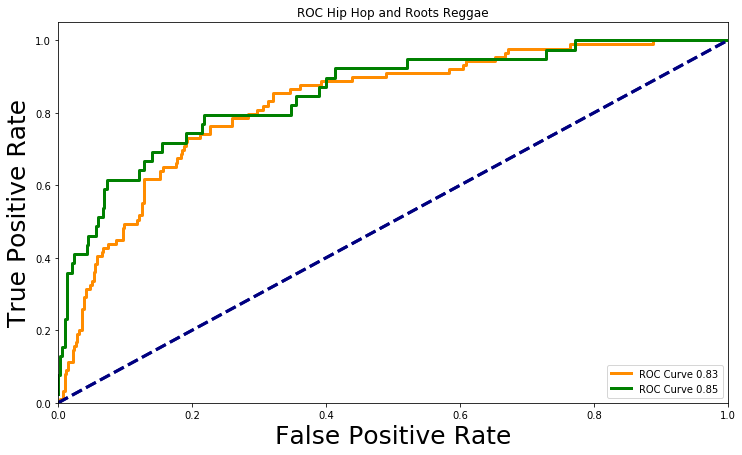

In [134]:
#Plotting Hip Hop and Roots Reggae ROC curves together
fpr, tpr, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc = auc(fpr, tpr)

# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr_hh_test, tpr_hh_test, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc_hh_test)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")
plt.plot(fpr_rr_test, tpr_rr_test, lw = line_width, color="green", label = "ROC Curve %.2f" % roc_auc_rr_test)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")



plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Hip Hop and Roots Reggae')
plt.legend(loc="lower right")
plt.show()

## A final process to add other features, besides audio features, to see if it affects the predicting

In [135]:
hh_new=music[['genre','genre_label','start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
              'mode', 'mode_orig','tatums','loudness','duration','segments_start_mean','segments_pitches_mean',
              'segments_timbre_mean','segments_loudness_max_mean','segments_loudness_max_time_mean',
              'segments_loudness_start_mean','sections_start_mean','beats_start_mean','bars_start_mean',
              'tatums_start_mean','location_new','title_new','artist.name_new','decade']]

In [136]:
hh_new['target']="0"

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [137]:
#filter df
array = ['hip hop',"blues-rock",'ccm','chanson','country rock','latin jazz','post-grunge','dance pop',
         'gangster rap', 'roots reggae']
hh_new=hh_new.loc[hh_new['genre'].isin(array)]
hh_new.reset_index(drop=True, inplace=True)

In [138]:
#hh_new.drop(columns='target', inplace=True)

In [139]:
#function to make hip hop the target variable
a=0
for i in range((hh_new.shape[0])):
    x=(hh_new.iloc[:,0][i])
    a = 0
    if x =='hip hop':
        a = 1
    if x != 'hip hop':
        a = 0
        
    hh_new['target'][i] = a

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [205]:
features=hh_new[['start_of_fade_out', 'tempo', 'time_signature', 'bars', 'beats', 'key',
                 'mode', 'mode_orig','tatums','loudness','duration','segments_start_mean','segments_pitches_mean',
                 'segments_timbre_mean','segments_loudness_max_mean','segments_loudness_max_time_mean',
                 'segments_loudness_start_mean','sections_start_mean','beats_start_mean','bars_start_mean',
                 'tatums_start_mean','location_new','title_new','artist.name_new','decade']]

X=features

hh_new['target']=hh_new.target.astype(int)
y=hh_new['target']


X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

In [141]:
model_hh_new = XGBClassifier()
model_hh_new.fit(X_train, y_train)
model_hh_new.predict(X_train)
# make predictions for test data
y_pred = model_hh_new.predict(X_test)
accuracy_model_hh_new = model_hh_new.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy_model_hh_new))
acc_model_hh_new = testingModel(model_hh_new, X_train, y_train)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.86%
Scores            : [0.88186813 0.90903541 0.83938462 0.89169231 0.80861538 0.85169231
 0.86430769 0.86336    0.82592    0.91488   ]
Mean              : 0.8650755848595848
Standard Deviation: 0.03311641651270474


In [142]:
# View Feature Importance from XG Boost model
raw_data_hh_new={'XGB Imp':model_hh_new.feature_importances_}
XGB2_hh_new_df=pd.DataFrame(raw_data_hh_new,features.columns)
XGB2_hh_new_df=XGB2_hh_new_df.sort_values('XGB Imp', ascending=False) 
XGB2_hh_new_df

XGB Imp
artist.name_new                  0.128593
segments_loudness_start_mean     0.110439
location_new                     0.098336
segments_pitches_mean            0.093797
segments_loudness_max_time_mean  0.078669
loudness                         0.069592
tempo                            0.069592
segments_timbre_mean             0.042360
key                              0.040847
tatums                           0.034796
segments_start_mean              0.033283
mode                             0.030257
title_new                        0.028744
bars                             0.027231
segments_loudness_max_mean       0.027231
sections_start_mean              0.019667
start_of_fade_out                0.018154
decade                           0.018154
beats                            0.013616
time_signature                   0.010590
bars_start_mean                  0.003026
duration                         0.001513
beats_start_mean                 0.001513
tatums_start_mean                0.000000
mode_orig                        0.000000

In [143]:
#combine and display model results
results = pd.DataFrame({
    'Model': ['XGB-Audio', 'XGB-Audio +'],
    'Score': [acc_model_hh, acc_model_hh_new]})
result_df = results.sort_values(by='Score', ascending=False)
#result_df = result_df.set_index('Score')
result_df

Model     Score
1  XGB-Audio +  0.865076
0    XGB-Audio  0.835932

## Evaluating the model

In [206]:
y_hat_hh_new = model_hh_new.predict(X_test)
y_hat_train_hh_new = model_hh_new.predict(X_train)
y_hat_prob_hh_new = model_hh_new.predict_proba(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [207]:
y_train_pred_proba = model_hh_new.predict_proba(X_train)
y_train_pred = model_hh_new.predict(X_train)
y_test_pred_proba = model_hh_new.predict_proba(X_test)
y_test_pred = model_hh_new.predict(X_test)

/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samlundberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [208]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves
X_train.loc[:, 'actual_y'] = y_train
X_train.loc[:, 'predicted_label'] = y_train_pred
X_train.loc[:, 'predicted_proba'] = y_train_pred_proba[:, 1]

X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_test_pred
X_test.loc[:, 'predicted_proba'] = y_test_pred_proba[:, 1]

In [147]:
confusion_matrix(y_train, y_hat_train_hh_new)

array([[1249,    3],
       [  91,  166]])

In [148]:
confusion_matrix(y_test, y_hat_hh_new)

array([[400,  15],
       [ 57,  32]])

In [149]:
print(classification_report( y_train, y_hat_train_hh_new))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96      1252
          1       0.98      0.65      0.78       257

avg / total       0.94      0.94      0.93      1509



In [150]:
print(classification_report(y_test, y_hat_hh_new))

             precision    recall  f1-score   support

          0       0.88      0.96      0.92       415
          1       0.68      0.36      0.47        89

avg / total       0.84      0.86      0.84       504



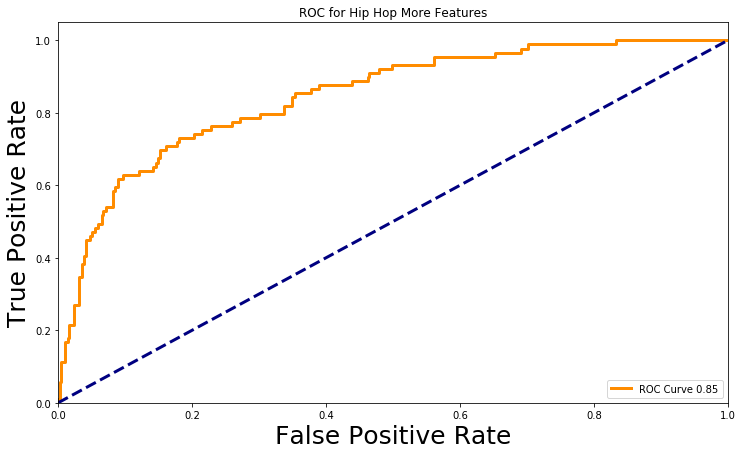

In [151]:
fpr_hh_new_test, tpr_hh_new_test, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc_hh_new_test = auc(fpr_hh_new_test, tpr_hh_new_test)

# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr_hh_new_test, tpr_hh_new_test, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc_hh_new_test)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Hip Hop More Features')
plt.legend(loc="lower right")
plt.show()

## Adding additional features to just the audio features, proved beneficial in the model score and ROC curve.  The ROC score improved by .02 and accuracy increased by .03.  Not a surprising increase, as you can start finding more and more identifying features to a song, that can better help predict the genre.  Still trying to optimize for sensitivity, the same function will be used below to find the best threshold to maximize sensitivity.

In [209]:
#print out confusion matrices from .1 to .3 by .01 for Xtest and Xtrain
for prob in range(100,300, 10):
    proba = prob/1000
    
    X_test.loc[:, 'predicted_label']= X_test['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_train.loc[:, 'predicted_label']= X_train['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, X_test['predicted_label']).ravel()
    
    X_test['predicted_label']
    print('Test  ' + str(proba))
    print(confusion_matrix(y_test, X_test['predicted_label']))
    print("Accuracy    : ", accuracy_score(y_test,X_test['predicted_label'] ))
    print("Specificity : ", tn/(tn+fp))
    print("Sensitivity : ", tp/(tp+fn))
    print("Precision   : ", tp/(tp + fp))
    #print(classification_report(y_test, X_test['predicted_label']))
    #print(' Train  ' + str(proba))
    #print(confusion_matrix(y_train, X_train['predicted_label']))


Test  0.1
[[275 140]
 [ 17  72]]
Accuracy    :  0.6884920634920635
Specificity :  0.6626506024096386
Sensitivity :  0.8089887640449438
Precision   :  0.33962264150943394
Test  0.11
[[287 128]
 [ 18  71]]
Accuracy    :  0.7103174603174603
Specificity :  0.691566265060241
Sensitivity :  0.797752808988764
Precision   :  0.35678391959798994
Test  0.12
[[297 118]
 [ 19  70]]
Accuracy    :  0.7281746031746031
Specificity :  0.7156626506024096
Sensitivity :  0.7865168539325843
Precision   :  0.3723404255319149
Test  0.13
[[302 113]
 [ 19  70]]
Accuracy    :  0.7380952380952381
Specificity :  0.727710843373494
Sensitivity :  0.7865168539325843
Precision   :  0.3825136612021858
Test  0.14
[[316  99]
 [ 21  68]]
Accuracy    :  0.7619047619047619
Specificity :  0.7614457831325301
Sensitivity :  0.7640449438202247
Precision   :  0.40718562874251496
Test  0.15
[[320  95]
 [ 21  68]]
Accuracy    :  0.7698412698412699
Specificity :  0.7710843373493976
Sensitivity :  0.7640449438202247
Precision   :  

In [153]:
X.loc[:, 'predicted_label'] = X_test['predicted_proba'].map(lambda p: 1 if p > .5 else 0)

## The optimal threshold for predicting Hip Hop with more features is .14.  This optimizes sensitivity, specificity, and accuracy to be around 76%.  Compare this to just the audio features, where the 3 scores were around 76%, that is a decent improvement, so the model is going in the right direction.  

## The same tests could be done on Roots Reggae, but I suspect there would be similar results, since genre identification seems more than just audio related

In [154]:
#optimal threshold for Hip Hop with addidional features
# Test  0.14
# [[316  99]
#  [ 21  68]]
# Accuracy    :  0.7619047619047619
# Specificity :  0.7614457831325301
# Sensitivity :  0.7640449438202247
# Precision   :  0.40718562874251496

### A couple of visualizations of where Hip Hop and Roots Reggae are popular in the world

In [155]:
#export roots reggae locations for tableau
rrn=music[['artist_latitude','artist_longitude','genre']]
rrn=rrn[rrn['genre'] =="roots reggae"]
rrn=rrn[rrn['artist_longitude'] != 0]
rrn.reset_index(drop=True, inplace=True)
rrn.to_csv('./data/rrn.csv')

In [156]:
#export hip hop locations for tableau
hhn=music[['artist_latitude','artist_longitude','genre']]
hhn=hhn[hhn['genre'] =="hip hop"]
hhn=hhn[hhn['artist_longitude'] != 0]
hhn.reset_index(drop=True, inplace=True)
hhn.to_csv('./data/hhn.csv')

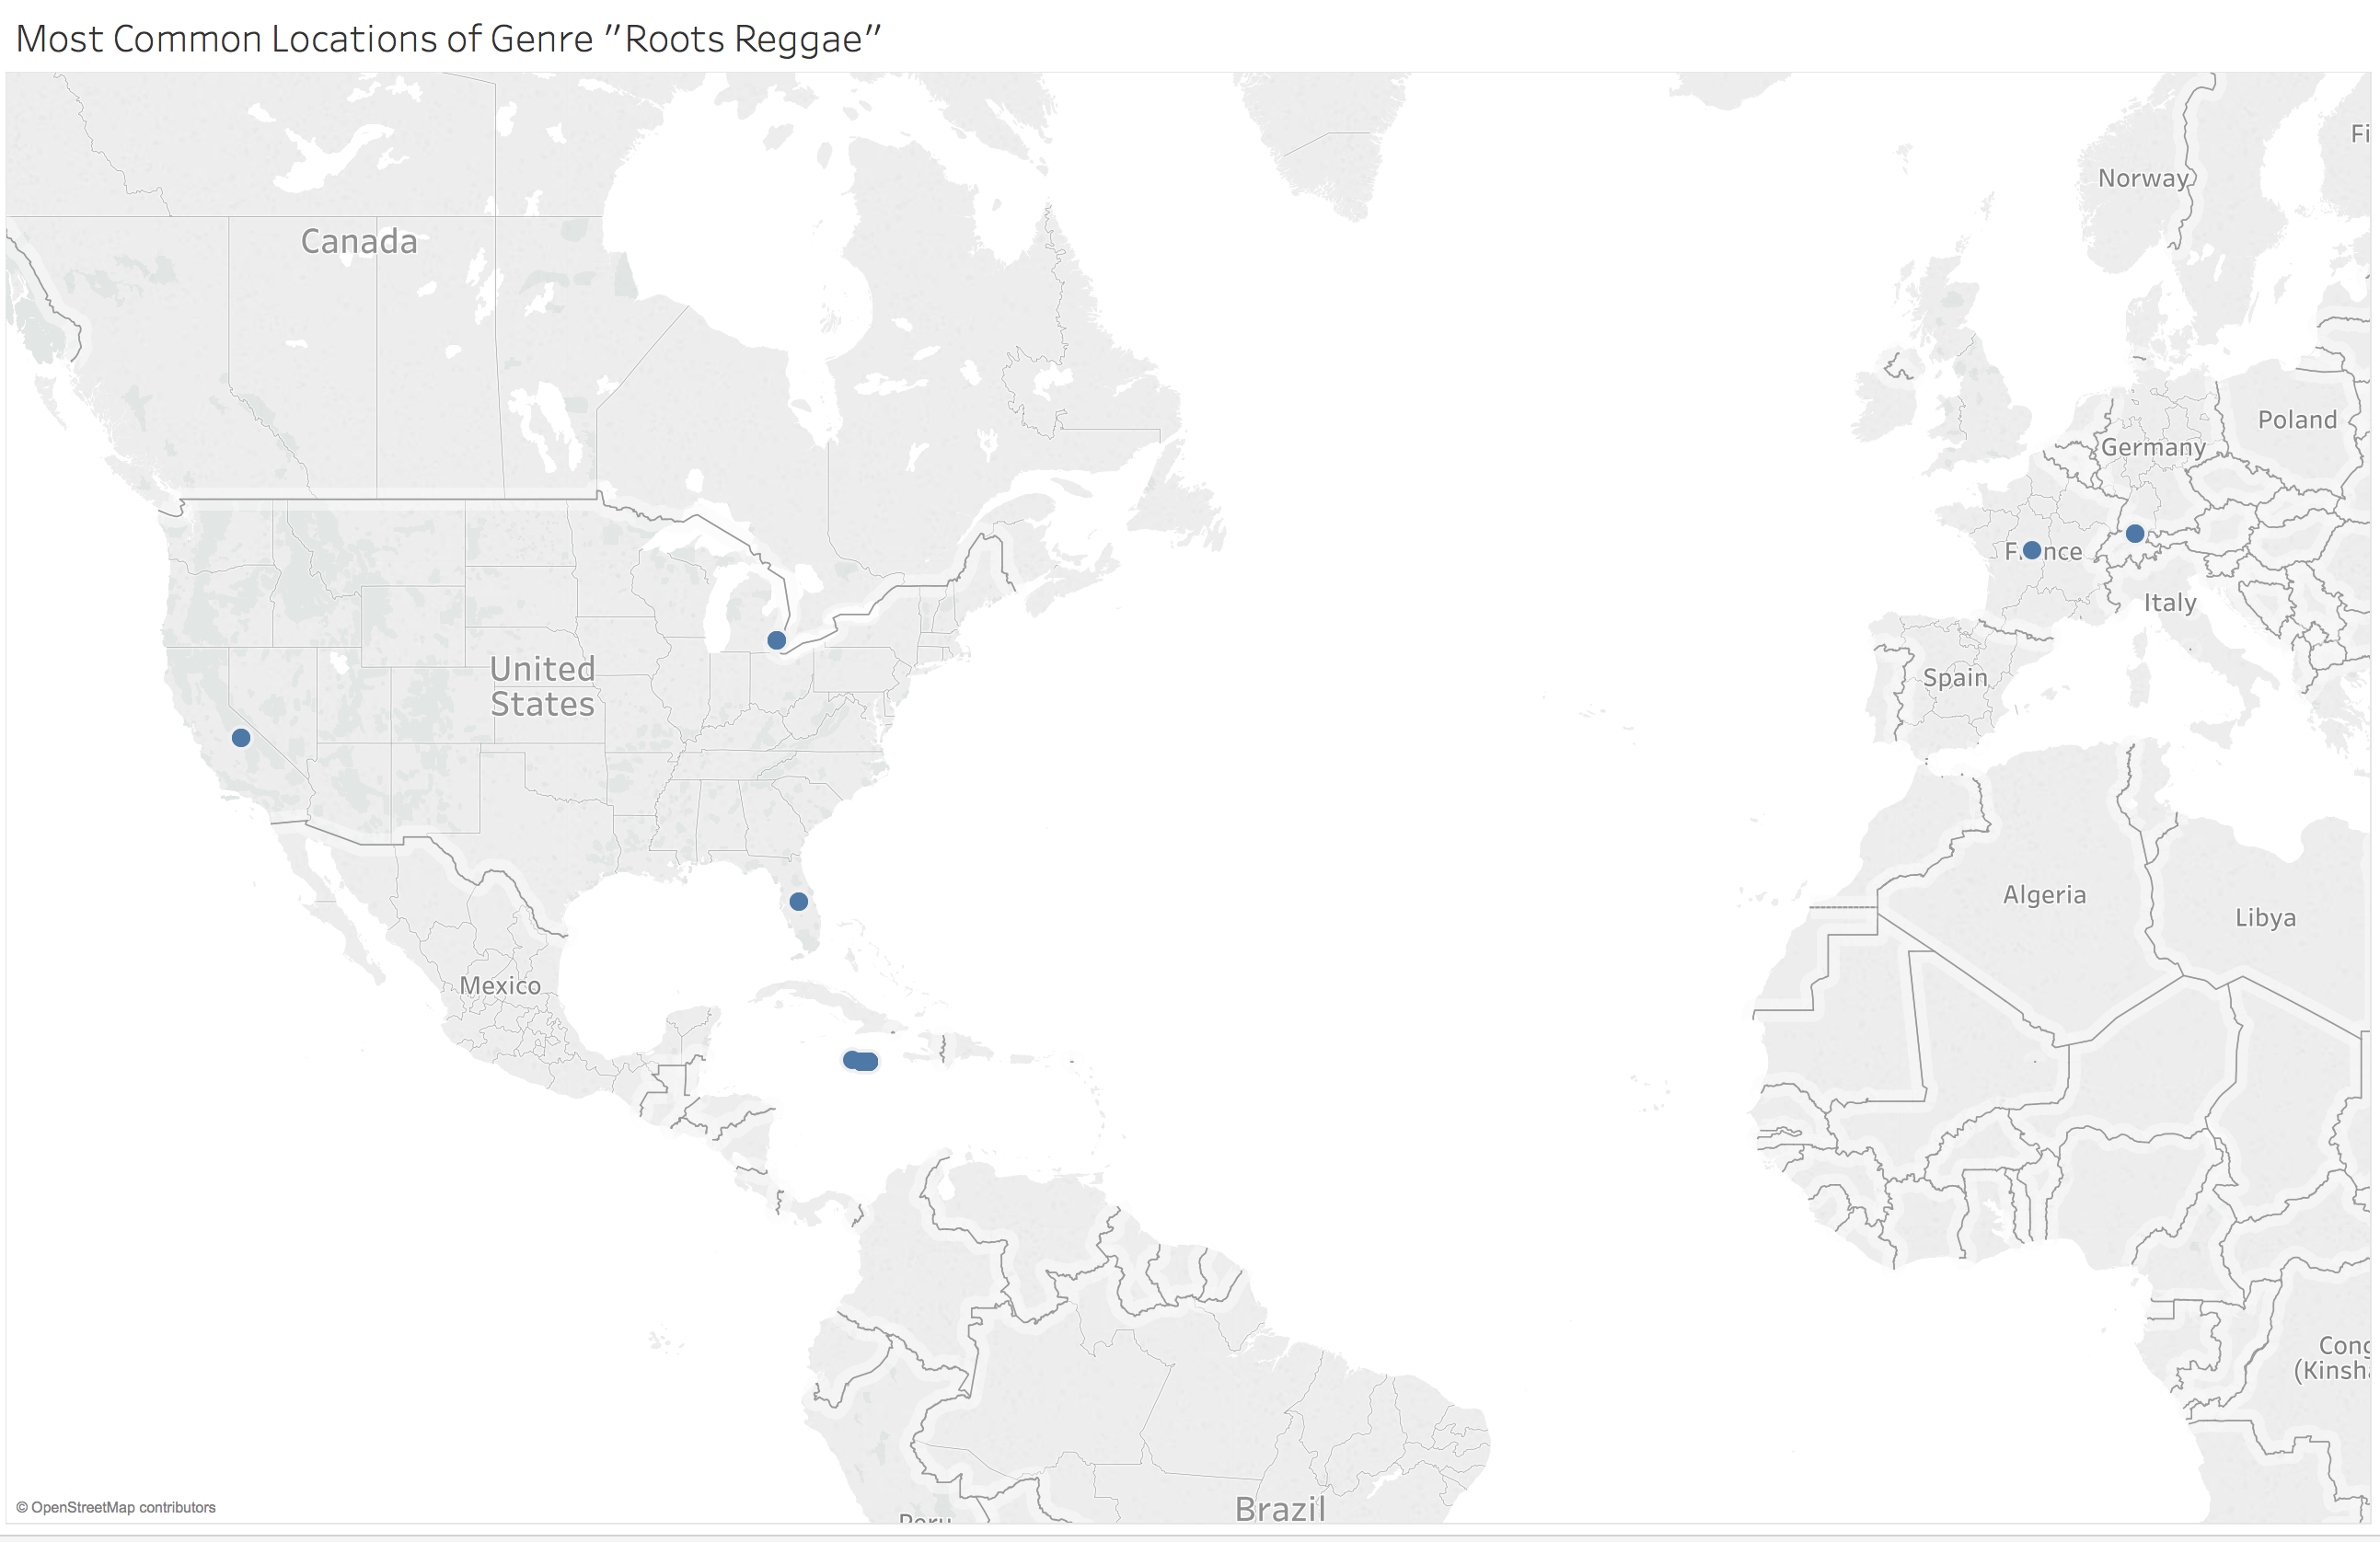

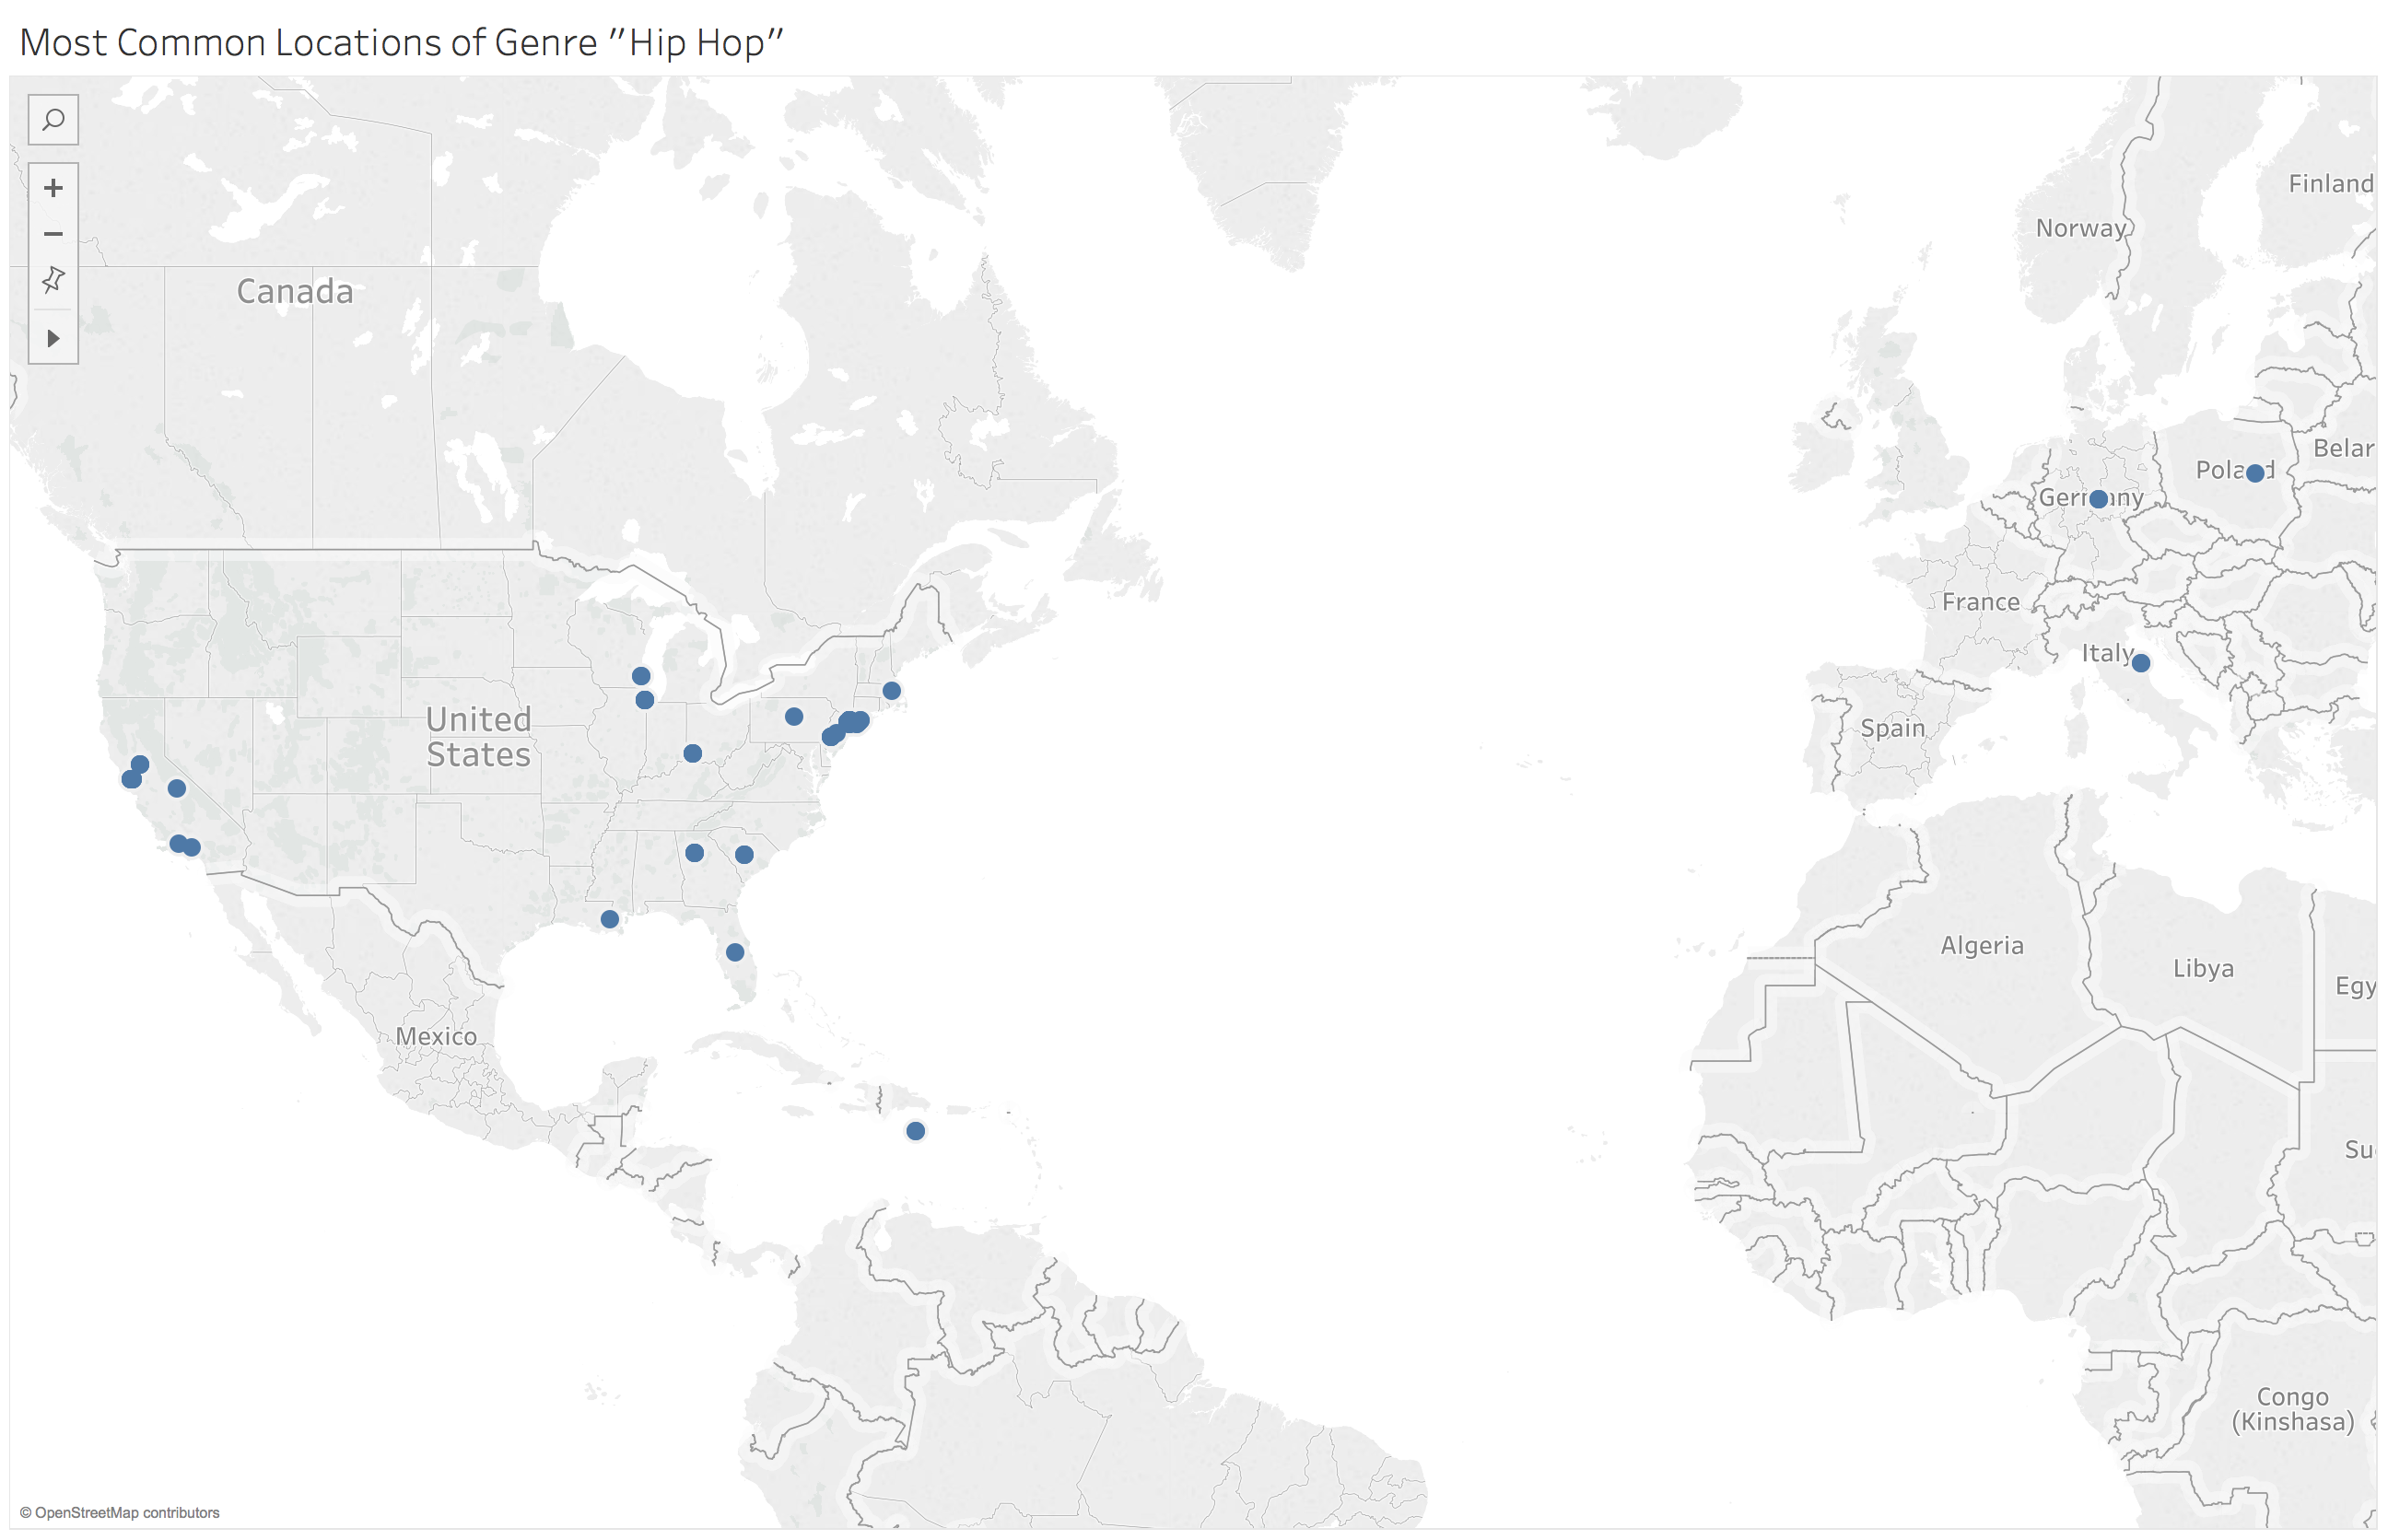